# Generating Thesis Figures and Tables

In [1]:
import pathlib
import time
import glob
import pickle
import json
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats
import multiprocessing as mp

from tqdm._tqdm_notebook import tqdm
from tqdm.contrib.concurrent import process_map


SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGGER_SIZE = 11



def set_plot_style():
    sns.set_context('paper')
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def get_plot_size(f_r, f_c, i_r, i_c, width_multiplier = 1):
    cm = 1/2.54
    page_width = 16*cm
    margin = 0.5*cm
    row_height = 6*cm

    num_h_margins = f_c-1
    avail_width = (page_width * width_multiplier) - (margin * num_h_margins)
    num_v_margins = f_r-1
    avail_height = (row_height * f_r) + (margin * num_v_margins)

    return (avail_width * (i_c / f_c), avail_height * (i_r / f_r))


set_plot_style()
data_path = pathlib.Path(r'G:\My Drive\UniMine\Uni\PhD\Thesis\Data')
data_path.exists()

C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/112041090.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm


True

In [2]:
print(get_plot_size(1, 1, 1, 1))
print(get_plot_size(2, 1, 2, 1))

(6.299212598425196, 2.3622047244094486)
(6.299212598425196, 4.921259842519684)


## Chapter 2

### Noise example - Fig 2.4

In [216]:
output_location = pathlib.Path("Chap2")
if not output_location.exists():
    output_location.mkdir(parents=True)
output_prefix = "PRELIM"

In [219]:
def noise_example_labelling_function(x):
    x1, x2 = x
    return x1 * x2

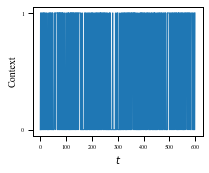

In [220]:
#PLOT RANDOM CONTEXT
x1 = np.random.randint(0, 2, 600)
x2 = np.random.randint(0, 2, 600)
y = np.array(list(map(noise_example_labelling_function, zip(x1, x2))))

fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
ax.plot(list(range(x1.shape[0])), x2, lw=1)
ax.set_ylabel("Context")
ax.set_xlabel("$t$")
ax.set_yticks([0, 1])
fig.savefig(output_location / f"{output_prefix}-noise_H_example2.pdf", bbox_inches='tight')

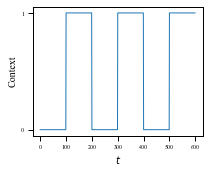

In [221]:
# PLOT NON-RANDOM CONTEXT
x1 = np.random.randint(0, 2, 600)
x2 = np.array([*[0]*100, *[1]*100]*3)
y = np.array(list(map(noise_example_labelling_function, zip(x1, x2))))

fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
ax.plot(list(range(x1.shape[0])), x2, lw=1)
ax.set_ylabel("Context")
ax.set_xlabel("$t$")
ax.set_yticks([0, 1])
fig.savefig(output_location / f"{output_prefix}context_H_example2.pdf", bbox_inches='tight')

## Chapter 4 - Memory Management

### Utils for extracting data from raw files

In [3]:
rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP"}
# metric_replace = {'driftdetect_accuracy_50': "Drift point accuracy", 'accuracy':"Accuracy", 'f1':"$F1_c$", 'f1 by System': "$F1_s$", 'Num Good System Concepts' : '$s \\approx c$',
    # "time": "Time (s)", "memory": "Memory (KB)", "run_noise": "Noise Proportion", "merge_similarity" : "Kappa Agreement Threshold", "drift_window": "Drift Window Size"}
metric_replace = {'driftdetect_accuracy_50': "Recovery accuracy", 'accuracy':"Accuracy", 'f1':"C-F1", 'f1 by System': "S-F1", 'Num Good System Concepts' : '$s \\approx c$',
    "time": "Time (s)", "memory": "Memory (KB)", "run_noise": "Noise Proportion", "merge_similarity" : "Kappa Agreement Threshold", "drift_window": "Drift Window Size"}

# metric_replace = {'driftdetect_accuracy_50': "Recovery accuracy", 'accuracy':"Accuracy", 'f1':"$F1_c$", 'f1 by System': "$F1_s$", 'Num Good System Concepts' : '$s \\approx c$',
    # "time": "Time (s)", "memory": "Memory (KB)"}

def parenthesis_mean_stdev(series, decimal_mean=2, decimal_stdev=2):
    """ Aggragates mean and stdev into a single string value
    """
    m = np.mean(series)
    std = np.std(series)

    return f"{m:.{decimal_mean}f} ({std:.{decimal_stdev}f})"

def custom_ttest_index(index):
    """ Returns a series aggragation function testing the given index.
    """
    def custom_ttest(series):
        mm_levels = np.unique(series.index.get_level_values(index))

        a = series.loc[series.index.get_level_values(index) == mm_levels[0]].dropna().values
        b = series.loc[series.index.get_level_values(index) == mm_levels[1]].dropna().values
        return scipy.stats.ttest_ind(a, b, equal_var= False)
    
    return custom_ttest

def series_ttest(series):
    return scipy.stats.ttest_1samp(series, 1)
    
def mem_management_pattern_match_parameters(file_path):
    """ We stored experiment parameters in the filename for the memory management chapter (not great way to do it...)
    So this function parses this information.
    """
    info_names = ['noise', 'nc', 'hd', 'ed', 'ha', 'ea', 'hp', 'epa', 'st', 'gradual', 'drift_window']

    csv_filename = file_path.resolve()
    parent_dirs = csv_filename.parts[:-1]
    can_make_table = False
    experiment_info = None

    if len(parent_dirs) > 2:
        info_dir = parent_dirs[-2]
        info = tuple(info_dir.split('_'))
        info = info[:len(info_names)]
        drift_window = 0
        if len(parent_dirs) > 3:
            drift_dir = parent_dirs[-3]
            if drift_dir[-1] == 'w':
                try:
                    drift_window = int(drift_dir[:-1])
                except:
                    print("cant_convert to drift window")
            else:
                # print("no w")
                pass
        info = tuple([x for x in info] + [drift_window])
        if len(info) == len(info_names):
            can_make_table = True

            experiment_info = dict(zip(info_names, info))
    if experiment_info is None:
        info = (-1, -1, -1, -1, -1, -1, -1, -1, parent_dirs[-1], -1, -1)
        experiment_info = dict(zip(info_names, info))
        can_make_table = True
    filename_str = str(csv_filename.parts[-1])
    dash_split = filename_str.replace('--', '-').split('-')

    run_name = dash_split[0]
    run_noise = 0
    cl = 'def'
    mm = 'def'
    sensitivity = 'def'
    window = 'def'
    sys_learner = 'def'
    poisson = "def"
    optimal_drift = False
    similarity = 'def'
    merge = 'def'
    time = -1
    memory = -1
    merge_similarity = 0.9

    if run_name == 'system':
        run_noise = dash_split[1]
        cl = dash_split[2].split('.')[0]
        if 'ARF' in filename_str:
            sys_learner = 'ARF'
        if 'HAT' in filename_str:
            sys_learner = 'HAT'
        if 'HATN' in filename_str:
            sys_learner = 'HATN'
        if 'HN' in filename_str:
            sys_learner = 'HN'

        if filename_str[-5].isnumeric() and filename_str[-6] == '-':
            # Not a final CSV, ignore
            return None
        if len(dash_split) > 3:
            mm = dash_split[3].split('.')[0]
        else:
            mm = 'def'
        if len(dash_split) > 4:
            sensitivity = dash_split[4]
            if 'e' in sensitivity:
                sensitivity = dash_split[4] + dash_split[5]
                if len(dash_split) > 6:
                    window = dash_split[6]
                else:
                    window = 'def'
            else:
                if len(dash_split) > 5:
                    window = dash_split[5]
                else:
                    window = 'def'
        else:
            sensitivity = 'def'
        if len(dash_split) > 8:
            if len(str(dash_split[8].split('.')[0])) < 3:
                poisson = str(dash_split[8].split('.')[0])
        if len(dash_split) > 10:
            optimal_drift = dash_split[10] == 'True'
        if len(dash_split) > 11:
            similarity = dash_split[11]
        if len(dash_split) > 12:
            merge = dash_split[12]
        if len(dash_split) > 13:
            merge_similarity = '.'.join(dash_split[13].split('.')[:-1])
        # if len(dash_split) > 13:
        #     merge = dash_split[13]

    # elif run_name == 'rcd':
    else:
        if filename_str[-5].isnumeric() and filename_str[-6] == '-':
            print(filename_str)
            raise ValueError("not a final csv")
        cl = dash_split[1].split('.')[0]
        if 'py' in filename_str:
            sys_learner = 'py'
        if 'pyn' in filename_str:
            sys_learner = 'pyn'
        if len(dash_split) > 4:
            run_noise = dash_split[4]

    rep = 0
    seed = pathlib.Path(csv_filename).resolve().parent.stem

    extended_names = info_names + ['ml', 'cl', 'mem_manage', 'rep', 'seed', 'sens', 'window', 'sys_learner', 'poisson', 'od', 'sm', 'merge', 'run_noise', 'merge_similarity']
    extended_info = tuple(list(info) + [run_name, cl, mm, rep, seed, sensitivity, window, sys_learner, poisson, optimal_drift, similarity, merge, run_noise, merge_similarity])
    extended_data = {k:v for k,v in zip(extended_names, extended_info)}

    return extended_data

In [4]:
def get_concept_accuracy_from_df(data, merge_key):
    system_concept_accuracy_sum = 0
    concept_compositions = {}
    concept_purity = []
    do_purity = False
    if do_purity:
        for i, row in data.iterrows():
            sample_gt_concept = row['ground_truth_concept']
            sample_sys_concept = row['system_concept']
            reuse = sample_sys_concept in concept_compositions
            concept_com = concept_compositions.setdefault(sample_sys_concept, Counter())
            concept_com[sample_gt_concept] += 1
            purity_against_gt = concept_com[sample_gt_concept] / sum(concept_com.values())
            if reuse:
                system_concept_accuracy_sum += purity_against_gt
            concept_purity.append(purity_against_gt)
    else:
        system_concept_accuracy_sum = 0
        concept_purity = np.ones(data.shape[0])
    system_concept_accuracy = system_concept_accuracy_sum / data.shape[0]
    return system_concept_accuracy, np.array(concept_purity)

def get_drift_point_accuracy(data, follow_length = 250):
    # print("Drift point locations")
    if not 'drift_occured' in data.columns or not 'is_correct' in data.columns:
        print("no column")
        return 0, 0, 0
    # print(data['drift_occured'])
    dpl = data.index[data['drift_occured'] == 1].tolist() 
    dpl = dpl[1:]  
    # print(dpl)
    if len(dpl) == 0:
        return 0, 0, 0

    start_shift_time = time.time()
    following_drift = np.unique(np.concatenate([np.arange(i, min(i+follow_length+1, len(data))) for i in dpl]))
    
    filtered = data.iloc[following_drift]
    end_shift_time = time.time()
    # print(f"NP index vals took {end_shift_time - start_shift_time}")

    num_close = filtered.shape[0]
    sum_correct = filtered['is_correct'].sum()
    close_accuracy = sum_correct / num_close
    # print(filtered)
    values, counts = np.unique(filtered['y'], return_counts = True)
    # print(values, counts)
    majority_class = values[np.argmax(counts)]
    # print(majority_class)
    majority_correct = filtered.loc[filtered['y'] == majority_class]
    # print(majority_correct.shape[0])
    num_majority_correct = majority_correct.shape[0]
    majority_accuracy =  num_majority_correct / num_close
    # print(majority_accuracy)
    kappa_m = (close_accuracy - majority_accuracy) / (1 - majority_accuracy)
    # print(f"Kappa_m = {kappa_m}")
    temporal_filtered = filtered['y'].shift(1, fill_value = 0.0)
    # print(temporal_filtered.head(5))
    # print(filtered['y'].head(5))
    filtered_correct = filtered['y'] == temporal_filtered
    # print(filtered_correct)
    temporal_accuracy = filtered_correct.sum() / num_close
    # print(temporal_accuracy)
    kappa_t = (close_accuracy - temporal_accuracy) / (1 - temporal_accuracy)
    # print(f"Kappa_t = {kappa_t}")

    # print()
    # print(f"Num close to drift {num_close}")
    # print(f"sum close to drift {sum_correct}")
    # print(f"acc close to drift {close_accuracy}")
    return close_accuracy, kappa_m, kappa_t

def get_detect_point_accuracy(data, follow_length = 250):
    # print("detect point locations")
    
    if not 'change_detected' in data.columns:
        print("no column")
        return 0, 0, 0
    dpl = data.index[data['change_detected'] == 1].tolist()   
    if len(dpl) < 1:
        print("No detections")
        return 0, 0, 0
    # print(dpl)


    start_shift_time = time.time()
    following_drift = np.unique(np.concatenate([np.arange(i, min(i+follow_length+1, len(data))) for i in dpl]))
    
    filtered = data.iloc[following_drift]
    end_shift_time = time.time()
    # print(f"NP index vals took {end_shift_time - start_shift_time}")
    # print(filtered)

    num_close = filtered.shape[0]
    sum_correct = filtered['is_correct'].sum()
    close_accuracy = sum_correct / num_close
    # print(filtered)
    values, counts = np.unique(filtered['y'], return_counts = True)
    # print(values, counts)
    majority_class = values[np.argmax(counts)]
    # print(majority_class)
    majority_correct = filtered.loc[filtered['y'] == majority_class]
    # print(majority_correct.shape[0])
    num_majority_correct = majority_correct.shape[0]
    majority_accuracy =  num_majority_correct / num_close
    # print(majority_accuracy)
    kappa_m = (close_accuracy - majority_accuracy) / (1 - majority_accuracy)
    # print(f"Kappa_m = {kappa_m}")
    temporal_filtered = filtered['y'].shift(1, fill_value = 0.0)
    # print(temporal_filtered.head(5))
    # print(filtered['y'].head(5))
    filtered_correct = filtered['y'] == temporal_filtered
    # print(filtered_correct)
    temporal_accuracy = filtered_correct.sum() / num_close
    # print(temporal_accuracy)
    kappa_t = (close_accuracy - temporal_accuracy) / (1 - temporal_accuracy)
    # print(f"Kappa_t = {kappa_t}")

    # print()
    # print(f"Num close to drift {num_close}")
    # print(f"sum close to drift {sum_correct}")
    # print(f"acc close to drift {close_accuracy}")
    return close_accuracy, kappa_m, kappa_t

def get_uniquedetect_point_accuracy(data, follow_length = 250):
    # print("Udetect point locations")
    
    if not 'change_detected' in data.columns:
        print("no column")
        return 0, 0, 0
    dpl = data.index[data['change_detected'] == 1].tolist()
    dpl_spaced = []
    for i, point in enumerate(dpl[:-1]):
        if dpl[i + 1] > point + 500:
            dpl_spaced.append(point)
    dps = dpl_spaced
    if len(dpl) < 1:
        print("No detections")
        return 0, 0, 0
    # print(dpl)
    start_shift_time = time.time()
    following_drift = np.unique(np.concatenate([np.arange(i, min(i+follow_length+1, len(data))) for i in dpl]))
    
    filtered = data.iloc[following_drift]

    
    
    end_shift_time = time.time()
    # print(f"NP index vals took {end_shift_time - start_shift_time}")
    # print(filtered)

    num_close = filtered.shape[0]
    sum_correct = filtered['is_correct'].sum()
    close_accuracy = sum_correct / num_close
    # print(filtered)
    values, counts = np.unique(filtered['y'], return_counts = True)
    # print(values, counts)
    majority_class = values[np.argmax(counts)]
    # print(majority_class)
    majority_correct = filtered.loc[filtered['y'] == majority_class]
    # print(majority_correct.shape[0])
    num_majority_correct = majority_correct.shape[0]
    majority_accuracy =  num_majority_correct / num_close
    # print(majority_accuracy)
    kappa_m = (close_accuracy - majority_accuracy) / (1 - majority_accuracy)
    # print(f"Kappa_m = {kappa_m}")
    temporal_filtered = filtered['y'].shift(1, fill_value = 0.0)
    # print(temporal_filtered.head(5))
    # print(filtered['y'].head(5))
    filtered_correct = filtered['y'] == temporal_filtered
    # print(filtered_correct)
    temporal_accuracy = filtered_correct.sum() / num_close
    # print(temporal_accuracy)
    kappa_t = (close_accuracy - temporal_accuracy) / (1 - temporal_accuracy)
    # print(f"Kappa_t = {kappa_t}")

    # print()
    # print(f"Num close to drift {num_close}")
    # print(f"sum close to drift {sum_correct}")
    # print(f"acc close to drift {close_accuracy}")
    return close_accuracy, kappa_m, kappa_t

def get_driftdetect_point_accuracy(data, follow_length = 250):
    # print("Ddetect point locations")
    
    if not 'change_detected' in data.columns:
        print("no column")
        return 0, 0, 0
    if not 'drift_occured' in data.columns:
        print("no column")
        return 0, 0, 0
    dpl = data.index[data['change_detected'] == 1].tolist()   
    drift_indexes = data.index[data['drift_occured'] == 1].tolist()   
    if len(dpl) < 1:
        print("No detections")
        return 0, 0, 0
    # print(dpl)
    start_shift_time = time.time()
    following_drift = np.unique(np.concatenate([np.arange(i, min(i+1000+1, len(data))) for i in drift_indexes]))
    following_detect= np.unique(np.concatenate([np.arange(i, min(i+follow_length+1, len(data))) for i in dpl]))


    following_both = np.intersect1d(following_detect, following_drift, assume_unique= True)

    # print(following_both)
    
    filtered = data.iloc[following_both]
    end_shift_time = time.time()
    # print(f"NP index vals took {end_shift_time - start_shift_time}")
    # print(filtered)

    num_close = filtered.shape[0]
    if num_close == 0:
        return 0, 0, 0
    sum_correct = filtered['is_correct'].sum()
    close_accuracy = sum_correct / num_close
    # print(filtered)
    values, counts = np.unique(filtered['y'], return_counts = True)
    # print(values, counts)
    majority_class = values[np.argmax(counts)]
    # print(majority_class)
    majority_correct = filtered.loc[filtered['y'] == majority_class]
    # print(majority_correct.shape[0])
    num_majority_correct = majority_correct.shape[0]
    majority_accuracy =  num_majority_correct / num_close
    # print(majority_accuracy)
    kappa_m = (close_accuracy - majority_accuracy) / (1 - majority_accuracy)
    # print(f"Kappa_m = {kappa_m}")
    temporal_filtered = filtered['y'].shift(1, fill_value = 0.0)
    # print(temporal_filtered.head(5))
    # print(filtered['y'].head(5))
    filtered_correct = filtered['y'] == temporal_filtered
    # print(filtered_correct)
    temporal_accuracy = filtered_correct.sum() / num_close
    # print(temporal_accuracy)
    kappa_t = (close_accuracy - temporal_accuracy) / (1 - temporal_accuracy)
    # print(f"Kappa_t = {kappa_t}")

    # print()
    # print(f"Num close to drift {num_close}")
    # print(f"sum close to drift {sum_correct}")
    # print(f"acc close to drift {close_accuracy}")
    return close_accuracy, kappa_m, kappa_t


def get_concept_transparency_data(ground_truth, system, purity, merge_key):
    # print(ground_truth[:5])
    # print(system[:5])
    # print(purity[:5])

    gt_values, gt_total_counts = np.unique(ground_truth, return_counts = True)
    sys_values, sys_total_counts = np.unique(system, return_counts = True)

    # print(gt_values)
    # print(sys_values)
    matrix = np.array([ground_truth, system, purity]).transpose()
    # print(matrix[:5])
    # Key = (gt_concept, sys_concept)
    recall_values = {}
    precision_values = {}
    gt_results = {}
    sys_results = {}
    overall_results = {
        'Max Recall': 0,
        'Max Precision': 0,
        'Precision for Max Recall': 0,
        'Recall for Max Precision': 0,
        'f1' : 0,
        'MR by System': 0,
        'MP by System': 0,
        'PMR by System': 0,
        'RMP by System': 0,
        'f1 by System': 0,
        'Num Good System Concepts': 0,
    }
    gt_proportions = {}
    sys_proportions = {}
    
    for gt_i, gt in enumerate(gt_values):
        gt_total_count = gt_total_counts[gt_i]
        gt_mask = matrix[matrix[:,0] == gt]
        sys_by_gt_values, sys_by_gt_counts = np.unique(gt_mask[:, 1], return_counts = True)
        # print(f"GT SHOULD BE THE SAME {gt_total_count}:{gt_mask.shape[0]}")
        gt_proportions[gt] = gt_mask.shape[0] / matrix.shape[0]
        max_recall = None
        max_recall_sys = None
        max_precision = None
        max_precision_sys = None
        max_f1 = None
        max_f1_sys = None
        for sys_i,sys in enumerate(sys_by_gt_values):
            sys_by_gt_count = sys_by_gt_counts[sys_i]
            sys_total_count = sys_total_counts[sys_values.tolist().index(sys)]
            # recall_rows = gt_mask[(gt_mask[:,1] == sys)]
            # print(f"SYS SHOULD BE THE SAME {sys_by_gt_count}:{recall_rows.shape[0]}")

            if gt_total_count != 0:
                recall = sys_by_gt_count / gt_total_count
            else:
                recall = 1

            recall_values[(gt, sys)] = recall

            # sys_mask = matrix[matrix[:,1] == sys]
            # sys_proportions[sys] = sys_mask.shape[0] / matrix.shape[0]
            sys_proportions[sys] = sys_total_count / matrix.shape[0]
            # precision_rows = sys_mask[sys_mask[:,0] == gt]
            # if sys_mask.shape[0] != 0:
            #     precision = precision_rows.shape[0] / sys_mask.shape[0]
            # else:
            #     precision = 1
            if sys_total_count != 0:
                precision = sys_by_gt_count / sys_total_count
            else:
                precision = 1
            precision_values[(gt, sys)] = precision

            f1 = 2 * ((recall * precision) / (recall + precision))

            if max_recall == None or recall > max_recall:
                max_recall = recall
                max_recall_sys = sys
            if max_precision == None or precision > max_precision:
                max_precision = precision
                max_precision_sys = sys
            if max_f1 == None or f1 > max_f1:
                max_f1 = f1
                max_f1_sys = sys
        precision_max_recall = precision_values[(gt, max_recall_sys)]
        recall_max_precision = recall_values[(gt, max_precision_sys)]
        # print(" GT recalls")
        # print(recall_values)
        # print("GT precisions")
        # print(precision_values)
        gt_result = {
            'Max Recall': max_recall,
            'Max Precision': max_precision,
            'Precision for Max Recall': precision_max_recall,
            'Recall for Max Precision': recall_max_precision,
            'f1': max_f1
        }
        # print(" GT result")
        # print(gt_result)
        gt_results[gt] = gt_result
        overall_results['Max Recall'] += max_recall
        overall_results['Max Precision'] += max_precision
        overall_results['Precision for Max Recall'] += precision_max_recall
        overall_results['Recall for Max Precision'] += recall_max_precision
        overall_results['f1'] += max_f1

    
    for sys in sys_values:
        max_recall = None
        max_recall_gt = None
        max_precision = None
        max_precision_gt = None
        max_f1 = None
        max_f1_sys = None
        for gt in gt_values:
            if (gt, sys) not in recall_values:
                continue
            if (gt, sys) not in precision_values:
                continue
            recall = recall_values[(gt, sys)]
            precision = precision_values[(gt, sys)]

            f1 = 2 * ((recall * precision) / (recall + precision))

            if max_recall == None or recall > max_recall:
                max_recall = recall
                max_recall_gt = gt
            if max_precision == None or precision > max_precision:
                max_precision = precision
                max_precision_gt = gt
            if max_f1 == None or f1 > max_f1:
                max_f1 = f1
                max_f1_sys = sys

        precision_max_recall = precision_values[(max_recall_gt, sys)]
        recall_max_precision = recall_values[(max_precision_gt, sys)]   
        sys_result = {
            'Max Recall': max_recall,
            'Max Precision': max_precision,
            'Precision for Max Recall': precision_max_recall,
            'Recall for Max Precision': recall_max_precision,
            'f1': max_f1
        }
        # print("Sys result")
        # print(sys_result)
        sys_results[sys] = sys_result     
        overall_results['MR by System'] += max_recall * sys_proportions[sys]
        overall_results['MP by System'] += max_precision * sys_proportions[sys]
        overall_results['PMR by System'] += precision_max_recall * sys_proportions[sys]
        overall_results['RMP by System'] += recall_max_precision * sys_proportions[sys]
        overall_results['f1 by System'] += max_f1 * sys_proportions[sys]
        if max_recall > 0.75 and precision_max_recall > 0.75:
            overall_results['Num Good System Concepts'] += 1

    overall_results['Max Recall'] /= gt_values.size
    overall_results['Max Precision'] /= gt_values.size
    overall_results['Precision for Max Recall'] /= gt_values.size
    overall_results['Recall for Max Precision'] /= gt_values.size
    overall_results['f1'] /= gt_values.size
    # overall_results['MR by System'] /= sys_values.size
    # overall_results['MP by System'] /= sys_values.size
    # overall_results['PMR by System'] /= sys_values.size
    # overall_results['RMP by System'] /= sys_values.size
    return gt_results, overall_results



def log_accuracy_from_df(data, run_name, directory, merge_key, full):
    #print(data.columns)

    if 'overall_accuracy' in data.columns:
        system_accuracy = data.iloc[-1]['overall_accuracy']
        if float(system_accuracy) < 1:
            system_accuracy = float(system_accuracy) * 100
        # print(system_accuracy)
        drift_point_accuracy, drift_point_km, drift_point_kt = get_drift_point_accuracy(data)
        detect_point_accuracy, detect_point_km, detect_point_kt = get_detect_point_accuracy(data)
    average_reuse_purity = 0
    overall_results = {}
    overall_results['Max Recall'] = 0
    overall_results['Max Precision'] = 0
    overall_results['Precision for Max Recall'] = 0
    overall_results['Recall for Max Precision'] = 0
    overall_results['f1'] = 0
    overall_results['MR by System'] = 0
    overall_results['MP by System'] = 0
    overall_results['PMR by System'] = 0
    overall_results['RMP by System'] = 0
    overall_results['f1 by System'] = 0
    overall_results['Num Good System Concepts'] = 0
    overall_results['Max Recall_alt'] = 0
    overall_results['Max Precision_alt'] = 0
    overall_results['Precision for Max Recall_alt'] = 0
    overall_results['Recall for Max Precision_alt'] = 0
    overall_results['f1_alt'] = 0
    overall_results['MR by System_alt'] = 0
    overall_results['MP by System_alt'] = 0
    overall_results['PMR by System_alt'] = 0
    overall_results['RMP by System_alt'] = 0
    overall_results['f1 by System_alt'] = 0
    overall_results['Num Good System Concepts_alt'] = 0
    if all(i in data.columns for i in ['ground_truth_concept', 'system_concept']):
        average_reuse_purity, concept_purity = get_concept_accuracy_from_df(data, merge_key)
        gt_results, overall_results_a = get_concept_transparency_data(data['ground_truth_concept'].values , data['system_concept'].values , concept_purity, merge_key)

        for k in overall_results_a.keys():
            overall_results[k] = overall_results_a[k]

        if 'alt_system_concept' in data:
            gt_results_alt, overall_results_alt = get_concept_transparency_data(data['ground_truth_concept'].values , data['alt_system_concept'].values , concept_purity, merge_key)
            #print(average_reuse_purity)
            for k in overall_results_alt.keys():
                val = overall_results_alt[k]
                new_key = f"{k}_alt"
                overall_results[new_key] = val
    drift_accuracy_50, drift_km_50, drift_kt_50 = get_drift_point_accuracy(data, 50)
    drift_accuracy_100, drift_km_100, drift_kt_100 = get_drift_point_accuracy(data, 100)
    drift_accuracy_250, drift_km_250, drift_kt_250 = get_drift_point_accuracy(data, 250)
    drift_accuracy_500, drift_km_500, drift_kt_500 = get_drift_point_accuracy(data, 500)
    drift_accuracy_750, drift_km_750, drift_kt_750 = get_drift_point_accuracy(data, 750)
    drift_accuracy_1000, drift_km_1000, drift_kt_1000 = get_drift_point_accuracy(data, 1000)
    detect_accuracy_50, detect_km_50, detect_kt_50 = get_detect_point_accuracy(data, 50)
    detect_accuracy_100, detect_km_100, detect_kt_100 = get_detect_point_accuracy(data, 100)
    detect_accuracy_250, detect_km_250, detect_kt_250 = get_detect_point_accuracy(data, 250)
    detect_accuracy_500, detect_km_500, detect_kt_500 = get_detect_point_accuracy(data, 500)
    detect_accuracy_750, detect_km_750, detect_kt_750 = get_detect_point_accuracy(data, 750)
    detect_accuracy_1000, detect_km_1000, detect_kt_1000 = get_detect_point_accuracy(data, 1000)
    uniquedetect_accuracy_50, uniquedetect_km_50, uniquedetect_kt_50 = get_uniquedetect_point_accuracy(data, 50)
    uniquedetect_accuracy_100, uniquedetect_km_100, uniquedetect_kt_100 = get_uniquedetect_point_accuracy(data, 100)
    uniquedetect_accuracy_250, uniquedetect_km_250, uniquedetect_kt_250 = get_uniquedetect_point_accuracy(data, 250)
    uniquedetect_accuracy_500, uniquedetect_km_500, uniquedetect_kt_500 = get_uniquedetect_point_accuracy(data, 500)
    uniquedetect_accuracy_750, uniquedetect_km_750, uniquedetect_kt_750 = get_uniquedetect_point_accuracy(data, 750)
    uniquedetect_accuracy_1000, uniquedetect_km_1000, uniquedetect_kt_1000 = get_uniquedetect_point_accuracy(data, 1000)
    driftdetect_accuracy_50, driftdetect_km_50, driftdetect_kt_50 = get_driftdetect_point_accuracy(data, 50)
    driftdetect_accuracy_100, driftdetect_km_100, driftdetect_kt_100 = get_driftdetect_point_accuracy(data, 100)
    driftdetect_accuracy_250, driftdetect_km_250, driftdetect_kt_250 = get_driftdetect_point_accuracy(data, 250)
    driftdetect_accuracy_500, driftdetect_km_500, driftdetect_kt_500 = get_driftdetect_point_accuracy(data, 500)
    driftdetect_accuracy_750, driftdetect_km_750, driftdetect_kt_750 = get_driftdetect_point_accuracy(data, 750)
    driftdetect_accuracy_1000, driftdetect_km_1000, driftdetect_kt_1000 = get_driftdetect_point_accuracy(data, 1000)
    ret_val = {
        'accuracy': system_accuracy,
        'drift_accuracy_50': drift_accuracy_50,
        'drift_km_50': drift_km_50,
        'drift_kt_50': drift_kt_50,
        'drift_accuracy_100': drift_accuracy_100,
        'drift_km_100': drift_km_100,
        'drift_kt_100': drift_kt_100,
        'drift_accuracy_250': drift_accuracy_250,
        'drift_km_250': drift_km_250,
        'drift_kt_250': drift_kt_250,
        'drift_accuracy_500': drift_accuracy_500,
        'drift_km_500': drift_km_500,
        'drift_kt_500': drift_kt_500,
        'drift_accuracy_750': drift_accuracy_750,
        'drift_km_750': drift_km_750,
        'drift_kt_750': drift_kt_750,
        'drift_accuracy_1000': drift_accuracy_1000,
        'drift_km_1000': drift_km_1000,
        'drift_kt_1000': drift_kt_1000,
        'detect_accuracy_50': detect_accuracy_50,
        'detect_km_50': detect_km_50,
        'detect_kt_50': detect_kt_50,
        'detect_accuracy_100': detect_accuracy_100,
        'detect_km_100': detect_km_100,
        'detect_kt_100': detect_kt_100,
        'detect_accuracy_250': detect_accuracy_250,
        'detect_km_250': detect_km_250,
        'detect_kt_250': detect_kt_250,
        'detect_accuracy_500': detect_accuracy_500,
        'detect_km_500': detect_km_500,
        'detect_kt_500': detect_kt_500,
        'detect_accuracy_750': detect_accuracy_750,
        'detect_km_750': detect_km_750,
        'detect_kt_750': detect_kt_750,
        'detect_accuracy_1000': detect_accuracy_1000,
        'detect_km_1000': detect_km_1000,
        'detect_kt_1000': detect_kt_1000,
        'uniquedetect_accuracy_50': uniquedetect_accuracy_50,
        'uniquedetect_km_50': uniquedetect_km_50,
        'uniquedetect_kt_50': uniquedetect_kt_50,
        'uniquedetect_accuracy_100': uniquedetect_accuracy_100,
        'uniquedetect_km_100': uniquedetect_km_100,
        'uniquedetect_kt_100': uniquedetect_kt_100,
        'uniquedetect_accuracy_250': uniquedetect_accuracy_250,
        'uniquedetect_km_250': uniquedetect_km_250,
        'uniquedetect_kt_250': uniquedetect_kt_250,
        'uniquedetect_accuracy_500': uniquedetect_accuracy_500,
        'uniquedetect_km_500': uniquedetect_km_500,
        'uniquedetect_kt_500': uniquedetect_kt_500,
        'uniquedetect_accuracy_750': uniquedetect_accuracy_750,
        'uniquedetect_km_750': uniquedetect_km_750,
        'uniquedetect_kt_750': uniquedetect_kt_750,
        'uniquedetect_accuracy_1000': uniquedetect_accuracy_1000,
        'uniquedetect_km_1000': uniquedetect_km_1000,
        'uniquedetect_kt_1000': uniquedetect_kt_1000,
        'driftdetect_accuracy_50': driftdetect_accuracy_50,
        'driftdetect_km_50': driftdetect_km_50,
        'driftdetect_kt_50': driftdetect_kt_50,
        'driftdetect_accuracy_100': driftdetect_accuracy_100,
        'driftdetect_km_100': driftdetect_km_100,
        'driftdetect_kt_100': driftdetect_kt_100,
        'driftdetect_accuracy_250': driftdetect_accuracy_250,
        'driftdetect_km_250': driftdetect_km_250,
        'driftdetect_kt_250': driftdetect_kt_250,
        'driftdetect_accuracy_500': driftdetect_accuracy_500,
        'driftdetect_km_500': driftdetect_km_500,
        'driftdetect_kt_500': driftdetect_kt_500,
        'driftdetect_accuracy_750': driftdetect_accuracy_750,
        'driftdetect_km_750': driftdetect_km_750,
        'driftdetect_kt_750': driftdetect_kt_750,
        'driftdetect_accuracy_1000': driftdetect_accuracy_1000,
        'driftdetect_km_1000': driftdetect_km_1000,
        'driftdetect_kt_1000': driftdetect_kt_1000,
        # 'drift_accuracy_100': get_drift_point_accuracy(data, 100),
        # 'drift_accuracy_250': get_drift_point_accuracy(data, 250),
        # 'drift_accuracy_500': get_drift_point_accuracy(data, 500),
        # 'drift_accuracy_750': get_drift_point_accuracy(data, 750),
        # 'drift_accuracy_1000': get_drift_point_accuracy(data, 1000),
        # 'detect_accuracy_50': get_detect_point_accuracy(data, 50),
        # 'detect_accuracy_100': get_detect_point_accuracy(data, 100),
        # 'detect_accuracy_250': get_detect_point_accuracy(data, 250),
        # 'detect_accuracy_500': get_detect_point_accuracy(data, 500),
        # 'detect_accuracy_750': get_detect_point_accuracy(data, 750),
        # 'detect_accuracy_1000': get_detect_point_accuracy(data, 1000),
        # 'uniquedetect_accuracy_50': get_uniquedetect_point_accuracy(data, 50),
        # 'uniquedetect_accuracy_100': get_uniquedetect_point_accuracy(data, 100),
        # 'uniquedetect_accuracy_250': get_uniquedetect_point_accuracy(data, 250),
        # 'uniquedetect_accuracy_500': get_uniquedetect_point_accuracy(data, 500),
        # 'uniquedetect_accuracy_750': get_uniquedetect_point_accuracy(data, 750),
        # 'uniquedetect_accuracy_1000': get_uniquedetect_point_accuracy(data, 1000),
        # 'driftdetect_accuracy_50': get_driftdetect_point_accuracy(data, 50),
        # 'driftdetect_accuracy_100': get_driftdetect_point_accuracy(data, 100),
        # 'driftdetect_accuracy_250': get_driftdetect_point_accuracy(data, 250),
        # 'driftdetect_accuracy_500': get_driftdetect_point_accuracy(data, 500),
        # 'driftdetect_accuracy_750': get_driftdetect_point_accuracy(data, 750),
        # 'driftdetect_accuracy_1000': get_driftdetect_point_accuracy(data, 1000),
        # 'detect accuracy': detect_point_accuracy,
        'average_purity': average_reuse_purity,
    }

    for k in overall_results.keys():
        ret_val[k] = overall_results[k]

    return ret_val






In [5]:
def get_drift_data(data_location):
    drift_fn = data_location / f'drift_info.csv'
    drift_data = pd.read_csv(drift_fn)
    drift_data.columns = ['example', 'ground_truth_concept', 'drift_occured']
    last_col = drift_data.iloc[-1]
    drift_data = drift_data.append({"example": last_col['example'] + 1, "ground_truth_concept": last_col['ground_truth_concept'], "drift_occured": last_col['drift_occured']}, ignore_index= True)

    return drift_data

def load_results_from_csv(csv_filename, drift_data, readall):
    subdir = csv_filename.parent
    if not subdir.exists():
        raise ValueError('No Directory')
    name = csv_filename.stem


    try:
        data = pd.read_csv(csv_filename)
    except:
        raise ValueError("failed to read csv")
        return None
    if 'ground_truth_concept' not in data.columns and not drift_data is None:
        if 'ex' in data.columns:
            data.rename(columns={'ex': 'example'}, inplace=True)
        data = data.merge(drift_data, on = 'example', how = 'left')
    
    merge_fn = subdir / f"{name}-merges.pickle"
    merges_ref = None

    if merge_fn.exists():
        with open(merge_fn, 'rb') as mf:
            merges_ref = pickle.load(mf)

    if 'system_concept' in data.columns and not (merges_ref is None):
        for i,sysc in enumerate(data['system_concept'].values):
            update_value = sysc
            while update_value in merges_ref:
                update_value = merges_ref[update_value]
            if update_value != sysc:
                data.at[i, 'system_concept'] = update_value
    result = log_accuracy_from_df(data, name, subdir, merges_ref, readall)

    df = data
    num_detections = df['change_detected'].sum()
    if 'drift_occured' in df.columns:
        num_drifts = df['drift_occured'].sum()
        df['close_to_drift'] = df['drift_occured']
        df['close_to_drift'] = df['drift_occured'].astype(bool)
        close_to_radius = 750
        for i in range(close_to_radius):
            df['close_to_drift'] = df['close_to_drift']  | df['drift_occured'].shift(i, fill_value = 0.0)
        num_close_detections = df[df['close_to_drift']]['change_detected'].sum()
        df['delay'] = df['drift_occured']
        df['delay'] = df['delay'].replace(1, 2)
        df['delay'] = df['delay'] + df['change_detected']
        df['delay'] = df['delay'].replace(0, np.nan)
        df['delay'] = df['delay'].fillna(method='ffill')
        drift_start = None
        drift_delays = []
        # for index, row in df.iterrows():
        #     if row['drift_occured']:
        #         if drift_start is not None:
        #             drift_delays.append(index - drift_start)
        #         drift_start = index
        #     if row['change_detected']:
        #         if drift_start is not None:
        #             drift_delays.append(index - drift_start)
        #             drift_start = None
        # avg_delay = np.mean(drift_delays)
        avg_delay = -1
        avg_delay_2 = (df['delay'].sum() - df.shape[0]) / df['drift_occured'].sum()

        model_swaps = df['system_concept'] != df['system_concept'].shift(1, fill_value = 0)
        close_model_swaps = df[df['close_to_drift']]['system_concept'] != df[df['close_to_drift']]['system_concept'].shift(1, fill_value = 0)
        num_model_swaps = int(model_swaps.sum() - close_model_swaps.sum())
    else:
        num_drifts = -1
        num_close_detections = -1
        avg_delay= -1
        avg_delay_2= -1
        num_model_swaps = -1
        raise ValueError
    
    result['num_drifts'] = num_drifts
    result['num_detections'] = num_detections
    result['num_valid_drifts'] = num_close_detections
    result['avg_delay'] = avg_delay
    result['avg_delay_2'] = avg_delay_2
    result['num_model_swaps'] = num_model_swaps
    result['false alarms'] = num_detections - num_close_detections

    return result

def process_file(csv_filename, results):
    parent_dirs = list(csv_filename.parents)
    if any([exclude in csv_filename.stem for exclude in ['df_cache', 'drift_info']]):
        return None, None

    try:
        extended_data = mem_management_pattern_match_parameters(csv_filename)
        if extended_data is None:
            return None, None
    except Exception as e:
        print(csv_filename)
        raise e

    # rep = seen_dir[info]
    seed = pathlib.Path(csv_filename).resolve().parent.stem
    # extended_names = info_names + ['ml', 'cl', 'mem_manage', 'rep', 'seed', 'sens', 'window', 'sys_learner', 'poisson', 'od', 'sm', 'merge', 'run_noise', 'merge_similarity']
    # extended_info = tuple(list(info) + [run_name, cl, mm, rep, seed, sensitivity, window, sys_learner, poisson, optimal_drift, similarity, merge, run_noise, merge_similarity])
    # print(extended_data)
    drift_data = get_drift_data(csv_filename.parent)
    result = load_results_from_csv(csv_filename, drift_data, True)


    if 'Max Recall' in result and 'Precision for Max Recall' in result:
        if result['Precision for Max Recall'] + result['Max Recall'] == 0:
            result['F1 GT'] = 0
        else:
            result['F1 GT'] = 2 * ((result['Precision for Max Recall'] * result['Max Recall']) / (result['Precision for Max Recall'] + result['Max Recall']))
    if 'MR by System' in result and 'PMR by System' in result:
        if result['PMR by System'] + result['MR by System'] == 0:
            result['F1 Sys'] = 0
        else:
            result['F1 Sys'] = 2 * ((result['PMR by System'] * result['MR by System']) / (result['PMR by System'] + result['MR by System']))
    # print(result)
    memory_filename = csv_filename.parent / f"{str(csv_filename.stem)}_memory.txt"
    time_filename = csv_filename.parent / f"{str(csv_filename.stem)}_timer.txt"

    if memory_filename.exists():
        with memory_filename.open('r') as f:
            lines = f.readlines()
            memory = float(lines[1].split(': ')[1])
    else:
        memory = -1
    if time_filename.exists():
        with open(time_filename, 'r') as f:
            lines = f.readlines()
            time_val = float(lines[0].split(': ')[1])
    else:
        print("No time file")
        time_val = -1
    result['time'] = time_val
    result['memory'] = memory

    data_key = tuple(extended_data.values())
    while data_key in results:
        extended_data['rep'] += 1
        data_key = tuple(extended_data.values())
        # rep += 1
        # extended_info = tuple(list(info) + [run_name, cl, mm, rep, sensitivity, window, sys_learner, poisson, optimal_drift, similarity, merge, run_noise, merge_similarity])
    for k, v in extended_data.items():
        result[k] = v
    return data_key, result



def subdir_run(base_directory, type, save_overall_graph, skip_cache=False, produce_table = False, save_name = 'res', group_by = ['ml', 'cl', 'mm_manage'], readall = False, noalt = False):
    cache_name = base_directory / "df_cache.csv"
    if cache_name.exists() and not skip_cache:
        return pd.read_csv(cache_name)
    list_of_directories = {}
    print(pathlib.Path(base_directory))
    print(pathlib.Path(base_directory).exists())
    num_files_found = 0
    files_processed = 0
    list_of_directories = {}
    csv_files = list(base_directory.rglob('**/*.csv'))
    # print(csv_files)

    # info_names = ['noise', 'nc', 'hd', 'ed', 'ha', 'ea', 'hp', 'epa', 'st', 'gradual', 'drift_window']
    indexes = []
    values = []
    results = {}
    seen_dir = {}

    all_results = []
    for csv_filename in tqdm(csv_files):
        data_key, result = process_file(csv_filename, results)
        if data_key is not None:
            results[data_key] = result
        # all_results.append((data_key, result)))
        # print(res_file)
    # with mp.Pool(processes=10) as pool:
    #     all_results = tqdm(pool.imap_unordered(process_file, csv_files), total=len(csv_files))
    # for data_key, result in all_results:
    #     results[data_key] = result
                
                

    # df = pd.DataFrame(np.array(values), index=index, columns = list(result.keys()))
    df = pd.DataFrame.from_records(list(results.values()))
    # df.to_pickle(f'Mem_Manage_Results/{save_name}.pickle')
    # print(df.head())
    df.to_csv(cache_name)
    return df

In [6]:
output_location = pathlib.Path("Chap4")
if not output_location.exists():
    output_location.mkdir(parents=True)
output_prefix = "MM"

### Introduction Image

In [243]:


data_location = data_path / "Memory_Management" / "Intro_Diagram"

[WindowsPath('G:/My Drive/UniMine/Uni/PhD/Thesis/Data/Memory_Management/Intro_Diagram/ff_res_AU5.json'), WindowsPath('G:/My Drive/UniMine/Uni/PhD/Thesis/Data/Memory_Management/Intro_Diagram/ff_res_BU5.json')]
A
A num errors reuse: 36
A num errors retrain: 2569
B
B num errors reuse: 0
B num errors retrain: 155


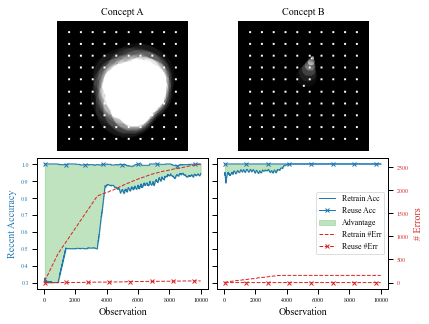

In [215]:

# Pickle can't be loaded in current env, see notes
# name = f"ff_res_*U5.pickle"
name = f"ff_res_*U5.json"
# print(data_location.resolve())
# print((data_location.resolve() / "ff_res_AU5.json").exists())
fns = list(data_location.glob(name))
print(fns)

fig, axs = plt.subplots(2, 2, sharey = 'row', figsize=get_plot_size(2, 1, 2, 1))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax2 = axs[1, 0].twinx()
ax3 = axs[1, 1].twinx()
secondary_axs = (ax2, ax3)
ax2.get_shared_y_axes().join(ax2, ax3)
# plt.rc('xtick',labelsize=5)
# plt.rc('ytick',labelsize=5)

for ci,fn in enumerate(fns):
    with open(fn, 'rb') as f:
        # result_obj = pickle.load(f)
        result_obj = json.load(f)
    results = result_obj['r']
    z = result_obj['z']
    # We don't store these elements in the JSON so we can serialize just data
    # reused = result_obj['p']
    # retrained = result_obj['l']

    # name_st = fn.stem[len(name.split('*')[0]):-1 * len(name.split('*')[1])]
    name_st = fn.stem.split("ff_res_")[1].split("U5")[0]
    print(name_st)
    # print(results)
    print(f"{name_st} num errors reuse: {results[-1][4]}")
    print(f"{name_st} num errors retrain: {results[-1][3]}")
    # axs[1, ci].plot([x[0] for x in results], [x[1] for x in results], label = "retrain", lw = 1, color = 'tab:blue', ls = 'dashed')
    axs[1, ci].plot([x[0] for x in results], [x[1] for x in results], label = "Retrain Acc", lw = 1, color = 'tab:blue')
    axs[1, ci].plot([x[0] for x in results], [x[2] for x in results], label = 'Reuse Acc', lw = 1, color = 'tab:blue', marker = 'x', markevery=0.1, markersize=4)
    axs[1, ci].fill_between([x[0] for x in results], [x[1] for x in results], [x[2] for x in results], alpha = 0.3, color = 'tab:green', label = "Advantage")
    # secondary_axs[ci].plot([x[0] for x in results], [x[3] for x in results], label = "retrain", lw = 1, color = 'tab:red', ls = 'dashed')
    secondary_axs[ci].plot([x[0] for x in results], [x[3] for x in results], label = "Retrain #Err", lw = 1, color = 'tab:red', ls = 'dashed')
    secondary_axs[ci].plot([x[0] for x in results], [x[4] for x in results], label = 'Reuse #Err', lw = 1, color = 'tab:red', ls = 'dashed', marker = 'x', markevery=0.1, markersize=4)
    secondary_axs[ci].tick_params(axis='y', labelcolor='tab:red')
    # secondary_axs[ci].tick_params(axis='x', labelsize = 7)
    axs[1, ci].tick_params(axis='y', labelcolor='tab:blue')
    # axs[1, ci].tick_params(axis='x', labelsize=7)
    # secondary_axs[ci].fill_between([x[0] for x in results], [x[3] for x in results], [x[4] for x in results], alpha = 0.3, color = 'green', label = "Advantage")
    
    axs[1, ci].set_xlabel("Observation")
    # axs[1, ci].set_title(f"Concept {name_st}")
    if ci == 0:
        axs[1, ci].set_ylabel("Recent Accuracy", color = 'tab:blue')
        secondary_axs[ci].set_yticks([])
    if ci == 1:
        # axs[1, ci].legend(loc = 'center right')
        h1, l1 = axs[1, ci].get_legend_handles_labels()
        h2, l2 = secondary_axs[ci].get_legend_handles_labels()
        axs[1, ci].legend(h1+h2, l1+l2, loc='center right', prop={'size': 8})
        secondary_axs[ci].set_ylabel('# Errors', color='tab:red')
        # axs[1, 1].set_yticks([])
    # axs[0, ci].set_title(name_st)
    axs[0, ci].imshow(z, cmap='gray', vmin = 0, vmax = 255)
    axs[0, ci].set_axis_off()
    axs[0, ci].title.set_text(f"Concept {name_st}")
# fig.suptitle("Concept A vs Concept B")
# fig.tight_layout()
# fig.subplots_adjust(top=0.88)
plt.savefig(output_location / f"{output_prefix}ff.pdf", bbox_inches='tight')
# plt.show()

### Casestudy

In [196]:
data_location = data_path / "Memory_Management" / "Casestudy"
data_location.exists()

True

In [199]:
def extract_matching_runs(data_location):
    """ Extracts all runs in the data location which have the same repository limit (cl).
    """
    same_cl_comparisons = {}

    filenames = list(data_location.glob('system*.csv'))

    #%%
    for csv_filename in filenames:
        file_parameters = mem_management_pattern_match_parameters(csv_filename)
        cl = file_parameters['cl']
        mm = file_parameters['mem_manage']
        if cl not in same_cl_comparisons:
            same_cl_comparisons[cl] = []
        same_cl_comparisons[cl].append((csv_filename, mm))
    return same_cl_comparisons



In [212]:
def plot_casestudy(concepts_of_interet):
    marker_size = 5.5
    text_y_offset = 0.02
    drift_data = get_drift_data(data_location)
    same_cl_comparisons = extract_matching_runs(data_location)
    for cl_i, cl in enumerate(same_cl_comparisons.keys()):
        comparisons = same_cl_comparisons[cl]
        # plt.figure(figsize=(20,5))
        # plt.figure(figsize=get_plot_size(2, 1, 2, 1))
        plt.figure(figsize=get_plot_size(1.25, 1, 1.25, 1, width_multiplier=1))
        line_colors = ["tab:red", "tab:green"]
        for ci, comparison in enumerate(comparisons):
            data = pd.read_csv(comparison[0])
            if 'ground_truth_concept' not in data.columns and not drift_data is None:
                if 'ex' in data.columns:
                    data.rename(columns={'ex': 'example'}, inplace=True)
                data = data.merge(drift_data, on = 'example', how = 'left')

                plotting_states = True
            state_id = 0

            sys_concept_position = 0.03 + 0.1 * (ci+1)


            # concepts_of_interet = [0]
            # concepts_of_interet = [0, 2]
            # concepts_of_interet = [0, 1, 2, 3]
            all_highlight = concepts_of_interet == [0, 1, 2, 3]
            show_ranges = []
            in_concept = None
            for i, row in data.iterrows():
                if int(row['ground_truth_concept']) in concepts_of_interet:
                    if in_concept is None:
                        show_ranges.append([i, None])
                        in_concept = int(row['ground_truth_concept'])
                if int(row['ground_truth_concept']) != in_concept:
                    if in_concept is not None:
                        show_ranges[-1][1] = i-1
                        in_concept = None
            if in_concept is not None:
                show_ranges[-1][1] = data.shape[0]

            if 'overall_accuracy' in data.columns:
                data['overall_accuracy'] = data['overall_accuracy']/100
                data['sliding_window_accuracy'] = data['sliding_window_accuracy']/100
                lag_row = pd.Series(dtype=np.float64)
                start_row = pd.Series(dtype=np.float64)
                for i, row in data.iterrows():
                    if 'ground_truth_concept' in start_row:
                        if row['ground_truth_concept'] != start_row['ground_truth_concept']:
                            # plt.plot([start_row['example'], row['example']], [0.03, 0.03], 
                            #     color = sns.color_palette()[int(start_row['ground_truth_concept']) % len(sns.color_palette())])
                            selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(row['example']) - x[1]) < 1000 for x in show_ranges])
                            plt.plot(data.iloc[int(start_row['example']):int(row['example'])]['example'], data.iloc[int(start_row['example']):int(row['example'])]['overall_accuracy'], linewidth = 1, color = line_colors[ci],  dashes= (5, 2), alpha = 1 if selected else 0.1, label = "_nolegend_")
                            plt.plot(data.iloc[int(start_row['example']):int(row['example'])]['example'], data.iloc[int(start_row['example']):int(row['example'])]['sliding_window_accuracy'], linewidth = 1, color = line_colors[ci], alpha = 1 if selected else 0.1, label = "_nolegend_")
                                
                            lag_row = start_row
                            start_row = row
                    else:
                        lag_row = start_row
                        start_row = row
                last_example_estimate = data['example'].iloc[-1] + (data['example'].iloc[-1] - data['example'].iloc[-2])
                selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(last_example_estimate) - x[1]) < 1000 for x in show_ranges])
                plt.plot(data.iloc[int(start_row['example']):int(last_example_estimate)]['example'], data.iloc[int(start_row['example']):int(last_example_estimate)]['overall_accuracy'], linewidth = 1, color = line_colors[ci],  dashes= (5, 2), label = f"{rename_strategies[comparison[1]]} Overall Accuracy", alpha = 1 if selected else 0.1)
                plt.plot(data.iloc[int(start_row['example']):int(last_example_estimate)]['example'], data.iloc[int(start_row['example']):int(last_example_estimate)]['sliding_window_accuracy'], linewidth = 1, color = line_colors[ci], label = f"{rename_strategies[comparison[1]]} Sliding Window Accuracy", alpha = 1 if selected else 0.1)
                # plt.plot([start_row['example'], last_example_estimate], [0.03, 0.03], 
                #                 color = sns.color_palette()[int(start_row['ground_truth_concept']) % len(sns.color_palette())])  


                # plt.plot(data['example'], data['overall_accuracy'], linewidth = 1, color = line_colors[ci], marker = 'o' if ci > 0 else 'x', markevery = 0.05,  dashes= (5, 2), label = f"{comparison[1]} Overall Accuracy")
                # plt.plot(data['example'], data['sliding_window_accuracy'], linewidth = 1, color = line_colors[ci], marker = 'o' if ci > 0 else 'x', markevery = 0.05, label = f"{comparison[1]} Sliding Window Accuracy")
                # sns.lineplot(x='example', y='overall_accuracy',
                #         linewidth=1, data=data,
                #         color = line_colors[ci],
                #         marker= 'o' if ci > 0 else None,
                #         dashes= "-",
                #         legend=None)
                # sns.lineplot(x='example', y='sliding_window_accuracy',
                #         linewidth=1, data=data,
                #         color = line_colors[ci],
                #         markers= True if ci > 0 else False,
                #         legend=None)
            # if 'change_detected' in data.columns:
            #     # Plot the change detections in green
            #     for i, row in data[data['change_detected'] != 0].iterrows():
            #         plt.plot([row['example'], row['example']], [sys_concept_position - 0.02, sys_concept_position + 0.02], color = "green")

            if 'ground_truth_concept' in data.columns and ci == 0:
                lag_row = pd.Series(dtype=np.float64)
                start_row = pd.Series(dtype=np.float64)
                for i, row in data.iterrows():
                    if 'ground_truth_concept' in start_row:
                        if row['ground_truth_concept'] != start_row['ground_truth_concept']:
                            selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(row['example']) - x[1]) < 1000 for x in show_ranges])
                            plt.plot([start_row['example'], row['example']], [0.03, 0.03], 
                                color = sns.color_palette()[int(start_row['ground_truth_concept']) % len(sns.color_palette())], alpha = 1 if selected else 0.1, linewidth = 2)
                                
                            lag_row = start_row
                            start_row = row
                    else:
                        lag_row = start_row
                        start_row = row
                last_example_estimate = data['example'].iloc[-1] + (data['example'].iloc[-1] - data['example'].iloc[-2])
                selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(last_example_estimate) - x[1]) < 1000 for x in show_ranges])
                plt.plot([start_row['example'], last_example_estimate], [0.03, 0.03], 
                                color = sns.color_palette()[int(start_row['ground_truth_concept']) % len(sns.color_palette())], alpha = 1 if selected else 0.1, linewidth = 2)
                # plt.text(last_example_estimate  * 1.005, 0.03, f"Context")
                plt.text(-1, 0.03 + text_y_offset, f"Context", ha='center', fontsize=MEDIUM_SIZE)

                lag_row = pd.Series(dtype=np.float64)
                start_row = pd.Series(dtype=np.float64)
                for i, row in data.iterrows():
                    if 'ground_truth_concept' in start_row:
                        if row['ground_truth_concept'] != start_row['ground_truth_concept']:
                            x = (row['example'] - start_row['example']) / 2 + start_row['example']
                            selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(row['example']) - x[1]) < 1000 for x in show_ranges])
                            plt.plot(x, 0.03, 'o', color='white', markersize=marker_size*1.3, alpha = 1 if selected else 0.1)
                            plt.plot(x, 0.03, marker=f"${list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')[int(start_row['ground_truth_concept'])]}$", color=sns.color_palette()[int(start_row['ground_truth_concept']) % len(sns.color_palette())], markersize=marker_size, alpha = 1 if selected else 0.1)
                                
                            lag_row = start_row
                            start_row = row
                    else:
                        lag_row = start_row
                        start_row = row
                last_example_estimate = data['example'].iloc[-1] + (data['example'].iloc[-1] - data['example'].iloc[-2]) 
                x = (last_example_estimate - start_row['example']) / 2 + start_row['example']
                selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(last_example_estimate) - x[1]) < 1000 for x in show_ranges])
                plt.plot(x, 0.03, 'o', color='white', markersize=marker_size*1.3, alpha = 1 if selected else 0.1)
                plt.plot(x, 0.03,  marker=f"${list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')[int(start_row['ground_truth_concept'])]}$", color=sns.color_palette()[int(start_row['ground_truth_concept']) % len(sns.color_palette())], markersize=marker_size, alpha = 1 if selected else 0.1)   


            if 'model_update' in data.columns:
                # Plot model updates (hoeffding tree splits)
                for row in data[data['model_update'] != 0]:
                    plt.plot([row['example'], row['example']], [0.5, 0.7])

            if 'drift_occured' in data.columns:
                # Plot model updates (hoeffding tree splits)
                for i,row in data.iloc[1:][data['drift_occured'] != 0].iterrows():
                    selected = all_highlight or (int(row['example']) in show_ranges and int(row['example']) + 500 in show_ranges)
                    plt.plot([row['example'], row['example']], [0.01, 0.05], color="Black", alpha = 1 if selected else 0.1, linewidth=0.5)  

            if 'system_concept' in data.columns:
                lag_row = pd.Series(dtype=np.float64)
                start_row = pd.Series(dtype=np.float64)
                for i, row in data.iterrows():
                    if 'system_concept' in start_row:
                        if row['system_concept'] != start_row['system_concept']:
                            selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(row['example']) - x[1]) < 1000 for x in show_ranges])
                            plt.plot([start_row['example'], row['example']], [sys_concept_position, sys_concept_position], 
                                color = sns.color_palette()[int(start_row['system_concept']) % len(sns.color_palette())], alpha = 1 if selected else 0.1, linewidth = 2)
                            
                            
                            lag_row = start_row
                            start_row = row
                    else:
                        lag_row = start_row
                        start_row = row
                last_example_estimate = data['example'].iloc[-1] + (data['example'].iloc[-1] - data['example'].iloc[-2])
                selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(last_example_estimate) - x[1]) < 1000 for x in show_ranges])
                plt.plot([start_row['example'], last_example_estimate], [sys_concept_position, sys_concept_position], 
                                color = sns.color_palette()[int(start_row['system_concept']) % len(sns.color_palette())], alpha = 1 if selected else 0.1, linewidth = 2)  
            if 'system_concept' in data.columns:
                lag_row = pd.Series(dtype=np.float64)
                start_row = pd.Series(dtype=np.float64)
                for i, row in data.iterrows():
                    if 'system_concept' in start_row:
                        if row['system_concept'] != start_row['system_concept']:
                            x = (row['example'] - start_row['example']) / 2 + start_row['example']
                            selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(row['example']) - x[1]) < 1000 for x in show_ranges])
                            plt.plot(x, sys_concept_position, 'o', color='white', markersize=marker_size*1.3, alpha = 1 if selected else 0.1)
                            plt.plot(x, sys_concept_position, marker=f"${int(start_row['system_concept'])}$", color=sns.color_palette()[int(start_row['system_concept']) % len(sns.color_palette())],
                        markersize=marker_size, alpha = 1 if selected else 0.1)
                            plt.plot([row['example'], row['example']], [sys_concept_position - 0.02, sys_concept_position + 0.02], color = "black", linewidth = 0.5, alpha = 1 if selected else 0.1)
                            lag_row = start_row
                            start_row = row
                    else:
                        lag_row = start_row
                        start_row = row
                last_example_estimate = data['example'].iloc[-1] + (data['example'].iloc[-1] - data['example'].iloc[-2])
                x = (last_example_estimate - start_row['example']) / 2 + start_row['example']
                selected = all_highlight or any([abs(int(start_row['example']) - x[0]) < 1000 for x in show_ranges]) or any([abs(int(last_example_estimate) - x[1]) < 1000 for x in show_ranges])
                plt.plot(x, sys_concept_position, 'o', color='white', markersize=marker_size*1.3, alpha = 1 if selected else 0.1)
                plt.plot(x, sys_concept_position, marker=f"${int(start_row['system_concept'])}$", color=sns.color_palette()[int(start_row['system_concept']) % len(sns.color_palette())], markersize=marker_size, alpha = 1 if selected else 0.1)
                # plt.text(last_example_estimate * 1.005, sys_concept_position, f"{rename_strategies[comparison[1]]}")
                plt.text(-1, sys_concept_position+text_y_offset, f"{rename_strategies[comparison[1]]}", ha='center', fontsize=MEDIUM_SIZE)

        # plt.legend(bbox_to_anchor=(1, 1.005), loc=2, borderaxespad=0.)
        leg = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=4, frameon=False)
        for l in leg.get_lines():
            l.set_alpha(1)
        plt.xlabel("# Observations")
        plt.ylabel("Accuracy")
        plt.tight_layout()
        plt.savefig(output_location / f"{output_prefix}-CS-{cl}-{'_'.join([str(c) for c in concepts_of_interet])}.pdf")
        plt.clf()



In [213]:
plot_casestudy([0])
plot_casestudy([0, 2])
plot_casestudy([0, 1, 2, 3])

C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/1814847344.py:139: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in data.iloc[1:][data['drift_occured'] != 0].iterrows():
C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/1814847344.py:139: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in data.iloc[1:][data['drift_occured'] != 0].iterrows():
C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/1814847344.py:139: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in data.iloc[1:][data['drift_occured'] != 0].iterrows():
C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/1814847344.py:139: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in data.iloc[1:][data['drift_occured'] != 0].iterrows():
C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/1814847344.py:139: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,r

<Figure size 453.543x216.142 with 0 Axes>

<Figure size 453.543x216.142 with 0 Axes>

<Figure size 453.543x216.142 with 0 Axes>

<Figure size 453.543x216.142 with 0 Axes>

<Figure size 453.543x216.142 with 0 Axes>

<Figure size 453.543x216.142 with 0 Axes>

### Parameters - Noise

In [191]:
data_location = data_path / "Memory_Management" / "Parameters" / "noise"
data_location.exists()

True

In [192]:
# GET DATA
df = subdir_run(data_location, None, True, produce_table=True)
df = df[df['sys_learner'] == "HN"]
print(df.shape)
df.head()

(133, 126)


Unnamed: 0  accuracy  drift_accuracy_50  drift_km_50  drift_kt_50  \
0           0  82.56130           0.527524    -0.044748    -0.065500   
1           1  79.35565           0.528573    -0.042430    -0.063135   
2           2  79.44290           0.522334    -0.048085    -0.057697   
3           3  77.24850           0.526738    -0.043343    -0.048919   
4           4  77.56065           0.517773    -0.051320    -0.059922   

   drift_accuracy_100  drift_km_100  drift_kt_100  drift_accuracy_250  \
0            0.542384     -0.013366     -0.027339            0.607442   
1            0.543707     -0.010435     -0.024367            0.590270   
2            0.530232     -0.034634     -0.040640            0.590068   
3            0.529835     -0.035810     -0.038961            0.575655   
4            0.524673     -0.038101     -0.042320            0.579596   

   drift_km_250  ...  seed  sens  window  sys_learner  poisson     od  sm  \
0      0.127890  ...  2165  0.05     175           HN       10  False  KT   
1      0.089741  ...  2165  0.05     175           HN       10  False  KT   
2      0.095669  ...  2165  0.05     175           HN       10  False  KT   
3      0.062728  ...  2165  0.05     175           HN       10  False  KT   
4      0.077770  ...  2165  0.05     175           HN       10  False  KT   

     merge  run_noise  merge_similarity  
0  acc.csv       0.00               0.9  
1  acc.csv       0.00               0.9  
2  acc.csv       0.05               0.9  
3  acc.csv       0.05               0.9  
4  acc.csv       0.10               0.9  

[5 rows x 126 columns]

In [193]:
metric = "accuracy"
iv = "run_noise"
# ttestvar = None
ttestvar = "mem_manage"
save_name = f"{iv}-{metric.replace(' ', '')}"

In [73]:
# GET TABLE
df_t = df.groupby(["cl", "st", "mem_manage", "seed", "drift_window", "poisson", "sens", "sys_learner", "run_noise", "ml"]).aggregate([(metric, 'mean')])
df_t.columns = df_t.columns.droplevel(1)
df_table = df_t.unstack(level = iv)
df_table = df_table.rename(index = {'def': '0'}, level = 'poisson')
df_table = df_table.rename(index = {'def': 'arf'}, level = 'mem_manage')
df_table = df_table.rename(index = {'arf': 'ARF'}, level = 'mem_manage')
df_table = df_table.rename(index = {'rA': '# Evolutions'}, level = 'mem_manage')
df_table = df_table.rename(index = {'RCStreamType-RBF': 'RBF'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-TREE': 'TREE'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-WINDSIM': 'WINDSIM'}, level = 'st')

df_table = df_table[metric]
try:
    noise_levels = sorted(list(df_table.columns), key = lambda x: float(x))
except:
    noise_levels = df_table.columns
    print("cant sort")
print(noise_levels)


for c_i, c in enumerate(noise_levels[1:], start = 1):
    n0 = noise_levels[c_i - 1]
    n1 = noise_levels[c_i]
    colname = f"{n0} -\> {n1}"
    col = df_table.loc[:, n1] / df_table.loc[:, n0]
    df_table[colname] = col

df_table = df_table.dropna()

#     # df_table_val[colname] = df_table_val.loc[:, n0] - df_table_val.loc[:, n1]
# # df_table = df_table.groupby(level=['poisson', 'st', 'ml', 'sys_learner',  'mem_manage',]).aggregate([('Mean (STD)', custom_mean)])


df_table_ttest = df_table.groupby(level=['st']).aggregate([ custom_ttest_index(ttestvar) if not ttestvar is None else series_ttest])
# df_table_ttest
# df_table_ttest
df_table = df_table.groupby(level=['st', 'mem_manage',]).aggregate([('Mean (STD)', lambda x: parenthesis_mean_stdev(x, 4, 2))])
df_table

# print(df_table)
# df_table = df_table.loc[df_table.index.get_level_values(1) != 'arf']
# df_table = df_table.loc[df_table.index.get_level_values(1) != 'rAAuc']



# print(df_table)



# print(df_table)
# df_table.columns.droplevel(1)
# print(df_table)
# df_table.index.names = [x if x != 'st' else 'Stream Source' for x in df_table.index.names]
# df_table.index.names = [x if x != 'mem_manage' else 'Memory Management Strategy' for x in df_table.index.names]
# print(df_table)




# print(df_table)
# print(df_table_ttest)

# # print(df_table.xs('mean', axis = 1, level = 1, drop_level = False))
# # print(df_table.xs('std', axis = 1, level = 1, drop_level = False))
# # print(df_table.xs('mean', axis = 1, level = 1, drop_level = False).map(str) + df_table.xs('std', axis = 1, level = 1, drop_level = False).map(str))
# # df_table.loc['mean'] = df_table.xs('mean', axis = 1, level = 1, drop_level = False) + df_table.xs('std', axis = 1, level = 1, drop_level = False)
# with open(f'Mem_Manage_Results/{save_name}_{iv}_plot_bw.txt', 'w') as f:
#     print(df_table)
#     df_table.to_latex(f)
# with open(f'Mem_Manage_Results/{save_name}_{iv}_ttest_plot_bw.txt', 'w') as f:
#     print(df_table_ttest)
#     df_table_ttest.to_latex(f)

[0.0, 0.05, 0.1]


run_noise                      0.0          0.05           0.1  \
                        Mean (STD)    Mean (STD)    Mean (STD)   
st      mem_manage                                               
RBF     # Evolutions   90.2 (0.13)  87.69 (0.33)  85.23 (0.19)   
        LRU           88.87 (0.21)  86.46 (0.21)  84.13 (0.28)   
TREE    # Evolutions   81.3 (0.88)   78.15 (1.1)   75.56 (1.0)   
        LRU            77.59 (1.1)   75.31 (1.2)   72.96 (1.2)   
WINDSIM # Evolutions   89.48 (1.4)   87.34 (1.3)   85.09 (1.3)   
        LRU            89.31 (1.4)   86.94 (1.4)   84.79 (1.2)   

run_noise                 0.0 -\> 0.05     0.05 -\> 0.1  
                            Mean (STD)       Mean (STD)  
st      mem_manage                                       
RBF     # Evolutions    0.9722 (0.003)  0.9719 (0.0032)  
        LRU            0.9729 (0.0012)   0.973 (0.0019)  
TREE    # Evolutions    0.9613 (0.012)   0.9669 (0.011)  
        LRU            0.9705 (0.0042)  0.9689 (0.0045)  
WINDSIM # Evolutions   0.9761 (0.0022)  0.9742 (0.0018)  
        LRU           0.9735 (0.00085)   0.9753 (0.003)

RCStreamType-RBF
RCStreamType-TREE
RCStreamType-WINDSIM
RCStreamType-RBF
RCStreamType-TREE
RCStreamType-WINDSIM
[<matplotlib.lines.Line2D object at 0x0000014A049D25E0>] [<matplotlib.lines.Line2D object at 0x0000014A049D2460>] ['#E'] ['LRU']


C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/742716941.py:156: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig_leg.tight_layout()


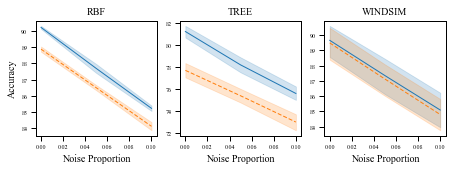

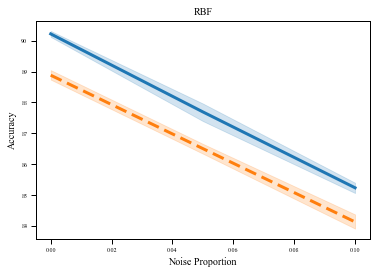

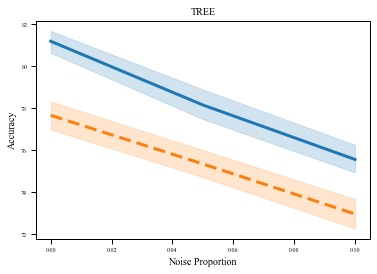

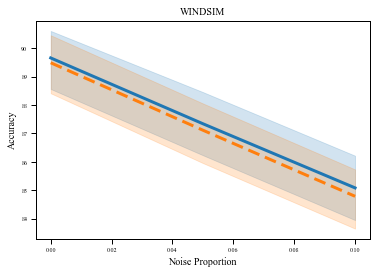

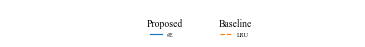

In [195]:
# MAKE PLOTS
def plot_graph(data, poisson_labels, ax, show_legend = True, st = "Default"):
    # cmap = plt.get_cmap('viridis')
    # indices = np.linspace(25, cmap.N-25, 2)
    # my_colors = random.shuffle([cmap(int(i)) for i in indices])

    g = sns.lineplot(x=iv, y=metric, estimator = 'mean', err_style = 'band', ax=ax,
    # linewidth=1, data=data, hue='mem_manage', hue_order=['score', 'rA', 'auc', 'rAAuc', 'arf', 'rcd', 'age', 'LRU', 'acc', 'div'], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'], units = "poisson", estimator=None)
    linewidth=1, data=data, hue='mem_manage', hue_order=['rA', 'LRU'], dashes=["", (4, 2), (4, 2)], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'])

    if show_legend:
        h, l = g.get_legend_handles_labels()
        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", 'arf': 'ARF'}
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]


        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        # box = g.get_position()
        # g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # ours = ax.legend(h_ours, l_ours, 
        #                     fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        # theirs = ax.legend(h_theirs, l_theirs, 
        #                     fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        # ax.add_artist(ours)
        l = ax.legend()
        l.remove()
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel(metric_replace[iv] if iv in metric_replace else iv)
    ax.set_ylabel(metric_replace[metric] if metric in metric_replace else metric)
def plot_graph_minimal(data, poisson_labels, ax, show_legend = True, st = "Default", m = 'accuracy'):
    # cmap = plt.get_cmap('viridis')
    # indices = np.linspace(25, cmap.N-25, 2)
    # my_colors = random.shuffle([cmap(int(i)) for i in indices])
    g = sns.lineplot(x=iv, y=metric, estimator = 'mean', err_style = 'band', ax=ax,
    # linewidth=1, data=data, hue='mem_manage', hue_order=['score', 'rA', 'auc', 'rAAuc', 'arf', 'rcd', 'age', 'LRU', 'acc', 'div'], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'], units = "poisson", estimator=None)
    linewidth=3,  data=data, hue='mem_manage', hue_order=['rA', 'LRU'], sort=True, dashes=["", (4, 2), (4, 2)], style= 'creator', style_order= ['mine', 'theirs', 'base'])

    if show_legend or True:
        h, l = g.get_legend_handles_labels()
        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", 'arf': 'ARF'}
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]


        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        # box = g.get_position()
        # g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # ours = ax.legend(h_ours, l_ours, 
        #                     fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        # theirs = ax.legend(h_theirs, l_theirs, 
        #                     fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        # ax.add_artist(ours)
        l = ax.legend()
        l.remove()
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel(metric_replace[iv] if iv in metric_replace else iv)
    ax.set_ylabel(metric_replace[metric] if metric in metric_replace else metric)
    
    return h_ours, h_theirs, l_ours, l_theirs

overall = df
overall['creator'] = overall['mem_manage'].map(lambda x: "theirs" if x in ['acc', 'age', 'LRU', 'div'] else 'base' if x in ['arf', 'rcd'] else 'mine')
unique_stream_types = sorted(overall['st'].unique())
# unique_stream_types = unique_stream_types[:2]
# fig, axs = plt.subplots(1, len(unique_stream_types), sharey=True, figsize = (20,5))
# fig, axs = plt.subplots(1, len(unique_stream_types), figsize = (20,5))
fig, axs = plt.subplots(1, len(unique_stream_types), figsize = get_plot_size(1, 1, 1, 1))
if len(unique_stream_types) < 2:
    axs = [axs]

for st_i, st in enumerate(unique_stream_types):
    print(st)
    df_st = overall.loc[overall['st'] == st]
    # print(df_st.sample(5))
    plot_graph(df_st, [], axs[st_i], st_i == len(unique_stream_types) - 1, st)
    if st_i > 0:
        axs[st_i].get_yaxis().label.set_visible(False)

for st_i, st in enumerate(unique_stream_types):
    # m_savename = f"{args['file'].split('.')[0]}-{[x.replace(' ', '') for x in ['accuracy']]}"
    min_fig = plt.figure()
    ax = min_fig.gca()
    try:
        st_name = unique_stream_types[st_i].split('-')[1]
    except:
        st_name = unique_stream_types[st_i]

    # Save just the portion _inside_ the second axis's boundaries
    print(st)
    df_st = overall.loc[overall['st'] == st]

    h_ours, h_theirs, l_ours, l_theirs = plot_graph_minimal(df_st, [], ax, False, st, 'accuracy')
    # min_fig.savefig(f'Mem_Manage_Results/{m_savename}{st_name}_figure_bw.png', bbox_inches='tight')


pic_suffix = ""
# pic_suffix = "ss"
fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-P-Noise-{save_name}{pic_suffix}_{iv}_bw.pdf", bbox_inches='tight')

# figsize = (3, 0.1)
# figsize=get_plot_size(0.2, 1, 0.2, 1)
figsize = get_plot_size(0.15, 1, 0.15, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)


print(h_ours, h_theirs, l_ours, l_theirs)
ours = ax_leg.legend(h_ours, l_ours, 
                    fancybox=True, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0.4, 0, 0.1, 0.1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
# ours.get_title().set_fontsize('14')
theirs = ax_leg.legend(h_theirs, l_theirs, 
                    fancybox=True, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.6, 0, 0.1, 0.1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
# theirs.get_title().set_fontsize('14')
# ours = m_fig.legend(h_ours, l_ours, 
#                     fancybox=True, ncol=len(h_ours), title = "proposed", bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.1)
# theirs = m_fig.legend(h_theirs, l_theirs, 
#                     fancybox=True, ncol=len(h_theirs), title = "baselines", bbox_to_anchor=(1, 1.02), loc="lower right", borderaxespad=0.1)
ax_leg.add_artist(ours)
# add the legend from the previous axes
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.tight_layout()
fig_leg.savefig(output_location / f"{output_prefix}-P-DriftWindow-{save_name}_legend_bw.pdf", bbox_inches='tight', pad_inches=0)



plt.show()

### PARAMETERS - DRIFT WIDTH

In [12]:
data_location = data_path / "Memory_Management" / "Parameters" / "driftwindow" / "0.0"
# data_location = pathlib.Path(r"C:\driftwidth") / "0.0"
data_location.exists()

True

In [13]:
# GET DATA
df = subdir_run(data_location, None, True, produce_table=True)
df = df[df['sys_learner'] == "HN"]
print(df.shape)
df.head()

(87, 126)


Unnamed: 0  accuracy  drift_accuracy_50  drift_km_50  drift_kt_50  \
0           0  82.56130           0.527524    -0.044748    -0.065500   
1           1  79.31480           0.527105    -0.045676    -0.066446   
2           2  82.56130           0.527524    -0.044748    -0.065500   
3           3  78.88365           0.521705    -0.009852    -0.075065   
4           4  76.12660           0.513054    -0.028116    -0.094509   

   drift_accuracy_100  drift_km_100  drift_kt_100  drift_accuracy_250  \
0            0.542384     -0.013366     -0.027339            0.607442   
1            0.542701     -0.012663     -0.026625            0.591442   
2            0.542384     -0.013366     -0.027339            0.607442   
3            0.538121      0.025362     -0.037215            0.590558   
4            0.529121      0.006368     -0.057428            0.570339   

   drift_km_250  ...  seed  sens  window  sys_learner  poisson     od  sm  \
0      0.127890  ...  2165  0.05     175           HN       10  False  KT   
1      0.092344  ...  2165  0.05     175           HN       10  False  KT   
2      0.127890  ...  2165  0.05     175           HN       10  False  KT   
3      0.137471  ...  2199  0.05     175           HN       10  False  KT   
4      0.094879  ...  2199  0.05     175           HN       10  False  KT   

   merge  run_noise  merge_similarity  
0   both          0               0.9  
1   both          0               0.9  
2   both          0               0.9  
3   both          0               0.9  
4   both          0               0.9  

[5 rows x 126 columns]

In [185]:
metric = "accuracy"
iv = "drift_window"
# ttestvar = None
ttestvar = "mem_manage"
save_name = f"{iv}-{metric.replace(' ', '')}"

In [22]:
# GET TABLE
df_t = df.groupby(["cl", "st", "mem_manage", "drift_window", "poisson", "sens", "sys_learner", "run_noise", "ml"]).aggregate([(metric, 'mean')])
df_t.columns = df_t.columns.droplevel(1)
df_table = df_t.unstack(level = iv)
df_table = df_table.rename(index = {'def': '0'}, level = 'poisson')
df_table = df_table.rename(index = {'def': 'arf'}, level = 'mem_manage')
df_table = df_table.rename(index = {'arf': 'ARF'}, level = 'mem_manage')
df_table = df_table.rename(index = {'rA': '# Evolutions'}, level = 'mem_manage')
df_table = df_table.rename(index = {'RCStreamType-RBF': 'RBF'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-TREE': 'TREE'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-WINDSIM': 'WINDSIM'}, level = 'st')

df_table = df_table[metric]


try:
    noise_levels = sorted(list(df_table.columns), key = lambda x: float(x))
except:
    noise_levels = df_table.columns
    print("cant sort")
print(noise_levels)


for c_i, c in enumerate(noise_levels[1:], start = 1):
    n0 = noise_levels[c_i - 1]
    n1 = noise_levels[c_i]
    colname = f"{n0} -\> {n1}"
    col = df_table.loc[:, n1] / df_table.loc[:, n0]
    df_table[colname] = col

# df_table = df_table.dropna()
# df_table

#     # df_table_val[colname] = df_table_val.loc[:, n0] - df_table_val.loc[:, n1]
# # df_table = df_table.groupby(level=['poisson', 'st', 'ml', 'sys_learner',  'mem_manage',]).aggregate([('Mean (STD)', custom_mean)])


df_table_ttest = df_table.groupby(level=['st']).aggregate([ custom_ttest_index(ttestvar) if not ttestvar is None else series_ttest])
# df_table_ttest
df_table = df_table.groupby(level=['st', 'mem_manage',]).aggregate([('Mean (STD)', lambda x: parenthesis_mean_stdev(x, 4, 2))])
# df_table_ttest
df_table

# print(df_table)
# df_table = df_table.loc[df_table.index.get_level_values(1) != 'arf']
# df_table = df_table.loc[df_table.index.get_level_values(1) != 'rAAuc']



# print(df_table)



# print(df_table)
# df_table.columns.droplevel(1)
# print(df_table)
# df_table.index.names = [x if x != 'st' else 'Stream Source' for x in df_table.index.names]
# df_table.index.names = [x if x != 'mem_manage' else 'Memory Management Strategy' for x in df_table.index.names]
# print(df_table)




# print(df_table)
# print(df_table_ttest)

# # print(df_table.xs('mean', axis = 1, level = 1, drop_level = False))
# # print(df_table.xs('std', axis = 1, level = 1, drop_level = False))
# # print(df_table.xs('mean', axis = 1, level = 1, drop_level = False).map(str) + df_table.xs('std', axis = 1, level = 1, drop_level = False).map(str))
# # df_table.loc['mean'] = df_table.xs('mean', axis = 1, level = 1, drop_level = False) + df_table.xs('std', axis = 1, level = 1, drop_level = False)
# with open(f'Mem_Manage_Results/{save_name}_{iv}_plot_bw.txt', 'w') as f:
#     print(df_table)
#     df_table.to_latex(f)
# with open(f'Mem_Manage_Results/{save_name}_{iv}_ttest_plot_bw.txt', 'w') as f:
#     print(df_table_ttest)
#     df_table_ttest.to_latex(f)

[0, 500, 1000]


C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


drift_window                    0          500         1000     0 -\> 500  \
                       Mean (STD)   Mean (STD)   Mean (STD)    Mean (STD)   
st      mem_manage                                                          
RBF     # Evolutions   89.8 (0.0)  90.64 (0.0)  89.21 (0.0)   1.009 (0.0)   
        LRU           88.68 (0.0)  88.91 (0.0)   87.9 (0.0)   1.003 (0.0)   
TREE    # Evolutions  80.77 (0.0)  80.88 (0.0)  78.68 (0.0)   1.001 (0.0)   
        LRU           77.31 (0.0)  76.09 (0.0)  74.74 (0.0)  0.9843 (0.0)   
WINDSIM # Evolutions  89.61 (0.0)  99.97 (0.0)    nan (nan)   1.116 (0.0)   
        LRU           89.27 (0.0)  99.97 (0.0)    nan (nan)    1.12 (0.0)   

drift_window          500 -\> 1000  
                        Mean (STD)  
st      mem_manage                  
RBF     # Evolutions  0.9842 (0.0)  
        LRU           0.9887 (0.0)  
TREE    # Evolutions  0.9728 (0.0)  
        LRU           0.9822 (0.0)  
WINDSIM # Evolutions     nan (nan)  
        LRU              nan (nan)

RCStreamType-RBF
RCStreamType-TREE
RCStreamType-RBF
RCStreamType-TREE
[<matplotlib.lines.Line2D object at 0x0000014A04EFDD60>] [<matplotlib.lines.Line2D object at 0x0000014A09B34C40>] ['#E'] ['LRU']


C:\Users\Ben\AppData\Local\Temp/ipykernel_61632/959680236.py:156: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig_leg.tight_layout()


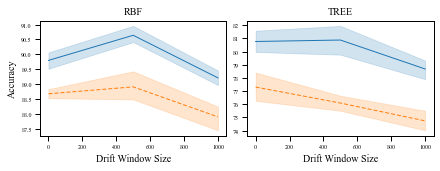

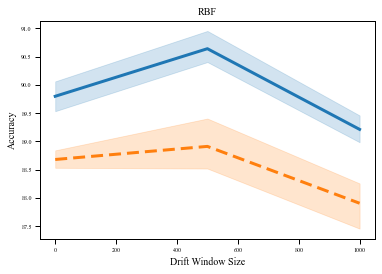

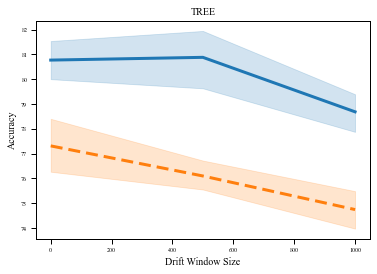

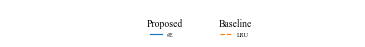

In [190]:
# MAKE PLOTS
def plot_graph(data, poisson_labels, ax, show_legend = True, st = "Default"):
    # cmap = plt.get_cmap('viridis')
    # indices = np.linspace(25, cmap.N-25, 2)
    # my_colors = random.shuffle([cmap(int(i)) for i in indices])

    g = sns.lineplot(x=iv, y=metric, estimator = 'mean', err_style = 'band', ax=ax,
    # linewidth=1, data=data, hue='mem_manage', hue_order=['score', 'rA', 'auc', 'rAAuc', 'arf', 'rcd', 'age', 'LRU', 'acc', 'div'], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'], units = "poisson", estimator=None)
    linewidth=1, data=data, hue='mem_manage', hue_order=['rA', 'LRU'], dashes=["", (4, 2), (4, 2)], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'])

    if show_legend:
        h, l = g.get_legend_handles_labels()
        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", 'arf': 'ARF'}
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]


        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        # box = g.get_position()
        # g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # ours = ax.legend(h_ours, l_ours, 
        #                     fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        # theirs = ax.legend(h_theirs, l_theirs, 
        #                     fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        # ax.add_artist(ours)
        l = ax.legend()
        l.remove()
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel(metric_replace[iv] if iv in metric_replace else iv)
    ax.set_ylabel(metric_replace[metric] if metric in metric_replace else metric)
def plot_graph_minimal(data, poisson_labels, ax, show_legend = True, st = "Default", m = 'accuracy'):
    # cmap = plt.get_cmap('viridis')
    # indices = np.linspace(25, cmap.N-25, 2)
    # my_colors = random.shuffle([cmap(int(i)) for i in indices])
    g = sns.lineplot(x=iv, y=metric, estimator = 'mean', err_style = 'band', ax=ax,
    # linewidth=1, data=data, hue='mem_manage', hue_order=['score', 'rA', 'auc', 'rAAuc', 'arf', 'rcd', 'age', 'LRU', 'acc', 'div'], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'], units = "poisson", estimator=None)
    linewidth=3,  data=data, hue='mem_manage', hue_order=['rA', 'LRU'], sort=True, dashes=["", (4, 2), (4, 2)], style= 'creator', style_order= ['mine', 'theirs', 'base'])

    if show_legend or True:
        h, l = g.get_legend_handles_labels()
        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", 'arf': 'ARF'}
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]


        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        # box = g.get_position()
        # g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # ours = ax.legend(h_ours, l_ours, 
        #                     fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        # theirs = ax.legend(h_theirs, l_theirs, 
        #                     fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        # ax.add_artist(ours)
        l = ax.legend()
        l.remove()
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel(metric_replace[iv] if iv in metric_replace else iv)
    ax.set_ylabel(metric_replace[metric] if metric in metric_replace else metric)
    
    return h_ours, h_theirs, l_ours, l_theirs

overall = df
overall['creator'] = overall['mem_manage'].map(lambda x: "theirs" if x in ['acc', 'age', 'LRU', 'div'] else 'base' if x in ['arf', 'rcd'] else 'mine')
unique_stream_types = sorted(overall['st'].unique())[:2]
# unique_stream_types = unique_stream_types[:2]
# fig, axs = plt.subplots(1, len(unique_stream_types), sharey=True, figsize = (20,5))
# fig, axs = plt.subplots(1, len(unique_stream_types), figsize = (20,5))
fig, axs = plt.subplots(1, len(unique_stream_types), figsize = get_plot_size(1, 2, 1, 2))
if len(unique_stream_types) < 2:
    axs = [axs]

for st_i, st in enumerate(unique_stream_types):
    print(st)
    df_st = overall.loc[overall['st'] == st]
    # print(df_st.sample(5))
    plot_graph(df_st, [], axs[st_i], st_i == len(unique_stream_types) - 1, st)
    if st_i > 0:
        axs[st_i].get_yaxis().label.set_visible(False)

for st_i, st in enumerate(unique_stream_types):
    # m_savename = f"{args['file'].split('.')[0]}-{[x.replace(' ', '') for x in ['accuracy']]}"
    min_fig = plt.figure()
    ax = min_fig.gca()
    try:
        st_name = unique_stream_types[st_i].split('-')[1]
    except:
        st_name = unique_stream_types[st_i]

    # Save just the portion _inside_ the second axis's boundaries
    print(st)
    df_st = overall.loc[overall['st'] == st]

    h_ours, h_theirs, l_ours, l_theirs = plot_graph_minimal(df_st, [], ax, False, st, 'accuracy')
    # min_fig.savefig(f'Mem_Manage_Results/{m_savename}{st_name}_figure_bw.png', bbox_inches='tight')


pic_suffix = ""
# pic_suffix = "ss"
fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-P-DriftWindow-{save_name}{pic_suffix}_{iv}_bw.pdf", bbox_inches='tight')

# figsize = (3, 0.1)
# figsize=get_plot_size(0.2, 1, 0.2, 1)
figsize = get_plot_size(0.15, 1, 0.15, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)


print(h_ours, h_theirs, l_ours, l_theirs)
ours = ax_leg.legend(h_ours, l_ours, 
                    fancybox=True, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0.4, 0, 0.1, 0.1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
# ours.get_title().set_fontsize('14')
theirs = ax_leg.legend(h_theirs, l_theirs, 
                    fancybox=True, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.6, 0, 0.1, 0.1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
# theirs.get_title().set_fontsize('14')
# ours = m_fig.legend(h_ours, l_ours, 
#                     fancybox=True, ncol=len(h_ours), title = "proposed", bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.1)
# theirs = m_fig.legend(h_theirs, l_theirs, 
#                     fancybox=True, ncol=len(h_theirs), title = "baselines", bbox_to_anchor=(1, 1.02), loc="lower right", borderaxespad=0.1)
ax_leg.add_artist(ours)
# add the legend from the previous axes
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.tight_layout()
fig_leg.savefig(output_location / f"{output_prefix}-P-DriftWindow-{save_name}_legend_bw.pdf", bbox_inches='tight', pad_inches=0)



plt.show()

### PARAMETERS - FILTER THRESHOLD

In [7]:
data_location = data_path / "Memory_Management" / "Parameters" / "filterthreshold"
data_location.exists()

True

In [8]:

# with (data_location / "json_strategies.json").open('r') as f:
with (data_location / "diff_t_results.json").open('r') as f:
    strategies = json.load(f)

strategies

[{'name': 't0', 'val': 0.0, 'right': 4287, 'wrong': 713},
 {'name': 't5', 'val': 0.05, 'right': 4287, 'wrong': 713},
 {'name': 't10', 'val': 0.1, 'right': 4287, 'wrong': 713},
 {'name': 't15', 'val': 0.15, 'right': 4287, 'wrong': 713},
 {'name': 't20', 'val': 0.2, 'right': 4287, 'wrong': 713},
 {'name': 't25', 'val': 0.25, 'right': 4287, 'wrong': 713},
 {'name': 't30', 'val': 0.3, 'right': 4287, 'wrong': 713},
 {'name': 't35', 'val': 0.35, 'right': 4287, 'wrong': 713},
 {'name': 't40', 'val': 0.4, 'right': 4287, 'wrong': 713},
 {'name': 't45', 'val': 0.45, 'right': 4287, 'wrong': 713},
 {'name': 't50', 'val': 0.5, 'right': 4287, 'wrong': 713},
 {'name': 't55', 'val': 0.55, 'right': 4287, 'wrong': 713},
 {'name': 't60', 'val': 0.6, 'right': 4287, 'wrong': 713},
 {'name': 't65', 'val': 0.65, 'right': 4287, 'wrong': 713},
 {'name': 't70', 'val': 0.7, 'right': 4290, 'wrong': 710},
 {'name': 't75', 'val': 0.75, 'right': 4333, 'wrong': 667},
 {'name': 't80', 'val': 0.8, 'right': 4494, 'wrong

C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/3821110347.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


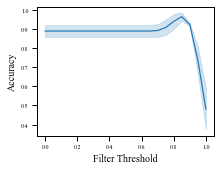

In [9]:
strat_results = []
for strategy in strategies:
    strat_results.append((strategy['val'], strategy['right'] / (strategy['right'] + strategy['wrong'])))
fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
sns.lineplot(x = [x[0] for x in strat_results], y = [x[1] for x in strat_results], ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Filter Threshold")
# plt.title("Filter Threshold sensitivity")
fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-DiffThreshold_eb.pdf", bbox_inches="tight")
fig.show()

### PARAMETERS - MERGE SIMILARITY

In [10]:
data_location = data_path / "Memory_Management" / "Parameters" / "MergeSim"
# data_location = pathlib.Path(r"C:\MergeSim")
data_location.exists()

True

In [11]:
df = subdir_run(data_location, None, True, produce_table=True)
df = df[df['sys_learner'] == "HN"]
print(df.shape)
df.head()

(50, 126)


Unnamed: 0  accuracy  drift_accuracy_50  drift_km_50  drift_kt_50  \
0           0  89.79735           0.583622     0.078547     0.150679   
1           1  90.27580           0.586295     0.084465     0.156133   
2           2  90.30055           0.589284     0.091078     0.162229   
3           3  90.06640           0.581262     0.073326     0.145867   
4           4  90.31860           0.585299     0.082260     0.154101   

   drift_accuracy_100  drift_km_100  drift_kt_100  drift_accuracy_250  \
0            0.620824      0.165180      0.219157            0.715012   
1            0.627072      0.178936      0.232023            0.729393   
2            0.625721      0.175963      0.229243            0.725536   
3            0.620559      0.164598      0.218612            0.718090   
4            0.624107      0.172408      0.225917            0.722362   

   drift_km_250  ...  seed  sens  window  sys_learner  poisson     od  sm  \
0      0.372319  ...   320  0.05     175           HN       10  False  KT   
1      0.403993  ...   320  0.05     175           HN       10  False  KT   
2      0.395500  ...   320  0.05     175           HN       10  False  KT   
3      0.379100  ...   320  0.05     175           HN       10  False  KT   
4      0.388508  ...   320  0.05     175           HN       10  False  KT   

   merge  run_noise  merge_similarity  
0   both          0               0.5  
1   both          0               0.6  
2   both          0               0.9  
3   both          0               0.2  
4   both          0               0.7  

[5 rows x 126 columns]

In [12]:
metric = "accuracy"
iv = "merge_similarity"
# ttestvar = None
ttestvar = "mem_manage"
save_name = f"{iv}-{metric.replace(' ', '')}"

RCStreamType-RBF
RCStreamType-TREE
(3.0511811023622046, 2.3622047244094486)
RCStreamType-RBF
RCStreamType-RBF
RCStreamType-TREE
[<matplotlib.lines.Line2D object at 0x0000016E8A1327F0>] [<matplotlib.lines.Line2D object at 0x0000016E8A12C610>] ['#E'] ['LRU']


C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/1238275279.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig_leg.tight_layout()


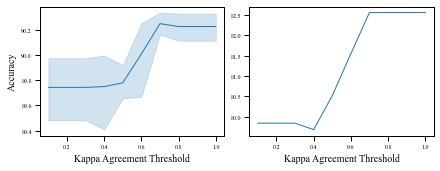

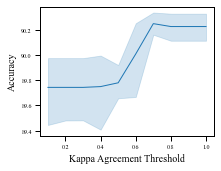

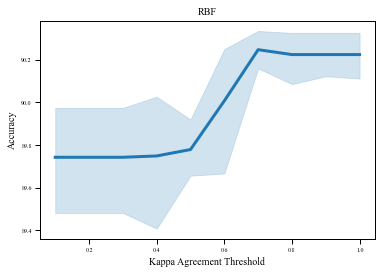

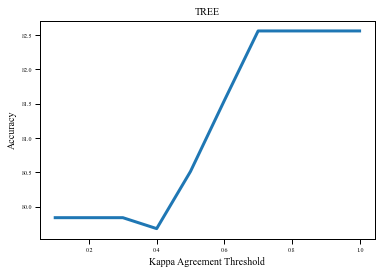

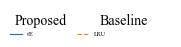

In [13]:
# MAKE PLOTS
def plot_graph(data, poisson_labels, ax, show_legend = True, st = "Default"):
    # cmap = plt.get_cmap('viridis')
    # indices = np.linspace(25, cmap.N-25, 2)
    # my_colors = random.shuffle([cmap(int(i)) for i in indices])

    g = sns.lineplot(x=iv, y=metric, estimator = 'mean', err_style = 'band', ax=ax,
    # linewidth=1, data=data, hue='mem_manage', hue_order=['score', 'rA', 'auc', 'rAAuc', 'arf', 'rcd', 'age', 'LRU', 'acc', 'div'], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'], units = "poisson", estimator=None)
    linewidth=1, data=data, hue='mem_manage', hue_order=['rA', 'LRU'], dashes=["", (4, 2), (4, 2)], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'])

    if show_legend:
        h, l = g.get_legend_handles_labels()
        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", 'arf': 'ARF'}
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]


        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        # box = g.get_position()
        # g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # ours = ax.legend(h_ours, l_ours, 
        #                     fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        # theirs = ax.legend(h_theirs, l_theirs, 
        #                     fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        # ax.add_artist(ours)
        l = ax.legend()
        l.remove()
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    # g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel(metric_replace[iv] if iv in metric_replace else iv)
    ax.set_ylabel(metric_replace[metric] if metric in metric_replace else metric)
def plot_graph_minimal(data, poisson_labels, ax, show_legend = True, st = "Default", m = 'accuracy'):
    # cmap = plt.get_cmap('viridis')
    # indices = np.linspace(25, cmap.N-25, 2)
    # my_colors = random.shuffle([cmap(int(i)) for i in indices])
    g = sns.lineplot(x=iv, y=metric, estimator = 'mean', err_style = 'band', ax=ax,
    # linewidth=1, data=data, hue='mem_manage', hue_order=['score', 'rA', 'auc', 'rAAuc', 'arf', 'rcd', 'age', 'LRU', 'acc', 'div'], sort=True, style= 'creator', style_order= ['mine', 'theirs', 'base'], units = "poisson", estimator=None)
    linewidth=3,  data=data, hue='mem_manage', hue_order=['rA', 'LRU'], sort=True, dashes=["", (4, 2), (4, 2)], style= 'creator', style_order= ['mine', 'theirs', 'base'])

    if show_legend or True:
        h, l = g.get_legend_handles_labels()
        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", 'arf': 'ARF'}
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]


        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        # box = g.get_position()
        # g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # ours = ax.legend(h_ours, l_ours, 
        #                     fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        # theirs = ax.legend(h_theirs, l_theirs, 
        #                     fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        # ax.add_artist(ours)
        l = ax.legend()
        l.remove()
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel(metric_replace[iv] if iv in metric_replace else iv)
    ax.set_ylabel(metric_replace[metric] if metric in metric_replace else metric)
    
    return h_ours, h_theirs, l_ours, l_theirs

overall = df
overall['creator'] = overall['mem_manage'].map(lambda x: "theirs" if x in ['acc', 'age', 'LRU', 'div'] else 'base' if x in ['arf', 'rcd'] else 'mine')
overall[iv] = overall[iv].astype(float)
unique_stream_types = sorted(overall['st'].unique())[:2]
# unique_stream_types = unique_stream_types[:2]
# fig, axs = plt.subplots(1, len(unique_stream_types), sharey=True, figsize = (20,5))
# fig, axs = plt.subplots(1, len(unique_stream_types), figsize = (20,5))
fig, axs = plt.subplots(1, len(unique_stream_types), figsize = get_plot_size(1, 2, 1, 2))
if len(unique_stream_types) < 2:
    axs = [axs]

for st_i, st in enumerate(unique_stream_types):
    print(st)
    df_st = overall.loc[overall['st'] == st]
    # print(df_st.sample(5))
    plot_graph(df_st, [], axs[st_i], st_i == len(unique_stream_types) - 1, st)
    if st_i > 0:
        axs[st_i].get_yaxis().label.set_visible(False)
pic_suffix = ""
# pic_suffix = "ss"
fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-P-MergeSim-{save_name}{pic_suffix}_{iv}_bw_eb.pdf", bbox_inches='tight')

figsize = get_plot_size(1, 2, 1, 1)
fig, ax = plt.subplots(1, 1, figsize = figsize)
print(figsize)
st = 'RCStreamType-RBF'
print(st)
df_st = overall.loc[overall['st'] == st]
# print(df_st.sample(5))
plot_graph(df_st, [], ax, st_i == len(unique_stream_types) - 1, st)
pic_suffix = ""
# pic_suffix = "ss"
fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-P-MergeSim-RBF-{save_name}{pic_suffix}_{iv}_bw_eb.pdf", bbox_inches='tight')

for st_i, st in enumerate(unique_stream_types):
    # m_savename = f"{args['file'].split('.')[0]}-{[x.replace(' ', '') for x in ['accuracy']]}"
    min_fig = plt.figure()
    ax = min_fig.gca()
    try:
        st_name = unique_stream_types[st_i].split('-')[1]
    except:
        st_name = unique_stream_types[st_i]

    # Save just the portion _inside_ the second axis's boundaries
    print(st)
    df_st = overall.loc[overall['st'] == st]

    h_ours, h_theirs, l_ours, l_theirs = plot_graph_minimal(df_st, [], ax, False, st, 'accuracy')
    # min_fig.savefig(f'Mem_Manage_Results/{m_savename}{st_name}_figure_bw.png', bbox_inches='tight')



figsize = (3, 0.1)
# figsize=get_plot_size(0.2, 1, 0.2, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)


print(h_ours, h_theirs, l_ours, l_theirs)
ours = ax_leg.legend(h_ours, l_ours, 
                    fancybox=True, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0, 0, 0.4, 0.1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
ours.get_title().set_fontsize('14')
theirs = ax_leg.legend(h_theirs, l_theirs, 
                    fancybox=True, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.4, 0, 0.6, 0.1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
theirs.get_title().set_fontsize('14')
# ours = m_fig.legend(h_ours, l_ours, 
#                     fancybox=True, ncol=len(h_ours), title = "proposed", bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.1)
# theirs = m_fig.legend(h_theirs, l_theirs, 
#                     fancybox=True, ncol=len(h_theirs), title = "baselines", bbox_to_anchor=(1, 1.02), loc="lower right", borderaxespad=0.1)
ax_leg.add_artist(ours)
# add the legend from the previous axes
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.tight_layout()
fig_leg.savefig(output_location / f"{output_prefix}-P-MergeSim-{save_name}_legend_bw_eb.pdf", bbox_inches='tight')



plt.show()

### RESULTS - ISOLATION

In [6]:
data_location = pathlib.Path(r"G:\My Drive\UniMine\Uni\PhD\SysMemPaper\Datastreams\Mem_Manage")
data_location.exists()

True

In [349]:
# RECREATE RESULTS
# To load instead, use next cell
# df = subdir_run(data_location, None, True, produce_table=True)
# df = df[df['sys_learner'] == "HN"]
# print(df.shape)
# df.head()

G:\My Drive\UniMine\Uni\PhD\SysMemPaper\Datastreams\Mem_Manage
True


0it [00:00, ?it/s]

In [7]:
data_location = data_path / "Memory_Management" / "Results" / "Isolation"
data_location.exists()

True

In [9]:
with (data_location / "r2Iso.pickle").open('rb') as f:
    df = pickle.load(f)
df

accuracy  \
noise nc hd ed ha ea hp  epa  st                   gradual drift_window ml     cl mem_manage rep seed sens  window sys_learner poisson od    sm     merge run_noise merge_similarity             
0-0   25 3  1  15 15 0-5 5000 RCStreamType-RBF     False   0            arf    1  def        0   320  def   def    pyn         def     False def    def   0         0.9               85.02285   
                                                                               10 def        0   320  def   def    pyn         def     False def    def   0         0.9               92.83775   
                                                                               15 def        0   320  def   def    pyn         def     False def    def   0         0.9               93.32925   
                                                                               20 def        0   320  def   def    pyn         def     False def    def   0         0.9               93.54960   
                                                                               25 def        0   320  def   def    pyn         def     False def    def   0         0.9               93.71560   
...                                                                                                                                                                                        ...   
                              RCStreamType-WINDSIM False   0            system 5  div        9   8819 0.06  175    HN          10      False AD.csv def   0         0.9               89.40030   
                                                                                  LRU        9   8819 0.004 50     HN          10      False def    def   0         0.9               89.34485   
                                                                                  rA         9   8819 0.004 50     HN          10      False def    def   0         0.9               89.72030   
                                                                                  rAAuc      9   8819 0.004 50     HN          10      False def    def   0         0.9               89.15210   
                                                                                  score      9   8819 0.004 50     HN          10      False def    def   0         0.9               89.78540   

                                                                                                                                                                                      drift_accuracy_50  \
noise nc hd ed ha ea hp  epa  st                   gradual drift_window ml     cl mem_manage rep seed sens  window sys_learner poisson od    sm     merge run_noise merge_similarity                      
0-0   25 3  1  15 15 0-5 5000 RCStreamType-RBF     False   0            arf    1  def        0   320  def   def    pyn         def     False def    def   0         0.9                        0.568051   
                                                                               10 def        0   320  def   def    pyn         def     False def    def   0         0.9                        0.616389   
                                                                               15 def        0   320  def   def    pyn         def     False def    def   0         0.9                        0.623152   
                                                                               20 def        0   320  def   def    pyn         def     False def    def   0         0.9                        0.625144   
                                                                               25 def        0   320  def   def    pyn         def     False def    def   0         0.9                        0.627136   
...                                                                                                                                                                                                 ...   
                              RCStr

In [10]:
metric = "accuracy"
iv = "mem_manage"
# ttestvar = None
# ttestvar = "mem_manage"
save_name = f"{iv}-{metric.replace(' ', '')}"

In [319]:
df_table = df.unstack(level = 'cl')

# print(df_table.iloc[:, df_table.columns.get_level_values(1) == '25'])

# print(df_table.index)
df_table = df_table.rename(index = {'def': '0'}, level = 'poisson')
df_table = df_table.rename(index = {'def': 'arf'}, level = 'mem_manage')
df_table = df_table.rename(index = {'RCStreamType-RBF': 'RBF'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-TREE': 'TREE'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-WINDSIM': 'WINDSIM'}, level = 'st')
# print(df_table.index)
df_table


# df_table = df_table.groupby(level=['poisson', 'st', 'ml', 'sys_learner',  'mem_manage',]).aggregate([('Mean (STD)', custom_mean)])
df_table_val = df_table.groupby(level=['st', 'mem_manage',]).aggregate([np.mean])
df_table = df_table.groupby(level=['st', 'mem_manage',]).aggregate([(parenthesis_mean_stdev)])

df_table_val = df_table_val.loc[df_table.index.get_level_values(1) != 'arf']
df_table = df_table.loc[df_table.index.get_level_values(1) != 'arf']
df_table_val = df_table_val.loc[df_table.index.get_level_values(1) != 'rAAuc']
df_table = df_table.loc[df_table.index.get_level_values(1) != 'rAAuc']
# skip weird arf values (wrong first run)
cl_vals = [int (x) for x in list(df_table.columns.get_level_values(1))]
# cl_vals = (np.asarray(cl_vals) % 5 == 0) | (np.asarray(cl_vals) == 1)
# cl_vals = (np.isin(np.asarray(cl_vals), [5, 15, 25, 35]))
cl_vals = (np.isin(np.asarray(cl_vals), [5, 10, 15, 20, 25, 35]))
# cl_vals = (np.isin(np.asarray(cl_vals), [5, 20, 35]))
# cl_vals = (np.isin(np.asarray(cl_vals), [5, 20]))
# print(cl_vals)
df_table_val.iloc[:, cl_vals]
df_table = df_table.iloc[:, cl_vals]
df_table = df_table[metric]
df_table_val = df_table_val[metric]
df_table = df_table.droplevel(1, axis=1)
df_table



print(df_table.columns)
# print(df_table.columns.levels[0])

# s = sorted(df_table.columns.levels[1], key = lambda x: float(x) if x.isdigit() else x)
s = sorted(df_table.columns, key = lambda x: int(x) if x != '' else x)
print(s)


df_table = df_table.reindex(s, axis=1)
df_table_val = df_table_val.reindex(s, axis=1)
print(df_table.columns)
df_table




df_table = df_table.rename(columns = {'driftdetect_accuracy_50': "Drift point accuracy", 'accuracy':"Accuracy", 'f1':"$F1_c$", 'f1 by System': "$F1_s$", 'Num Good System Concepts' : '$s \\approx c$'}, level = 0)
df_table_val = df_table_val.rename(columns = {'accuracy':"Accuracy", 'f1':"$f1_c$", 'f1 by System': "$f1_s$"}, level = 0)
print(df_table)
# exit()

# print(df_table)
df_table = df_table.reindex(['LRU','acc', 'age', 'div', 'auc', 'rA', 'score'], axis=0, level = 'mem_manage')
df_table_val = df_table_val.reindex(['LRU','acc', 'age', 'div', 'auc', 'rA', 'score'], axis=0, level = 'mem_manage')
# print(df_table)
# df_table.columns.droplevel(2)
# df_table_val.droplevel(2)
# print(df_table)
# print(df_table_val.loc[:, '25'] - df_table_val.loc[:, '15'])
# df_table['$\delta$ Acc 25 $->$ 15 '] = df_table_val.loc[:, '25'] - df_table_val.loc[:, '15']
# df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'] = df_table.index.get_level_values(0)
# # df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'] = df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].apply(lambda x: x.split('-')[1])
# df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'] = df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].apply(lambda x: f"\multirow{{7}}{{*}}{{\includegraphics[width=4cm]{{images/{save_name}{x}_figure.png}}}}")
# changed = df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].ne(df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].shift(fill_value = "na"))
# print(df_table)
# print(df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].loc[~changed])
# df_table.loc[~changed, "\multicolumn{1}{c}{Accuracy by Memory Plot}"] = ""
df_table = df_table.rename(index = {'RBF': '\multirow{7}*{\\rotatebox{90}{RBF}}'}, level = 'st')
df_table = df_table.rename(index = {'TREE': '\multirow{7}*{\\rotatebox{90}{TREE}}'}, level = 'st')
df_table = df_table.rename(index = {'WINDSIM': '\multirow{7}*{\\rotatebox{90}{WINDSIM}}'}, level = 'st')
# print(df_table)


# print(df_table.xs('mean', axis = 1, level = 1, drop_level = False))
# print(df_table.xs('std', axis = 1, level = 1, drop_level = False))
# print(df_table.xs('mean', axis = 1, level = 1, drop_level = False).map(str) + df_table.xs('std', axis = 1, level = 1, drop_level = False).map(str))
# df_table.loc['mean'] = df_table.xs('mean', axis = 1, level = 1, drop_level = False) + df_table.xs('std', axis = 1, level = 1, drop_level = False)
df_table.index.names = [x if x != 'st' else '' for x in df_table.index.names]
df_table.index.names = [x if x != 'mem_manage' else 'Strategy' for x in df_table.index.names]
with pd.option_context("max_colwidth", 1000):
    table_latex = df_table.to_latex(escape = False)
table_latex_lines = table_latex.splitlines()
new_latex_lines = []

max_cols = {}
st = ""
for l_i,l in enumerate(table_latex_lines):

    if 'RBF' in l:
        st = 'RBF'
    if 'TREE' in l:
        st = 'TREE'
    if 'WINDSIM' in l:
        st = 'WINDSIM'

    cells = l.split('&')
    # if 'RBF' in cells[0]:
    #     cells[0] = '\multirow{5}*{\\rotatebox{90}{RBF}}'
    # if 'TREE' in l:
    #     cells[0] = '\multirow{5}*{\\rotatebox{90}{TREE}}'
    # if 'WINDSIM' in cells[0]:
    #     cells[0] = '\multirow{5}*{\\rotatebox{90}{WINDSIM}}'
    for c_i,c in enumerate(cells):
        c = c.strip()
        if len(c) == 0:
            continue
        
        if c.strip()[0].isdigit():
            print(f"{c.strip()}, {c.strip() == '0.00 (0.00)'}")
            if c.strip() == '0.00 (0.00)':
                cells[c_i] = '0(0)' 
            val = c.split('(')[0].split('\\')[0]
            val = float(val)
            if (c_i, st) not in max_cols:
                max_cols[(c_i, st)] = [(l_i, val, st)]
            else:
                if val > max_cols[(c_i, st)][0][1]:
                    max_cols[(c_i, st)] = [(l_i, val, st)]
                elif val == max_cols[(c_i, st)][0][1]:
                    max_cols[(c_i, st)].append((l_i, val, st))
    table_latex_lines[l_i] = '&'.join(cells)
for c_i, st in max_cols:
    for l_i, val, st in max_cols[(c_i, st)]:
        cells = table_latex_lines[l_i].split('&')
            
        new_content = cells[c_i] if not '\\\\' in cells[c_i] else cells[c_i].split('\\\\')[0]
        cells[c_i] = f"\\textbf{{{cells[c_i].strip()}}}" if not '\\\\' in cells[c_i] else f"\\textbf{{{new_content.strip()}}}" + "\\\\"
        table_latex_lines[l_i] = '&'.join(cells)

# print(table_latex_lines)
colors = sns.color_palette().as_hex()
# print(colors)
for l_i,l in enumerate(table_latex_lines):
    add_break = False
    cells = l.split('&')
    if l_i == 3:
        cells[0] = "$N$"
    if 'LRU' in l:
        cells[1] = 'LRU'
        # for c in range(1, len(cells)):
        #     cells[c] = f"\cellcolor{{snso}}{cells[c]}"
    if '&acc&' in l:
        cells[1] = 'Accuracy'
    if ' age ' in l:
        cells[1] = 'FIFO'
    if 'div' in l:
        cells[1] = 'DP'
        # add_break = True
    if 'rA' in l:
        cells[1] = '\\textbf{\\texttt{\#}E}'
        # for c in range(1, len(cells)):
        #     cells[c] = f"\cellcolor{{snsb}}{cells[c]}"
    if 'auc' in l:
        cells[1] = '\\textbf{AAC}'
    if 'score' in l:
        cells[1] = '\\textbf{EP}'
        add_break = True
    
    # if l_i > 1:
    #     cells.insert(11, " ")
    #     cells.insert(8, " ")
    #     cells.insert(5, " ")
    new_line = '&'.join(cells)
    # print(new_line)
    new_latex_lines.append(new_line)
    if add_break:
        new_latex_lines.append("\\\\")
table_latex = '\n'.join(new_latex_lines)
table_latex
with open(output_location / f"{output_prefix}-ISO-res-table.txt", 'w') as f:
    f.write(table_latex)
print(df_table)

Index(['10', '15', '20', '25', '5'], dtype='object', name='cl')
['5', '10', '15', '20', '25']
Index(['5', '10', '15', '20', '25'], dtype='object', name='cl')
cl                             5            10            15            20  \
st      mem_manage                                                           
RBF     LRU         88.80 (0.36)  89.69 (0.38)  90.70 (0.38)  91.89 (0.40)   
        acc         88.79 (0.31)  89.67 (0.32)  90.67 (0.36)  91.91 (0.40)   
        age         88.79 (0.35)  89.67 (0.38)  90.60 (0.39)  91.74 (0.37)   
        auc         89.22 (0.37)  90.45 (0.35)  91.58 (0.33)  92.63 (0.35)   
        div         88.84 (0.39)  89.76 (0.30)  90.77 (0.33)  92.00 (0.43)   
        rA          89.13 (0.28)  90.27 (0.36)  91.40 (0.30)  92.45 (0.27)   
        score       89.06 (0.29)  90.15 (0.29)  91.27 (0.36)  92.32 (0.30)   
TREE    LRU         78.26 (1.21)  79.34 (1.26)  81.22 (1.06)  84.13 (1.05)   
        acc         78.17 (1.26)  79.44 (1.30)  81.48 (1.14)  

In [11]:
from matplotlib.ticker import FormatStrFormatter
df_t = df.iloc[df.index.get_level_values('sens') != '0.02']
df_t = df_t.reset_index()
df_t



noise  nc hd ed  ha  ea   hp   epa                    st gradual  ...  \
0      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
1      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
2      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
3      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
4      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
...    ...  .. .. ..  ..  ..  ...   ...                   ...     ...  ...   
1655   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1656   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1657   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1658   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1659   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   

      MR by System_alt MP by System_alt PMR by System_alt RMP by System_alt  \
0                  0.0              0.0               0.0               0.0   
1                  0.0              0.0               0.0               0.0   
2                  0.0              0.0               0.0               0.0   
3                  0.0              0.0               0.0               0.0   
4                  0.0              0.0               0.0               0.0   
...                ...              ...               ...               ...   
1655               0.0              0.0               0.0               0.0   
1656               0.0              0.0               0.0               0.0   
1657               0.0              0.0               0.0               0.0   
1658               0.0              0.0               0.0               0.0   
1659               0.0              0.0               0.0               0.0   

      f1 by System_alt Num Good System Concepts_alt     F1 GT    F1 Sys  \
0                  0.0                          0.0  0.076923  0.076923   
1                  0.0                          0.0  0.076923  0.076923   
2                  0.0                          0.0  0.076923  0.076923   
3                  0.0                          0.0  0.076923  0.076923   
4                  0.0                          0.0  0.076923  0.076923   
...                ...                          ...       ...       ...   
1655               0.0                          0.0  0.284334  0.177231   
1656               0.0                          0.0  0.272298  0.177354   
1657               0.0                          0.0  0.483218  0.442281   
1658               0.0                          0.0  0.314877  0.215180   
1659               0.0                          0.0  0.407112  0.312205   

              time memory  
0      2296.533577   -1.0  
1     21176.581787   -1.0  
2     32588.956443   -1.0  
3     40464.121295   -1.0  
4     52950.517112   -1.0  
...            ...    ...  
1655   3757.574575   -1.0  
1656   3894.689838   -1.0  
1657   3831.144479   -1.0  
1658   3816.878868   -1.0  
1659   3822.358032   -1.0  

[1660 rows x 125 columns]

In [355]:
#FORMAT DATA
# print(df_grouped.columns.levels)
cl_vals = [int(x) for x in df_t['cl'].unique()]
mm_vals = list(df_t['mem_manage'].unique())
# print(cl_vals)
# print(np.any(np.asarray(cl_vals) == 2))
cl_vals = np.asarray(cl_vals) < 30
mm_vals = np.asarray(mm_vals) == 'def'
# cl_vals = np.bitwise_or(np.asarray(cl_vals) % 5 == 0, np.asarray(cl_vals) == 1, np.asarray(cl_vals) < 30)
# print(cl_vals)
# exit()
# print(mm_vals)
# df_grouped = df_grouped.iloc[:, np.bitwise_and(cl_vals,mm_vals)]
# print(df_grouped.shape)



st_levels = df_t['st'].unique()




def plot_graph(data, first, ax, fig, show_legend = True, st = "Default", m = "accuracy", show_title = True, show_ytitle = True, show_xtitle = True):
    hue_order = ['score', 'rA', 'auc', 'age', 'LRU', 'acc', 'div']
    g = sns.lineplot(x='cl', y=m, err_style = None, ax=ax,
    linewidth=0.5, data=data, hue='mem_manage',markers=True, dashes=False, hue_order=hue_order, sort=True, style= 'mem_manage', style_order=hue_order)
    # ax.set_yticklabels(["{:.2f}".format(t) for t in ax.get_yticks()])

    lines = g.get_lines()
    for l in lines[3:7]:
        l.set_dashes((4, 2))

    if show_legend:
        h, l = g.get_legend_handles_labels()
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA']]
        # h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]
        # h_theirs = [x[0] for x in zip(h, l) if x[1] in ['arf']]

        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", "arf": "ARF"}
        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA']]
        # l_theirs = [x[1] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]
        # l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['arf']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")
    else:
        h_ours, h_theirs, l_ours, l_theirs = None, None, None, None

    l = ax.legend()
    l.remove()

    if show_title:
        g.set_title(f"{st.split('-')[-1]}")
    if show_xtitle:
        ax.set_xlabel("Max Repository Size")

    if show_ytitle:
        ax.set_ylabel(m if m not in metric_replace else metric_replace[m])
    else:
        ax.get_yaxis().label.set_visible(False)
    
    
    return h_ours, h_theirs, l_ours, l_theirs 



def plot_graph_minimal(data, poisson_labels, ax, show_legend = True, st = "Default", m = "accuracy"):
    
    print(data)
    g = sns.lineplot(x='cl', y=m, err_style = None, ax=ax,
    linewidth=3, data=data, hue='mem_manage', hue_order=['rA', 'LRU'], dashes=["", (4, 2), (4, 2)], sort=True, style='creator', style_order= ['mine', 'theirs', 'base'])
    ax.set_yticklabels(["{:.2e}".format(t) for t in ax.get_yticks()])
    if show_legend:
        h, l = g.get_legend_handles_labels()
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]


        l_ours = [x[1] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # l_theirs = [x[1] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        l_theirs = [x[1] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        ours = ax.legend(h_ours, l_ours, 
                            fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        theirs = ax.legend(h_theirs, l_theirs, 
                            fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        ax.add_artist(ours)
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel("Max Repository Size")
    ax.set_ylabel(m if m not in metric_replace else metric_replace[m])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)
    


3
['RCStreamType-RBF' 'RCStreamType-TREE' 'RCStreamType-WINDSIM']
RCStreamType-RBF
RCStreamType-TREE
RCStreamType-WINDSIM


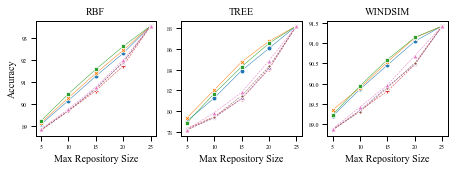

In [17]:
# PLOT FIGURE
print(len(st_levels))
num_sts = 3
overall = df_t
overall['creator'] = overall['mem_manage'].map(lambda x: "theirs" if x in ['acc', 'age', 'LRU', 'div'] else 'base' if x in ['arf', 'rcd'] else 'mine')
overall['cl'] = overall['cl'].astype(int)
unique_stream_types = overall['st'].unique()
print(unique_stream_types)
unique_stream_types = ['RCStreamType-RBF', 'RCStreamType-TREE', 'RCStreamType-WINDSIM']
fig, axs = plt.subplots(1, len(unique_stream_types), figsize = get_plot_size(1, 1, 1, 1, width_multiplier=1))
if len(unique_stream_types) < 2:
    axs = [axs]
for st_i, st in enumerate(unique_stream_types):
    print(st)
    df_st = overall.loc[(overall['st'] == st) & (overall['cl'] >= 5)]
    try:
        h_ours, h_theirs, l_ours, l_theirs = plot_graph(df_st, st_i == 0, axs[st_i], fig, st_i == len(unique_stream_types) - 1, st, m=metric, show_ytitle=st_i == 0)
    except Exception as e:
        print(e)

pic_suffix = ""
# pic_suffix = "ss"
fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-ISO-{save_name}{pic_suffix}_bw.pdf", bbox_inches='tight')


[<matplotlib.lines.Line2D object at 0x0000014A078A1D30>, <matplotlib.lines.Line2D object at 0x0000014A078A1A00>, <matplotlib.lines.Line2D object at 0x0000014A09FB5E50>] [<matplotlib.lines.Line2D object at 0x0000014A09FB56D0>, <matplotlib.lines.Line2D object at 0x0000014A049B5790>, <matplotlib.lines.Line2D object at 0x0000014A049B5580>, <matplotlib.lines.Line2D object at 0x0000014A07995250>] ['EP', '#E', 'AAC'] ['FIFO', 'LRU', 'Acc', 'DP']
--
--
--
--


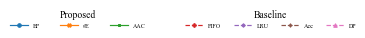

In [323]:
# PLOT LEGEND
figsize = get_plot_size(0.15, 1, 0.15, 1)
fig_leg, ax_leg = plt.subplots(figsize=figsize)


print(h_ours, h_theirs, l_ours, l_theirs)
for l in h_theirs:
    print(l.get_linestyle())
    # l.set_
ours = ax_leg.legend(h_ours, l_ours, 
                    # fancybox=True, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0.3, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
                    fancybox=True, markerscale=0.75, handlelength=3, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0, 0, 0.4, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
# ours.get_title().set_fontsize('14')
theirs = ax_leg.legend(h_theirs, l_theirs, 
                    # fancybox=True, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.6, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
                    fancybox=True, markerscale=0.75, handlelength=3, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.5, 0, 0.5, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
# theirs.get_title().set_fontsize('14')
# ours = m_fig.legend(h_ours, l_ours, 
#                     fancybox=True, ncol=len(h_ours), title = "proposed", bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.1)
# theirs = m_fig.legend(h_theirs, l_theirs, 
#                     fancybox=True, ncol=len(h_theirs), title = "baselines", bbox_to_anchor=(1, 1.02), loc="lower right", borderaxespad=0.1)
ax_leg.add_artist(ours)
# add the legend from the previous axes
# hide the axes frame and the x/y labels
ax_leg.axis('off')
# fig_leg.tight_layout()
fig_leg.savefig(output_location / f"{output_prefix}-ISO_{save_name}_legend_bw.pdf", bbox_inches='tight', pad_inches=0)

### RESULTS - MAIN SYNTHETIC

In [18]:
data_location = data_path / "Memory_Management" / "Results" / "MainSynthetic"
data_location.exists()

True

In [19]:
with (data_location / "NHSnew4.pickle").open('rb') as f:
    df = pd.read_pickle(f)
df

accuracy  \
noise nc hd ed ha ea hp  epa  st                   gradual drift_window ml     cl mem_manage rep sens window sys_learner poisson od    sm  merge   run_noise             
0-0   25 3  1  15 15 0-5 5000 RCStreamType-RBF     False   0            arf    1  def        0   def  def    pyn         def     False def def     0          85.02285   
                                                                               10 def        0   def  def    pyn         def     False def def     0          92.83775   
                                                                               15 def        0   def  def    pyn         def     False def def     0          93.32925   
                                                                               20 def        0   def  def    pyn         def     False def def     0          93.54960   
                                                                               25 def        0   def  def    pyn         def     False def def     0          93.71560   
...                                                                                                                                                                ...   
                              RCStreamType-WINDSIM False   0            system 5  div        9   0.05 175    HN          10      False KT  acc.csv 0          89.07230   
                                                                                  LRU        9   0.05 175    HN          10      False KT  acc.csv 0          89.03460   
                                                                                  rA         9   0.05 175    HN          10      False KT  acc.csv 0          89.56640   
                                                                                  rAAuc      9   0.05 175    HN          10      False KT  acc.csv 0          89.01265   
                                                                                  score      9   0.05 175    HN          10      False KT  acc.csv 0          89.22545   

                                                                                                                                                              drift_accuracy_50  \
noise nc hd ed ha ea hp  epa  st                   gradual drift_window ml     cl mem_manage rep sens window sys_learner poisson od    sm  merge   run_noise                      
0-0   25 3  1  15 15 0-5 5000 RCStreamType-RBF     False   0            arf    1  def        0   def  def    pyn         def     False def def     0                   0.568051   
                                                                               10 def        0   def  def    pyn         def     False def def     0                   0.616389   
                                                                               15 def        0   def  def    pyn         def     False def def     0                   0.623152   
                                                                               20 def        0   def  def    pyn         def     False def def     0                   0.625144   
                                                                               25 def        0   def  def    pyn         def     False def def     0                   0.627136   
...                                                                                                                                                                         ...   
                              RCStreamType-WINDSIM False   0            system 5  div        9   0.05 175    HN          10      False KT  acc.csv 0                   0.705358   
                                                                                  LRU        9   0.05 175    HN          10      False KT  acc.csv 0                   0.709238   
                                                                                  rA         9   0.05 175    HN          10      False KT  acc.csv 0         

In [20]:
with (data_location / "drift_data_CS_U.txt").open('r') as f:
    drift_data = json.load(f)
merge_data = []
for k, v in drift_data.items():
    run_data = k.split('-')
    full_data = {"st": f"RCStreamType-{run_data[0]}", "seed": run_data[1], "cl": run_data[2], "mem_manage": run_data[3], **v}
    merge_data.append(full_data)
merge_df = pd.DataFrame.from_records(merge_data)
seed_map = {}
st_levels = merge_df['st'].unique()
for st in st_levels:
    st_df = merge_df[merge_df['st'] == st]
    st_seeds = st_df['seed'].unique()
    for rep, seed in enumerate(st_seeds):
        seed_map[f"{st}{seed}"] = rep
merge_df['seed_st'] = merge_df['st'] + merge_df['seed']
# merge_df['seed'].factorize()
merge_df['rep'] = merge_df['seed_st'].map(seed_map)
merge_df


st  seed  cl mem_manage  num_drifts  num_detections  \
0         RCStreamType-RBF  3342   5      rAAuc       375.0           756.0   
1         RCStreamType-RBF  3342   5      score       375.0           720.0   
2         RCStreamType-RBF  3896  40        auc       375.0           502.0   
3         RCStreamType-RBF  3896  40        div       375.0           511.0   
4         RCStreamType-RBF  3896  40        LRU       375.0           503.0   
...                    ...   ...  ..        ...         ...             ...   
1287  RCStreamType-WINDSIM  1483  35        acc       375.0           512.0   
1288  RCStreamType-WINDSIM  1483  35        age       375.0           522.0   
1289  RCStreamType-WINDSIM  1483  35        auc       375.0           511.0   
1290  RCStreamType-WINDSIM  1483  35        div       375.0           521.0   
1291  RCStreamType-WINDSIM  1483  35        LRU       375.0           518.0   

      num_valid_drifts  avg_delay  num_model_swaps  avg_delay_2  \
0                353.0         -1               10   455.573333   
1                346.0         -1                2   499.413333   
2                386.0         -1                3   322.320000   
3                374.0         -1                2   409.792000   
4                379.0         -1                3   344.085333   
...                ...        ...              ...          ...   
1287             288.0         -1                9  1042.733333   
1288             292.0         -1               12   986.197333   
1289             289.0         -1               10  1026.288000   
1290             297.0         -1               12  1004.642667   
1291             295.0         -1                9   995.394667   

                       seed_st  rep  
0         RCStreamType-RBF3342    0  
1         RCStreamType-RBF3342    0  
2         RCStreamType-RBF3896    1  
3         RCStreamType-RBF3896    1  
4         RCStreamType-RBF3896    1  
...                        ...  ...  
1287  RCStreamType-WINDSIM1483    0  
1288  RCStreamType-WINDSIM1483    0  
1289  RCStreamType-WINDSIM1483    0  
1290  RCStreamType-WINDSIM1483    0  
1291  RCStreamType-WINDSIM1483    0  

[1292 rows x 12 columns]

In [21]:
metric = "accuracy"
metrics = ["accuracy"]
iv = "mem_manage"
# ttestvar = None
# ttestvar = "mem_manage"
save_name = f"{iv}-{metric.replace(' ', '')}"

In [227]:
df_table = df.unstack(level = 'cl')

# print(df_table.iloc[:, df_table.columns.get_level_values(1) == '25'])

# print(df_table.index)
df_table = df_table.rename(index = {'def': '0'}, level = 'poisson')
df_table = df_table.rename(index = {'def': 'arf'}, level = 'mem_manage')
df_table = df_table.rename(index = {'RCStreamType-RBF': 'RBF'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-TREE': 'TREE'}, level = 'st')
df_table = df_table.rename(index = {'RCStreamType-WINDSIM': 'WINDSIM'}, level = 'st')
# print(df_table.index)


# df_table = df_table.groupby(level=['poisson', 'st', 'ml', 'sys_learner',  'mem_manage',]).aggregate([('Mean (STD)', custom_mean)])
df_table_val = df_table.groupby(level=['st', 'mem_manage',]).aggregate([np.mean])
df_table = df_table.groupby(level=['st', 'mem_manage',]).aggregate([('', parenthesis_mean_stdev)])

df_table_val = df_table_val.loc[df_table.index.get_level_values(1) != 'arf']
df_table = df_table.loc[df_table.index.get_level_values(1) != 'arf']
df_table_val = df_table_val.loc[df_table.index.get_level_values(1) != 'rAAuc']
df_table = df_table.loc[df_table.index.get_level_values(1) != 'rAAuc']
# skip weird arf values (wrong first run)
cl_vals = [int (x) for x in list(df_table.columns.get_level_values(1))]
# cl_vals = (np.asarray(cl_vals) % 5 == 0) | (np.asarray(cl_vals) == 1)
cl_vals = (np.isin(np.asarray(cl_vals), [5, 15, 25, 35]))
# cl_vals = (np.isin(np.asarray(cl_vals), [5, 20, 35]))
# cl_vals = (np.isin(np.asarray(cl_vals), [5, 20]))
# print(cl_vals)
df_table_val.iloc[:, cl_vals]
df_table = df_table.iloc[:, cl_vals]
df_table

list(df_table.columns)



# print(df_table)

df_table = df_table[metric]
df_table_val = df_table_val[metric]
print(df_table.columns)
# df_table.columns = df_table.columns.swaplevel(0, 1)
print(df_table.columns)
s = sorted(df_table.columns.levels[1], key = lambda x: float(x) if x.isdigit() else x)



# print(s)
df_table = df_table.reindex(s, axis=1, level = 1)
df_table_val = df_table_val.reindex(s, axis=1, level = 1)
print(df_table.columns.levels[1])
# df_table = df_table.rename(columns = {'driftdetect_accuracy_50': "Drift point accuracy", 'accuracy':"Accuracy", 'f1':"$F1_c$", 'f1 by System': "$F1_s$", 'Num Good System Concepts' : '$s \\approx c$'}, level = 0)
df_table = df_table.rename(columns = {'driftdetect_accuracy_50': "Recovery accuracy", 'accuracy':"Accuracy", 'f1':"$F1_c$", 'f1 by System': "$F1_s$", 'Num Good System Concepts' : '$s \\approx c$'}, level = 0)
df_table_val = df_table_val.rename(columns = {'accuracy':"Accuracy", 'f1':"$f1_c$", 'f1 by System': "$f1_s$"}, level = 0)
print(df_table)
# exit()

# print(df_table)
df_table = df_table.reindex(['LRU','acc', 'age', 'div', 'auc', 'rA', 'score'], axis=0, level = 'mem_manage')
df_table_val = df_table_val.reindex(['LRU','acc', 'age', 'div', 'auc', 'rA', 'score'], axis=0, level = 'mem_manage')
# print(df_table)
# df_table.columns.droplevel(2)
# df_table_val.droplevel(2)
# print(df_table)
# print(df_table_val.loc[:, '25'] - df_table_val.loc[:, '15'])
# df_table['$\delta$ Acc 25 $->$ 15 '] = df_table_val.loc[:, '25'] - df_table_val.loc[:, '15']
# df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'] = df_table.index.get_level_values(0)
# # df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'] = df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].apply(lambda x: x.split('-')[1])
# df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'] = df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].apply(lambda x: f"\multirow{{7}}{{*}}{{\includegraphics[width=4cm]{{images/{save_name}{x}_figure.png}}}}")
# changed = df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].ne(df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].shift(fill_value = "na"))
# print(df_table)
# print(df_table['\multicolumn{1}{c}{Accuracy by Memory Plot}'].loc[~changed])
# df_table.loc[~changed, "\multicolumn{1}{c}{Accuracy by Memory Plot}"] = ""
df_table = df_table.rename(index = {'RBF': '\multirow{7}*{\\rotatebox{90}{RBF}}'}, level = 'st')
df_table = df_table.rename(index = {'TREE': '\multirow{7}*{\\rotatebox{90}{TREE}}'}, level = 'st')
df_table = df_table.rename(index = {'WINDSIM': '\multirow{7}*{\\rotatebox{90}{WINDSIM}}'}, level = 'st')
# print(df_table)


# print(df_table.xs('mean', axis = 1, level = 1, drop_level = False))
# print(df_table.xs('std', axis = 1, level = 1, drop_level = False))
# print(df_table.xs('mean', axis = 1, level = 1, drop_level = False).map(str) + df_table.xs('std', axis = 1, level = 1, drop_level = False).map(str))
# df_table.loc['mean'] = df_table.xs('mean', axis = 1, level = 1, drop_level = False) + df_table.xs('std', axis = 1, level = 1, drop_level = False)
df_table.index.names = [x if x != 'st' else '' for x in df_table.index.names]
df_table.index.names = [x if x != 'mem_manage' else 'Strategy' for x in df_table.index.names]
with pd.option_context("max_colwidth", 1000):
    table_latex = df_table.to_latex(escape = False)
table_latex_lines = table_latex.splitlines()
new_latex_lines = []

max_cols = {}
st = ""
for l_i,l in enumerate(table_latex_lines):

    if 'RBF' in l:
        st = 'RBF'
    if 'TREE' in l:
        st = 'TREE'
    if 'WINDSIM' in l:
        st = 'WINDSIM'

    cells = l.split('&')
    # if 'RBF' in cells[0]:
    #     cells[0] = '\multirow{5}*{\\rotatebox{90}{RBF}}'
    # if 'TREE' in l:
    #     cells[0] = '\multirow{5}*{\\rotatebox{90}{TREE}}'
    # if 'WINDSIM' in cells[0]:
    #     cells[0] = '\multirow{5}*{\\rotatebox{90}{WINDSIM}}'
    for c_i,c in enumerate(cells):
        c = c.strip()
        if len(c) == 0:
            continue
        
        if c.strip()[0].isdigit():
            print(f"{c.strip()}, {c.strip() == '0.00 (0.00)'}")
            if c.strip() == '0.00 (0.00)':
                cells[c_i] = '0(0)' 
            val = c.split('(')[0].split('\\')[0]
            val = float(val)
            if (c_i, st) not in max_cols:
                max_cols[(c_i, st)] = [(l_i, val, st)]
            else:
                if val > max_cols[(c_i, st)][0][1]:
                    max_cols[(c_i, st)] = [(l_i, val, st)]
                elif val == max_cols[(c_i, st)][0][1]:
                    max_cols[(c_i, st)].append((l_i, val, st))
    table_latex_lines[l_i] = '&'.join(cells)
for c_i, st in max_cols:
    for l_i, val, st in max_cols[(c_i, st)]:
        cells = table_latex_lines[l_i].split('&')
            
        new_content = cells[c_i] if not '\\\\' in cells[c_i] else cells[c_i].split('\\\\')[0]
        cells[c_i] = f"\\textbf{{{cells[c_i].strip()}}}" if not '\\\\' in cells[c_i] else f"\\textbf{{{new_content.strip()}}}" + "\\\\"
        table_latex_lines[l_i] = '&'.join(cells)

# print(table_latex_lines)
colors = sns.color_palette().as_hex()
# print(colors)
for l_i,l in enumerate(table_latex_lines):
    add_break = False
    cells = l.split('&')
    if l_i == 3:
        cells[0] = "$N$"
    if 'LRU' in l:
        cells[1] = 'LRU'
        # for c in range(1, len(cells)):
        #     cells[c] = f"\cellcolor{{snso}}{cells[c]}"
    if '&acc&' in l:
        cells[1] = 'Accuracy'
    if ' age ' in l:
        cells[1] = 'FIFO'
    if 'div' in l:
        cells[1] = 'DP'
        # add_break = True
    if 'rA' in l:
        cells[1] = '\\textbf{\\texttt{\#}E}'
        # for c in range(1, len(cells)):
        #     cells[c] = f"\cellcolor{{snsb}}{cells[c]}"
    if 'auc' in l:
        cells[1] = '\\textbf{AAC}'
    if 'score' in l:
        cells[1] = '\\textbf{EP}'
        add_break = True
    
    # if l_i > 1:
    #     cells.insert(11, " ")
    #     cells.insert(8, " ")
    #     cells.insert(5, " ")
    new_line = '&'.join(cells)
    # print(new_line)
    new_latex_lines.append(new_line)
    if add_break:
        new_latex_lines.append("\\\\")
table_latex = '\n'.join(new_latex_lines)

with open(f'Mem_Manage_Results/{save_name}_plot_bw.txt', 'w') as f:
    print(df_table)
    f.write(table_latex)

accuracy                                            \
cl                            15            25            35             5   
                                                                             
st      mem_manage                                                           
RBF     LRU         89.00 (0.33)  90.29 (0.43)  91.24 (0.45)  87.89 (0.41)   
        acc         88.97 (0.40)  90.02 (0.36)  90.98 (0.40)  87.89 (0.40)   
        age         88.85 (0.34)  89.74 (0.30)  90.47 (0.44)  87.87 (0.40)   
        auc         89.96 (0.35)  91.01 (0.48)  91.43 (0.43)  88.20 (0.35)   
        div         89.11 (0.44)  90.03 (0.42)  90.85 (0.43)  87.91 (0.41)   
        rA          90.10 (0.39)  91.33 (0.40)  91.55 (0.37)  88.31 (0.43)   
        score       89.43 (0.39)  90.50 (0.29)  90.95 (0.42)  88.07 (0.33)   
TREE    LRU         77.57 (1.07)  78.82 (1.21)  80.69 (0.89)  76.14 (1.26)   
        acc         77.58 (0.99)  78.87 (0.93)  79.95 (1.13)  76.23 (1.31)   
        age         77.05 (1.16)  78.11 (1.12)  79.12 (0.97)  76.13 (1.29)   
        auc         79.69 (1.06)  81.68 (1.03)  82.88 (0.99)  76.94 (1.23)   
        div         77.58 (1.03)  79.39 (1.00)  80.55 (0.73)  76.31 (1.19)   
        rA          81.39 (0.78)  83.32 (0.78)  83.36 (0.73)  77.54 (1.30)   
        score       79.03 (1.09)  80.63 (1.26)  81.43 (1.11)  76.87 (1.37)   
WINDSIM LRU         89.19 (1.13)  89.38 (1.15)  89.50 (1.17)  88.63 (1.20)   
        acc         89.07 (1.14)  89.33 (1.16)  89.51 (1.11)  88.62 (1.22)   
        age         88.95 (1.23)  89.14 (1.17)  89.35 (1.15)  88.62 (1.25)   
        auc         89.29 (1.14)  89.42 (1.15)  89.48 (1.13)  88.84 (1.21)   
        div         89.04 (1.20)  89.36 (1.18)  89.51 (1.10)  88.63 (1.22)   
        rA          89.46 (1.15)  89.45 (1.14)  89.54 (1.12)  89.25 (1.15)   
        score       89.06 (1.17)  89.26 (1.18)  89.36 (1.15)  88.74 (1.11)   

                   drift_accuracy_50                                         \
cl                                15           25           35            5   
                                                                              
st      mem_manage                                                            
RBF     LRU              0.58 (0.01)  0.58 (0.01)  0.57 (0.01)  0.58 (0.01)   
        acc              0.58 (0.01)  0.58 (0.01)  0.57 (0.00)  0.58 (0.01)   
        age              0.58 (0.01)  0.58 (0.01)  0.57 (0.01)  0.58 (0.01)   
        auc              0.58 (0.01)  0.58 (0.01)  0.57 (0.01)  0.58 (0.01)   
        div              0.58 (0.01)  0.57 (0.01)  0.58 (0.00)  0.58 (0.01)   
        rA               0.58 (0.01)  0.58 (0.01)  0.58 (0.01)  0.58 (0.01)   
        score            0.58 (0.01)  0.57 (0.01)  0.58 (0.01)  0.58 (0.01)   
TREE    LRU              0.52 (0.01)  0.52 (0.01)  0.52 (0.01)  0.52 (0.01)   
        acc              0.52 (0.00)  0.52 (0.00)  0.52 (0.01)  0.52 (0.01)   
        age              0.52 (0.01)  0.52 (0.00)  0.52 (0.01)  0.52 (0.01)   
        auc              0.52 (0.01)  0.52 (0.00)  0.52 (0.01)  0.52 (0.01)   
        div              0.52 (0.01)  0.52 (0.01)  0.52 (0.01)  0.52 (0.01)   
        rA               0.52 (0.01)  0.52 (0.01)  0.52 (0.00)  0.52 (0.01)   
        score            0.52 (0.00)  0.52 (0.01)  0.52 (0.00)  0.52 (0.01)   
WINDSIM LRU              0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.02)   
        acc              0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.01)   
        age              0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.02)   
        auc              0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.02)   
        div              0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.02)   
        rA               0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.02)   
        score            0.71 (0.02)  0.71 (0.02)  0.71 (0.02)  0.71 (0.01)   

                   drift_accuracy_100               ...       F1 Sys  \
cl                       

In [22]:
from matplotlib.ticker import FormatStrFormatter
df_t = df.iloc[df.index.get_level_values('sens') != '0.02']
df_t = df_t.reset_index()
df_t

noise  nc hd ed  ha  ea   hp   epa                    st gradual  ...  \
0      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
1      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
2      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
3      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
4      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
...    ...  .. .. ..  ..  ..  ...   ...                   ...     ...  ...   
2413   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
2414   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
2415   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
2416   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
2417   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   

      MR by System_alt MP by System_alt PMR by System_alt RMP by System_alt  \
0             0.000000         0.000000          0.000000          0.000000   
1             0.000000         0.000000          0.000000          0.000000   
2             0.000000         0.000000          0.000000          0.000000   
3             0.000000         0.000000          0.000000          0.000000   
4             0.000000         0.000000          0.000000          0.000000   
...                ...              ...               ...               ...   
2413          0.094174         0.595195          0.595195          0.094174   
2414          0.086576         0.624414          0.624414          0.086576   
2415          0.194542         0.542135          0.542135          0.194542   
2416          0.081124         0.641892          0.641892          0.081124   
2417          0.099588         0.650679          0.650679          0.099588   

      f1 by System_alt Num Good System Concepts_alt     F1 GT    F1 Sys  \
0             0.000000                          0.0  0.076923  0.076923   
1             0.000000                          0.0  0.076923  0.076923   
2             0.000000                          0.0  0.076923  0.076923   
3             0.000000                          0.0  0.076923  0.076923   
4             0.000000                          0.0  0.076923  0.076923   
...                ...                          ...       ...       ...   
2413          0.149816                          0.0  0.223993  0.165090   
2414          0.144184                          0.0  0.218355  0.163327   
2415          0.209415                          0.0  0.143191  0.421243   
2416          0.137905                          0.0  0.215602  0.157509   
2417          0.159313                          0.0  0.287031  0.245013   

              time  memory  
0      2296.533577    -1.0  
1     21176.581787    -1.0  
2     32588.956443    -1.0  
3     40464.121295    -1.0  
4     52950.517112    -1.0  
...            ...     ...  
2413   8016.408440    -1.0  
2414   7813.147949    -1.0  
2415   8695.942359    -1.0  
2416   7563.350027    -1.0  
2417   7897.628479    -1.0  

[2418 rows x 69 columns]

In [23]:
#FORMAT DATA
# print(df_grouped.columns.levels)
cl_vals = [int(x) for x in df_t['cl'].unique()]
mm_vals = list(df_t['mem_manage'].unique())
# print(cl_vals)
# print(np.any(np.asarray(cl_vals) == 2))
cl_vals = np.asarray(cl_vals) < 30
mm_vals = np.asarray(mm_vals) == 'def'
# cl_vals = np.bitwise_or(np.asarray(cl_vals) % 5 == 0, np.asarray(cl_vals) == 1, np.asarray(cl_vals) < 30)
# print(cl_vals)
# exit()
# print(mm_vals)
# df_grouped = df_grouped.iloc[:, np.bitwise_and(cl_vals,mm_vals)]
# print(df_grouped.shape)



st_levels = df_t['st'].unique()




def plot_graph(data, first, ax, fig, show_legend = True, st = "Default", m = "accuracy", show_title = True, show_ytitle = True, show_xtitle = True):
    hue_order=['score', 'rA', 'auc', 'age', 'LRU', 'acc', 'div']
    g = sns.lineplot(x='cl', y=m, err_style = None, ax=ax,
    linewidth=0.5, data=data, hue='mem_manage',markers=True, dashes=False, hue_order=hue_order, sort=True, style= 'mem_manage', style_order=hue_order)
    # ax.set_yticklabels(["{:.2f}".format(t) for t in ax.get_yticks()])

    lines = g.get_lines()
    for l in lines[3:7]:
        l.set_dashes((4, 2))

    if show_legend:
        h, l = g.get_legend_handles_labels()
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA']]
        # h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]
        # h_theirs = [x[0] for x in zip(h, l) if x[1] in ['arf']]

        rename_strategies = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", "arf": "ARF"}
        l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # l_ours = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['rA']]
        # l_theirs = [x[1] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]
        # l_theirs = [rename_strategies[x[1]] for x in zip(h, l) if x[1] in ['arf']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")
    else:
        h_ours, h_theirs, l_ours, l_theirs = None, None, None, None

    l = ax.legend()
    l.remove()

    if show_title:
        g.set_title(f"{st.split('-')[-1]}")
    if show_xtitle:
        ax.set_xlabel("Max Repository Size")

    if show_ytitle:
        ax.set_ylabel(m if m not in metric_replace else metric_replace[m])
    else:
        ax.get_yaxis().label.set_visible(False)
    
    
    return h_ours, h_theirs, l_ours, l_theirs 



def plot_graph_minimal(data, poisson_labels, ax, show_legend = True, st = "Default", m = "accuracy"):
    
    print(data)
    g = sns.lineplot(x='cl', y=m, err_style = None, ax=ax,
    linewidth=3, data=data, hue='mem_manage', hue_order=['rA', 'LRU'], dashes=["", (4, 2), (4, 2)], sort=True, style='creator', style_order= ['mine', 'theirs', 'base'])
    ax.set_yticklabels(["{:.2e}".format(t) for t in ax.get_yticks()])
    if show_legend:
        h, l = g.get_legend_handles_labels()
        h_ours = [x[0] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        h_theirs = [x[0] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]


        l_ours = [x[1] for x in zip(h, l) if x[1] in ['rA', 'auc', 'score']]
        # l_theirs = [x[1] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'arf', 'div', 'rcd']]
        l_theirs = [x[1] for x in zip(h, l) if x[1] in ['acc', 'age', 'LRU', 'div']]

        for line, label in zip(h_theirs, l_theirs):
            line.set_linestyle("--")
            if label == 'arf':
                line.set_linestyle(":")

        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        ours = ax.legend(h_ours, l_ours, 
                            fancybox=True, ncol=1, title = "proposed", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        theirs = ax.legend(h_theirs, l_theirs, 
                            fancybox=True, ncol=1, title = "baselines", bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0.1)
        ax.add_artist(ours)
    else:
        l = ax.legend()
        l.remove()

    for p_label in poisson_labels:
        continue
        # ax.text(p_label[0], p_label[1], p_label[2], verticalalignment = 'center')

    g.set_title(f"{st.split('-')[-1]}")
    ax.set_xlabel("Max Repository Size")
    ax.set_ylabel(m if m not in metric_replace else metric_replace[m])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [24]:
# PLOT FIGURE
# metric = 'accuracy'
# metric = 'driftdetect_accuracy_50'
def plot_metric(metric):
    print(len(st_levels))
    num_sts = 3
    overall = df_t
    overall['creator'] = overall['mem_manage'].map(lambda x: "theirs" if x in ['acc', 'age', 'LRU', 'div'] else 'base' if x in ['arf', 'rcd'] else 'mine')
    overall['cl'] = overall['cl'].astype(int)
    unique_stream_types = overall['st'].unique()
    print(unique_stream_types)
    unique_stream_types = ['RCStreamType-RBF', 'RCStreamType-TREE', 'RCStreamType-WINDSIM']
    fig, axs = plt.subplots(1, len(unique_stream_types), figsize = get_plot_size(1, 1, 1, 1, width_multiplier=1))
    if len(unique_stream_types) < 2:
        axs = [axs]
    for st_i, st in enumerate(unique_stream_types):
        print(st)
        df_st = overall.loc[(overall['st'] == st) & (overall['cl'] >= 1)]
        try:
            h_ours, h_theirs, l_ours, l_theirs = plot_graph(df_st, st_i == 0, axs[st_i], fig, st_i == len(unique_stream_types) - 1, st, m=metric, show_ytitle=st_i == 0)
        except Exception as e:
            print(e)

    pic_suffix = ""
    # pic_suffix = "ss"
    fig.tight_layout()
    fig.savefig(output_location / f"{output_prefix}-SYN-{save_name}-{metric}{pic_suffix}_bw.pdf", bbox_inches='tight')

3
['RCStreamType-RBF' 'RCStreamType-TREE' 'RCStreamType-WINDSIM']
RCStreamType-RBF
RCStreamType-TREE
RCStreamType-WINDSIM


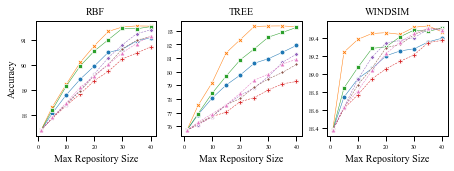

In [25]:
plot_metric('accuracy')

3
['RCStreamType-RBF' 'RCStreamType-TREE' 'RCStreamType-WINDSIM']
RCStreamType-RBF
RCStreamType-TREE
RCStreamType-WINDSIM


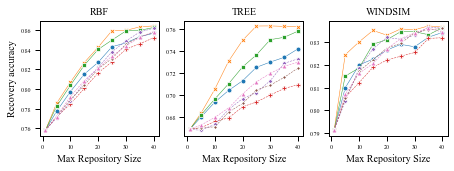

In [26]:
plot_metric('driftdetect_accuracy_50')

[<matplotlib.lines.Line2D object at 0x0000014A078A1D30>, <matplotlib.lines.Line2D object at 0x0000014A078A1A00>, <matplotlib.lines.Line2D object at 0x0000014A09FB5E50>] [<matplotlib.lines.Line2D object at 0x0000014A09FB56D0>, <matplotlib.lines.Line2D object at 0x0000014A049B5790>, <matplotlib.lines.Line2D object at 0x0000014A049B5580>, <matplotlib.lines.Line2D object at 0x0000014A07995250>] ['EP', '#E', 'AAC'] ['FIFO', 'LRU', 'Acc', 'DP']
--
--
--
--


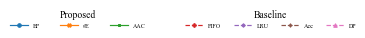

In [333]:
# PLOT LEGEND
figsize = get_plot_size(0.15, 1, 0.15, 1)
fig_leg, ax_leg = plt.subplots(figsize=figsize)


print(h_ours, h_theirs, l_ours, l_theirs)
for l in h_theirs:
    print(l.get_linestyle())
    # l.set_
ours = ax_leg.legend(h_ours, l_ours, 
                    # fancybox=True, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0.3, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
                    fancybox=True, markerscale=0.75, handlelength=3, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0, 0, 0.4, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
# ours.get_title().set_fontsize('14')
theirs = ax_leg.legend(h_theirs, l_theirs, 
                    # fancybox=True, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.6, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
                    fancybox=True, markerscale=0.75, handlelength=3, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.5, 0, 0.5, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
# theirs.get_title().set_fontsize('14')
# ours = m_fig.legend(h_ours, l_ours, 
#                     fancybox=True, ncol=len(h_ours), title = "proposed", bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.1)
# theirs = m_fig.legend(h_theirs, l_theirs, 
#                     fancybox=True, ncol=len(h_theirs), title = "baselines", bbox_to_anchor=(1, 1.02), loc="lower right", borderaxespad=0.1)
ax_leg.add_artist(ours)
# add the legend from the previous axes
# hide the axes frame and the x/y labels
ax_leg.axis('off')
# fig_leg.tight_layout()
fig_leg.savefig(output_location / f"{output_prefix}-SYN-{save_name}_legend_bw.pdf", bbox_inches='tight', pad_inches=0)

In [335]:
df_t = df.iloc[df.index.get_level_values('sens') != '0.02']
df_t = df_t.reset_index()
df_drift = df_t.merge(merge_df, how='right', right_on=["st", "cl", "mem_manage", "rep"], left_on = ["st", "cl", "mem_manage", "rep"])
df_drift['false alarms'] = df_drift['num_detections'] - df_drift['num_valid_drifts']
df_drift['cl'] = df_drift['cl'].astype(int)
df_drift

noise  nc hd ed  ha  ea   hp   epa                    st gradual  ...  \
0      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
1      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
2      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
3      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
4      0-0  25  3  1  15  15  0-5  5000      RCStreamType-RBF   False  ...   
...    ...  .. .. ..  ..  ..  ...   ...                   ...     ...  ...   
1287   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1288   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1289   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1290   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   
1291   0-0  25  3  1  15  15  0-5  5000  RCStreamType-WINDSIM   False  ...   

      memory  seed  num_drifts num_detections  num_valid_drifts avg_delay  \
0       -1.0  3342       375.0          756.0             353.0        -1   
1       -1.0  3342       375.0          720.0             346.0        -1   
2       -1.0  3896       375.0          502.0             386.0        -1   
3       -1.0  3896       375.0          511.0             374.0        -1   
4       -1.0  3896       375.0          503.0             379.0        -1   
...      ...   ...         ...            ...               ...       ...   
1287    -1.0  1483       375.0          512.0             288.0        -1   
1288    -1.0  1483       375.0          522.0             292.0        -1   
1289    -1.0  1483       375.0          511.0             289.0        -1   
1290    -1.0  1483       375.0          521.0             297.0        -1   
1291    -1.0  1483       375.0          518.0             295.0        -1   

     num_model_swaps  avg_delay_2                   seed_st  false alarms  
0                 10   455.573333      RCStreamType-RBF3342         403.0  
1                  2   499.413333      RCStreamType-RBF3342         374.0  
2                  3   322.320000      RCStreamType-RBF3896         116.0  
3                  2   409.792000      RCStreamType-RBF3896         137.0  
4                  3   344.085333      RCStreamType-RBF3896         124.0  
...              ...          ...                       ...           ...  
1287               9  1042.733333  RCStreamType-WINDSIM1483         224.0  
1288              12   986.197333  RCStreamType-WINDSIM1483         230.0  
1289              10  1026.288000  RCStreamType-WINDSIM1483         222.0  
1290              12  1004.642667  RCStreamType-WINDSIM1483         224.0  
1291               9   995.394667  RCStreamType-WINDSIM1483         223.0  

[1292 rows x 78 columns]

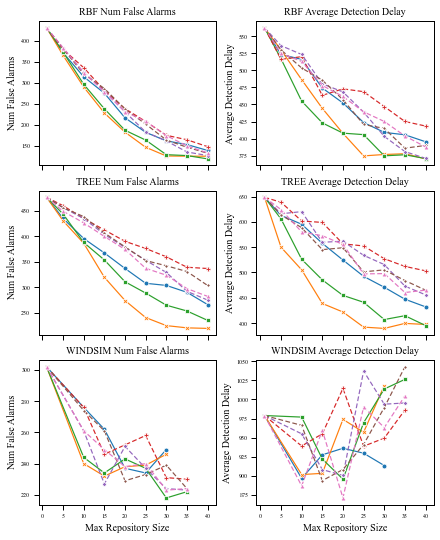

In [347]:
plot_df = df_drift
policy_map = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", "arf": "ARF"}
plot_df['memory policy'] = plot_df['mem_manage'].map(policy_map)

hue_order = [policy_map[x] for x in ['score', 'rA', 'auc', 'age', 'LRU', 'acc', 'div']]
m_fig, m_axs = plt.subplots(3, 2, figsize = get_plot_size(3, 2, 3, 2), sharex='all')
plot_row = 0
m_axs[plot_row, 0].set_title(f"RBF Num False Alarms")
m_axs[plot_row, 0].set_ylabel(f"Num False Alarms")
g = sns.lineplot(x = "cl", y = "false alarms", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"RBF Average Detection Delay")
m_axs[plot_row, 1].set_ylabel(f"Average Detection Delay")
g =sns.lineplot(x = "cl", y = "avg_delay_2", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()

plot_row = 1
m_axs[plot_row, 0].set_title(f"TREE Num False Alarms")
m_axs[plot_row, 0].set_ylabel(f"Num False Alarms")
g = sns.lineplot(x = "cl", y = "false alarms", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"TREE Average Detection Delay")
m_axs[plot_row, 1].set_ylabel(f"Average Detection Delay")
g =sns.lineplot(x = "cl", y = "avg_delay_2", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()

plot_row = 2
m_axs[plot_row, 0].set_title(f"WINDSIM Num False Alarms")
m_axs[plot_row, 0].set_ylabel(f"Num False Alarms")
m_axs[plot_row, 0].set_xlabel(f"Max Repository Size")
g = sns.lineplot(x = "cl", y = "false alarms", data = plot_df[plot_df['st'] == 'RCStreamType-WINDSIM'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"WINDSIM Average Detection Delay")
m_axs[plot_row, 1].set_ylabel(f"Average Detection Delay")
m_axs[plot_row, 1].set_xlabel(f"Max Repository Size")
g =sns.lineplot(x = "cl", y = "avg_delay_2", data = plot_df[plot_df['st'] == 'RCStreamType-WINDSIM'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()
m_fig.tight_layout()
m_fig.savefig(output_location / f"{output_prefix}-SYN-plot_U_lines.pdf", bbox_inches="tight")

## RESULTS - MAIN SYNTHETIC TEST

In [341]:
data_location = pathlib.Path(r"C:\PhDData\NH-shadow")
data_location.exists()

True

In [345]:
base_directory = data_location
skip_cache = False

cache_name = base_directory / "df_cache.csv"
if cache_name.exists() and not skip_cache:
    df = pd.read_csv(cache_name)
else:
    list_of_directories = {}
    print(pathlib.Path(base_directory))
    print(pathlib.Path(base_directory).exists())
    num_files_found = 0
    files_processed = 0
    list_of_directories = {}
    csv_files = list(base_directory.rglob('**/*.csv'))
    # print(csv_files)

    # info_names = ['noise', 'nc', 'hd', 'ed', 'ha', 'ea', 'hp', 'epa', 'st', 'gradual', 'drift_window']
    indexes = []
    values = []
    results = {}
    seen_dir = {}

    all_results = []
    for csv_filename in tqdm(csv_files):
        data_key, result = process_file(csv_filename, results)
        if data_key is not None:
            results[data_key] = result

    # df = pd.DataFrame(np.array(values), index=index, columns = list(result.keys()))
    df = pd.DataFrame.from_records(list(results.values()))
    # df.to_pickle(f'Mem_Manage_Results/{save_name}.pickle')
    # print(df.head())
    df.to_csv(cache_name)
df = df[df['sys_learner'] == "HN"]
print(df.shape)
df.head()

C:\PhDData\NH-shadow
True


  0%|          | 0/2407 [00:00<?, ?it/s]

(2209, 132)


accuracy  drift_accuracy_50  drift_km_50  drift_kt_50  drift_accuracy_100  \
0   87.6882           0.582101     0.075183     0.147578            0.625192   
1   87.6882           0.582101     0.075183     0.147578            0.625192   
2   87.6882           0.582101     0.075183     0.147578            0.625192   
3   87.6882           0.582101     0.075183     0.147578            0.625192   
4   87.6882           0.582101     0.075183     0.147578            0.625192   

   drift_km_100  drift_kt_100  drift_accuracy_250  drift_km_250  drift_kt_250  \
0      0.174797      0.228152              0.6998      0.338816      0.378972   
1      0.174797      0.228152              0.6998      0.338816      0.378972   
2      0.174797      0.228152              0.6998      0.338816      0.378972   
3      0.174797      0.228152              0.6998      0.338816      0.378972   
4      0.174797      0.228152              0.6998      0.338816      0.378972   

   ...  seed  sens  window  sys_learner  poisson     od  sm    merge  \
0  ...   320  0.05     175           HN       10  False  KT  acc.csv   
1  ...   320  0.05     175           HN       10  False  KT  acc.csv   
2  ...   320  0.05     175           HN       10  False  KT  acc.csv   
3  ...   320  0.05     175           HN       10  False  KT  acc.csv   
4  ...   320  0.05     175           HN       10  False  KT  acc.csv   

   run_noise  merge_similarity  
0          0               0.9  
1          0               0.9  
2          0               0.9  
3          0               0.9  
4          0               0.9  

[5 rows x 132 columns]

In [346]:
df.to_csv("NH-shadow_df.csv")

In [353]:
metric = "accuracy"
metrics = ["accuracy"]
iv = "mem_manage"
# ttestvar = None
# ttestvar = "mem_manage"
save_name = f"{iv}-{metric.replace(' ', '')}-NH-shadow"
st_levels = df['st'].unique()
df_t = df

In [349]:
# PLOT FIGURE
# metric = 'accuracy'
# metric = 'driftdetect_accuracy_50'
def plot_metric(metric):
    print(len(st_levels))
    num_sts = 3
    overall = df_t
    overall['creator'] = overall['mem_manage'].map(lambda x: "theirs" if x in ['acc', 'age', 'LRU', 'div'] else 'base' if x in ['arf', 'rcd'] else 'mine')
    overall['cl'] = overall['cl'].astype(int)
    unique_stream_types = overall['st'].unique()
    print(unique_stream_types)
    unique_stream_types = ['RCStreamType-RBF', 'RCStreamType-TREE', 'RCStreamType-WINDSIM']
    fig, axs = plt.subplots(1, len(unique_stream_types), figsize = get_plot_size(1, 1, 1, 1, width_multiplier=1))
    if len(unique_stream_types) < 2:
        axs = [axs]
    for st_i, st in enumerate(unique_stream_types):
        print(st)
        df_st = overall.loc[(overall['st'] == st) & (overall['cl'] >= 1)]
        try:
            h_ours, h_theirs, l_ours, l_theirs = plot_graph(df_st, st_i == 0, axs[st_i], fig, st_i == len(unique_stream_types) - 1, st, m=metric, show_ytitle=st_i == 0)
        except Exception as e:
            print(e)

    pic_suffix = ""
    # pic_suffix = "ss"
    fig.tight_layout()
    fig.savefig(output_location / f"{output_prefix}-SYN-{save_name}-{metric}{pic_suffix}_bw.pdf", bbox_inches='tight')

3
['RCStreamType-RBF' 'RCStreamType-TREE' 'RCStreamType-WINDSIM']
RCStreamType-RBF
RCStreamType-TREE
RCStreamType-WINDSIM


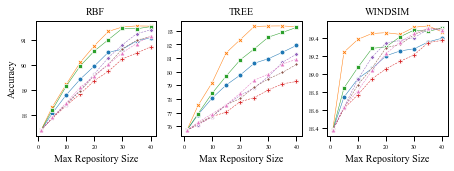

In [356]:
plot_metric('accuracy')

In [358]:
df_drift = df
df_drift['cl'] = df_drift['cl'].astype(int)
df_drift

accuracy  drift_accuracy_50  drift_km_50  drift_kt_50  \
0     87.68820           0.582101     0.075183     0.147578   
1     87.68820           0.582101     0.075183     0.147578   
2     87.68820           0.582101     0.075183     0.147578   
3     87.68820           0.582101     0.075183     0.147578   
4     87.68820           0.582101     0.075183     0.147578   
...        ...                ...          ...          ...   
2204  89.07230           0.705358    -0.111771    -0.402896   
2205  89.03460           0.709238    -0.097132    -0.384423   
2206  89.56640           0.714480    -0.077349    -0.359461   
2207  89.01265           0.709814    -0.094955    -0.381677   
2208  89.22545           0.710653    -0.091790    -0.377683   

      drift_accuracy_100  drift_km_100  drift_kt_100  drift_accuracy_250  \
0               0.625192      0.174797      0.228152            0.699800   
1               0.625192      0.174797      0.228152            0.699800   
2               0.625192      0.174797      0.228152            0.699800   
3               0.625192      0.174797      0.228152            0.699800   
4               0.625192      0.174797      0.228152            0.699800   
...                  ...           ...           ...                 ...   
2204            0.706729     -0.084484     -0.245839            0.763896   
2205            0.707868     -0.080274     -0.241003            0.763065   
2206            0.717610     -0.044249     -0.199618            0.774219   
2207            0.707444     -0.081840     -0.242803            0.765239   
2208            0.708265     -0.078806     -0.239316            0.766602   

      drift_km_250  drift_kt_250  ...  sens  window  sys_learner  poisson  \
0         0.338816      0.378972  ...  0.05     175           HN       10   
1         0.338816      0.378972  ...  0.05     175           HN       10   
2         0.338816      0.378972  ...  0.05     175           HN       10   
3         0.338816      0.378972  ...  0.05     175           HN       10   
4         0.338816      0.378972  ...  0.05     175           HN       10   
...            ...           ...  ...   ...     ...          ...      ...   
2204      0.113582      0.084284  ...  0.05     175           HN       10   
2205      0.110462      0.081061  ...  0.05     175           HN       10   
2206      0.152336      0.124318  ...  0.05     175           HN       10   
2207      0.118621      0.089489  ...  0.05     175           HN       10   
2208      0.123740      0.094778  ...  0.05     175           HN       10   

         od  sm    merge  run_noise  merge_similarity  creator  
0     False  KT  acc.csv          0               0.9   theirs  
1     False  KT  acc.csv          0               0.9   theirs  
2     False  KT  acc.csv          0               0.9     mine  
3     False  KT  acc.csv          0               0.9   theirs  
4     False  KT  acc.csv          0               0.9   theirs  
...     ...  ..      ...        ...               ...      ...  
2204  False  KT  acc.csv          0               0.9   theirs  
2205  False  KT  acc.csv          0               0.9   theirs  
2206  False  KT  acc.csv          0               0.9     mine  
2207  False  KT  acc.csv          0               0.9     mine  
2208  False  KT  acc.csv          0               0.9     mine  

[2209 rows x 133 columns]

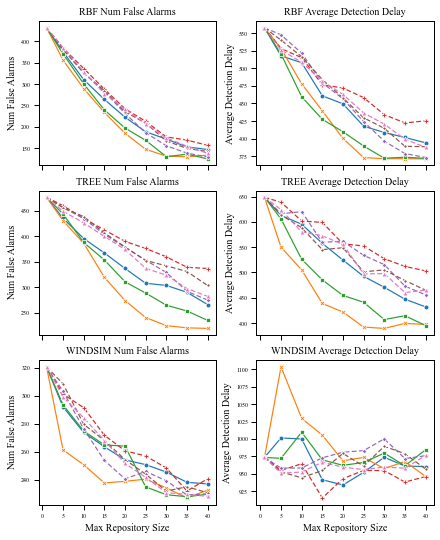

In [359]:
plot_df = df_drift
policy_map = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", "arf": "ARF"}
plot_df['memory policy'] = plot_df['mem_manage'].map(policy_map)

hue_order = [policy_map[x] for x in ['score', 'rA', 'auc', 'age', 'LRU', 'acc', 'div']]
m_fig, m_axs = plt.subplots(3, 2, figsize = get_plot_size(3, 2, 3, 2), sharex='all')
plot_row = 0
m_axs[plot_row, 0].set_title(f"RBF Num False Alarms")
m_axs[plot_row, 0].set_ylabel(f"Num False Alarms")
g = sns.lineplot(x = "cl", y = "false alarms", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"RBF Average Detection Delay")
m_axs[plot_row, 1].set_ylabel(f"Average Detection Delay")
g =sns.lineplot(x = "cl", y = "avg_delay_2", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()

plot_row = 1
m_axs[plot_row, 0].set_title(f"TREE Num False Alarms")
m_axs[plot_row, 0].set_ylabel(f"Num False Alarms")
g = sns.lineplot(x = "cl", y = "false alarms", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"TREE Average Detection Delay")
m_axs[plot_row, 1].set_ylabel(f"Average Detection Delay")
g =sns.lineplot(x = "cl", y = "avg_delay_2", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()

plot_row = 2
m_axs[plot_row, 0].set_title(f"WINDSIM Num False Alarms")
m_axs[plot_row, 0].set_ylabel(f"Num False Alarms")
m_axs[plot_row, 0].set_xlabel(f"Max Repository Size")
g = sns.lineplot(x = "cl", y = "false alarms", data = plot_df[plot_df['st'] == 'RCStreamType-WINDSIM'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"WINDSIM Average Detection Delay")
m_axs[plot_row, 1].set_ylabel(f"Average Detection Delay")
m_axs[plot_row, 1].set_xlabel(f"Max Repository Size")
g =sns.lineplot(x = "cl", y = "avg_delay_2", data = plot_df[plot_df['st'] == 'RCStreamType-WINDSIM'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], ci=None, style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[3:7]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()
m_fig.tight_layout()
m_fig.savefig(output_location / f"{output_prefix}-SYN-plot_U_lines.pdf", bbox_inches="tight")

## Memory experiment

In [15]:
data_location = data_path / "Memory_Management" / "Results" / "MainSynthetic"
data_location.exists()
with (data_location / "NHmem.pickle").open('rb') as f:
    df = pd.read_pickle(f)
df

accuracy  \
noise nc hd ed ha ea hp  epa  st                   gradual drift_window ml     cl mem_manage rep sens window sys_learner poisson od    sm  merge   run_noise             
0-0   25 3  1  15 15 0-5 5000 RCStreamType-RBF     False   0            arf    5  def        0   def  def    pyn         def     False def def     0          91.48340   
                                                                                             1   def  def    pyn         def     False def def     0          91.18220   
                                                                                             2   def  def    pyn         def     False def def     0          90.62500   
                                                                                             3   def  def    pyn         def     False def def     0          90.87885   
                                                                                             4   def  def    pyn         def     False def def     0          90.75020   
                                                                                             5   def  def    pyn         def     False def def     0          91.42735   
                                                                                             6   def  def    pyn         def     False def def     0          91.40225   
                                                                               25 def        7   def  def    pyn         def     False def def     0          92.87410   
                                                                               5  def        7   def  def    pyn         def     False def def     0          90.52575   
                                                                               15 def        8   def  def    pyn         def     False def def     0          92.34545   
                                                                               25 def        8   def  def    pyn         def     False def def     0          92.76480   
                                                                               35 def        8   def  def    pyn         def     False def def     0          92.90065   
                                                                               5  def        8   def  def    pyn         def     False def def     0          90.36510   
                                                                               15 def        9   def  def    pyn         def     False def def     0          93.13580   
                                                                               25 def        9   def  def    pyn         def     False def def     0          93.53725   
                                                                               35 def        9   def  def    pyn         def     False def def     0          93.68600   
                                                                               5  def        9   def  def    pyn         def     False def def     0          91.27110   
                                                                        system 15 rA         9   0.05 175    HN          10      False KT  acc.csv 0          90.31100   
                                                                               25 rA         9   0.05 175    HN          10      False KT  acc.csv 0          91.44540   
                                                                               35 rA         9   0.05 175    HN          10      False KT  acc.csv 0          91.61305   
                                                                               5  rA         9   0.05 175    HN          10      False KT  acc.csv 0          88.64975   
                              RCStreamType-TREE    False   0            arf    5  def        0   def  def    pyn         def     False def def     0          74.26360   
                                                                              

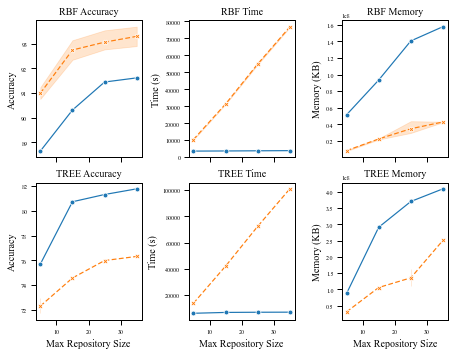

In [17]:
plot_df = df.reset_index()
plot_df['cl'] = plot_df['cl'].astype(int)
plot_df = plot_df[(plot_df['cl'] >= 5) & (plot_df['cl'] <= 35)]

policy_map = {'rA': "#E", "auc": "AAC", "score": "EP", "acc": "Acc", "age":"FIFO", "LRU":"LRU", "div":"DP", "def": "ARF"}
plot_df['memory policy'] = plot_df['mem_manage'].map(policy_map)

hue_order = [policy_map[x] for x in ['rA', 'def']]
m_fig, m_axs = plt.subplots(2, 3, figsize = get_plot_size(2, 1, 2, 1), sharex='all')
plot_row = 0
m_axs[plot_row, 0].set_title(f"RBF Accuracy")
m_axs[plot_row, 0].set_ylabel(f"Accuracy")
g = sns.lineplot(x = "cl", y = "accuracy", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[1:2]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"RBF Time")
m_axs[plot_row, 1].set_ylabel(f"Time (s)")
g =sns.lineplot(x = "cl", y = "time", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[1:2]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()

m_axs[plot_row, 2].set_title(f"RBF Memory")
m_axs[plot_row, 2].set_ylabel(f"Memory (KB)")
g =sns.lineplot(x = "cl", y = "memory", data = plot_df[plot_df['st'] == 'RCStreamType-RBF'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 2], style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[1:2]:
    l.set_dashes((4, 2))
m_axs[plot_row, 2].get_legend().remove()

plot_row = 1
m_axs[plot_row, 0].set_title(f"TREE Accuracy")
m_axs[plot_row, 0].set_ylabel(f"Accuracy")
m_axs[plot_row, 0].set_xlabel(f"Max Repository Size")
g = sns.lineplot(x = "cl", y = "accuracy", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 0], style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[1:2]:
    l.set_dashes((4, 2))
m_axs[plot_row, 0].get_legend().remove()
m_axs[plot_row, 1].set_title(f"TREE Time")
m_axs[plot_row, 1].set_ylabel(f"Time (s)")
m_axs[plot_row, 1].set_xlabel(f"Max Repository Size")
g =sns.lineplot(x = "cl", y = "time", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 1], style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[1:2]:
    l.set_dashes((4, 2))
m_axs[plot_row, 1].get_legend().remove()

m_axs[plot_row, 2].set_title(f"TREE Memory")
m_axs[plot_row, 2].set_ylabel(f"Memory (KB)")
m_axs[plot_row, 2].set_xlabel(f"Max Repository Size")
g =sns.lineplot(x = "cl", y = "memory", data = plot_df[plot_df['st'] == 'RCStreamType-TREE'], markers=True, dashes=False, hue = "memory policy", hue_order = hue_order, ax = m_axs[plot_row, 2], style="memory policy", style_order=hue_order)
lines = g.get_lines()
for l in lines[1:2]:
    l.set_dashes((4, 2))
m_axs[plot_row, 2].get_legend().remove()

m_fig.tight_layout()
m_fig.savefig(output_location / f"{output_prefix}-SYN-arf_comparison_eb.pdf", bbox_inches="tight")

['#E', 'ARF']
[<matplotlib.lines.Line2D object at 0x0000027792C59CD0>] [<matplotlib.lines.Line2D object at 0x0000027792C74DF0>] ['#E'] ['ARF']
-


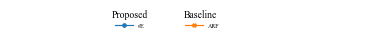

In [57]:
# PLOT LEGEND
h, l = g.get_legend_handles_labels()
print(l)
h_ours = [x[0] for x in zip(h, l) if x[1] in ['#E']]
h_theirs = [x[0] for x in zip(h, l) if x[1] in ['ARF']]

l_ours = [x[1] for x in zip(h, l) if x[1] in ['#E']]
l_theirs = [x[1] for x in zip(h, l) if x[1] in ['ARF']]
figsize = get_plot_size(0.15, 1, 0.15, 1)
fig_leg, ax_leg = plt.subplots(figsize=figsize)


print(h_ours, h_theirs, l_ours, l_theirs)
for l in h_ours:
    print(l.get_linestyle())
    # l.set_
ours = ax_leg.legend(h_ours, l_ours, 
                    # fancybox=True, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0.3, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
                    fancybox=True, markerscale=0.75, handlelength=3, ncol=len(h_ours), title = "Proposed", bbox_to_anchor=(0.3, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False)
# ours.get_title().set_fontsize('14')
theirs = ax_leg.legend(h_theirs, l_theirs, 
                    # fancybox=True, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.6, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
                    fancybox=True, markerscale=0.75, handlelength=3, ncol=len(h_theirs), title = "Baseline", bbox_to_anchor=(0.5, 0, 0.1, 1), loc="upper left", borderaxespad=0, mode='expand', frameon=False )
# theirs.get_title().set_fontsize('14')
# ours = m_fig.legend(h_ours, l_ours, 
#                     fancybox=True, ncol=len(h_ours), title = "proposed", bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.1)
# theirs = m_fig.legend(h_theirs, l_theirs, 
#                     fancybox=True, ncol=len(h_theirs), title = "baselines", bbox_to_anchor=(1, 1.02), loc="lower right", borderaxespad=0.1)
ax_leg.add_artist(ours)
# add the legend from the previous axes
# hide the axes frame and the x/y labels
ax_leg.axis('off')
# fig_leg.tight_layout()
fig_leg.savefig(output_location / f"{output_prefix}-arf-{save_name}_legend_bw.pdf", bbox_inches='tight', pad_inches=0)

# Chapter 5 - AiRStream

In [51]:
output_location = pathlib.Path("Chap5")
if not output_location.exists():
    output_location.mkdir(parents=True)
output_prefix = "ARSTM"

In [284]:
def get_confusion_matrix(preds, labels, levels):
    if levels is None:
        levels = set()
    yp_matches = {}
    for p,y in zip(preds, labels):
        try:
            p = int(p)
        except:
            p = int(p.replace('[', '').replace(']', ''))
        
        y = int(y)
        levels.add(p)
        levels.add(y)
        if y not in yp_matches:
            yp_matches[y] = {}
        if p not in yp_matches[y]:
            yp_matches[y][p] = 0
        yp_matches[y][p] += 1
    matrix = []
    for y in levels:
        lev = []
        matrix.append(lev)
        for p in levels:
            if y not in yp_matches:
                lev.append(0)
                continue
            if p in yp_matches[y]:
                lev.append(yp_matches[y][p])
            else:
                lev.append(0)
    return np.array(matrix).reshape(len(levels), len(levels))

### Figure - WD differences

In [115]:
# data_location = pathlib.Path(r"C:\RRTest-NoReturnNoScale\experiments")
data_location =data_path / "AiRStream" / "Intro" / "RRTest-NoReturnNoScale" / "experiments"
data_location.exists()

True

In [116]:
data_name = 'RangioraClean'
dataset_location = data_location / data_name
dataset_location.exists()


True

In [117]:

rows = []
levels = set(list(range(6)))
results_files = list(dataset_location.glob('**/*.csv'))
for result_path in tqdm(results_files):
    if data_name in str(result_path.stem) or 'full_link' in str(result_path.stem):
        continue
    rwf = result_path.parent.parent.parent.stem
    ti = int(result_path.parent.parent.stem)

    run_options = result_path.parent / f"{result_path.stem}_run_options.txt"
    run_options = json.load(run_options.open())
    aux_info = pd.read_csv(result_path.parent / f"{data_name}_aux.csv")
    dataset_info = pd.read_csv(result_path.parent / f"stream-{data_name}_dataset.csv")
    results_timestamps = pd.read_pickle(result_path.parent / f"time_index.pickle")
    res = pd.read_csv(result_path, header=None)

    # print(len(list(results_timestamps.values)))
    timestamps = list(results_timestamps.values)[-res.shape[0]:]
    # print(res.shape)
    # print(len(timestamps))
    res.index = pd.to_datetime(timestamps)
    aux_info['date_time'] = pd.to_datetime(aux_info['date_time'])
    full_results = pd.merge(res, aux_info, how = 'left', left_index=True, right_on='date_time')
    # test_feature = 'PRES'
    for test_feature in ['WD_1', 'WS_1', 'WD_3', 'WS_3', 'WD_4', 'WS_4']:
    # for test_feature in [x for x in list(full_results.columns) if 'WSPM' in str(x)]:
        # test_feature = 'WD_1'
        # print(full_results.columns)
        full_results[test_feature] = pd.qcut(full_results[test_feature], 12, labels=False, duplicates="drop")
        # print(full_results.head(5))
        # print(run_options)
        res = {}
        for v in full_results[test_feature].unique():
            # print(f"{test_feature}, {v}")
            subset = full_results.loc[full_results[test_feature] == v]
            prediction = subset[3]
            label = subset[4]

            cm = get_confusion_matrix(prediction, label, levels)
            # print(cm)
            row_sums = []
            for r in cm:
                row_sums.append(np.sum(r))
            # print(row_sums)
            col_sums = []
            for c in cm.transpose():
                col_sums.append(np.sum(c))
            # print(col_sums)
            
            total = sum(row_sums)
            # print(total)
            chance_same_sum = 0
            for i,r in enumerate(row_sums):
                col_chance = col_sums[i] / total
                # print(col_chance)
                chance_same_sum += col_chance * r
                # print(chance_same_sum)
            pc = chance_same_sum / total
            # print(pc)

            pa_sum = sum([r[i] for i,r in enumerate(cm)])
            pa = pa_sum / total

            kappa = (pa - pc) / (1 - pc)
            # print(kappa)
            res = {**res, "test_feature": test_feature, f"test_level": v, "pa": pa, f"pc": pc, f"kappa": kappa}

            row = {**run_options, "dataset_name": rwf, "dataset_target_index": ti, **res}

            rows.append(row)
    subset = full_results
    prediction = subset[3]
    label = subset[4]

    cm = get_confusion_matrix(prediction, label, levels)
    # print(cm)
    row_sums = []
    for r in cm:
        row_sums.append(np.sum(r))
    # print(row_sums)
    col_sums = []
    for c in cm.transpose():
        col_sums.append(np.sum(c))
    # print(col_sums)
    
    total = sum(row_sums)
    # print(total)
    chance_same_sum = 0
    for i,r in enumerate(row_sums):
        col_chance = col_sums[i] / total
        # print(col_chance)
        chance_same_sum += col_chance * r
        # print(chance_same_sum)
    pc = chance_same_sum / total
    # print(pc)

    pa_sum = sum([r[i] for i,r in enumerate(cm)])
    pa = pa_sum / total

    kappa = (pa - pc) / (1 - pc)
    # print(kappa)
    res = {**res, "test_feature": "all", f"test_level": 0, "pa": pa, f"pc": pc, f"kappa": kappa}

    row = {**run_options, "dataset_name": rwf, "dataset_target_index": ti, **res}

    rows.append(row)
df = pd.DataFrame(rows)

  0%|          | 0/754 [00:00<?, ?it/s]

C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (pa - pc) / (1 - pc)
C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (pa - pc) / (1 - pc)
C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (pa - pc) / (1 - pc)
C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (pa - pc) / (1 - pc)
C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (pa - pc) / (1 - pc)
C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (pa - pc) / (1 - pc)
C:\Users\Ben\AppData\Local\Temp/ipykernel_73804/122547819.py:64:

In [118]:
system_mapping = {'fsm': "AiRStream", 'OK': "OK", 'linear': "IDW"}

df_condition = df[df["test_feature"] == "WD_4"]
df_condition = df_condition[df_condition["ct"].isin(['linear', 'OK', 'fsm'])]
df_condition['System'] = df_condition['ct'].map(system_mapping)
df_condition['test_level_int'] = df_condition['test_level'].astype(int)
df_condition['System'].unique()


array(['IDW', 'OK', 'AiRStream'], dtype=object)

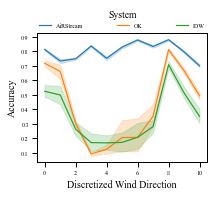

In [119]:

fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
sns.lineplot(data=df_condition, y="pa", x="test_level_int", hue="System", hue_order=system_mapping.values(), ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Discretized Wind Direction")
leg = ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=4, frameon=False, title="System")
fig.savefig(output_location / f"{output_prefix}-WD_diff.pdf", bbox_inches="tight")

### INTRO FIGURE - DISTRIBUTION

In [38]:
data_location =data_path / "AiRStream" / "Intro" / "Distribution"
data_location.exists()

True

In [39]:
data = [
    ("Rangiora", "Rangiora"),
    ("Arrowtown", "Arrowtown"),
    ("Beijing", "BMS"),
]

bins = [12, 35.4, 55.4, 150.4, 250.4]

In [43]:
# GET DATA
# We show two plots, one for the full set of data, all observations,
# and one for just observations we show for evaluation
rows_full = []
# name, fn = data[0]
for name, fn in data:
    df = pd.read_csv(data_location / f"{fn}_full.csv")
    df = df.dropna()
    if name == 'Rangiora':
        drop_sensor_IDS = [3, 7, 10]
        sensor_path = data_location / f"{name}_sensors.json"
        with sensor_path.open() as f:
            sensor_locations = json.load(f)
        sensor_names = [k for k in sensor_locations]
        drop_column_names = [sensor_names[x] for x in drop_sensor_IDS]
        print(df.columns)
        print(drop_column_names)
        # df = df.drop(columns=drop_column_names)
        for d in drop_column_names:
            df = df.drop(columns=d)

    sensors = json.load((data_location / f"{fn}_sensors.json").open())
    sensor_cols = [x for x in sensors.keys() if x not in drop_column_names]
    levels = pd.np.digitize(df[sensor_cols], bins = bins)
    vals, counts = np.unique(levels, return_counts=True)
    for v,c in zip(vals, counts):
        rows_full.append({"dataset": name, "AQI Level": v, "Observations": c})

# %%
rows_preq = []
for name, fn in data:
    df = pd.read_csv(data_location / f"{fn}_full.csv")
    df = df.dropna()
    df = df[df.index > 20000]
    if name == 'Rangiora':
        drop_sensor_IDS = [3, 7, 10]
        sensor_path = data_location / f"{name}_sensors.json"
        with sensor_path.open() as f:
            sensor_locations = json.load(f)
        sensor_names = [k for k in sensor_locations]
        drop_column_names = [sensor_names[x] for x in drop_sensor_IDS]
        print(df.columns)
        print(drop_column_names)
        # df = df.drop(columns=drop_column_names)
        for d in drop_column_names:
            df = df.drop(columns=d)
    print(df.index)
    sensors = json.load((data_location / f"{fn}_sensors.json").open())
    sensor_cols = [x for x in sensors.keys() if x not in drop_column_names]
    levels = pd.np.digitize(df[sensor_cols], bins = bins)
    vals, counts = np.unique(levels, return_counts=True)
    for v,c in zip(vals, counts):
        rows_preq.append({"dataset": name, "AQI Level": v, "Observations": c})

rows_full

Index(['date_time', '100', '101', '102', '106', '107', '109', '114', '115',
       '116', '120', '121', '122', '123', 'WS_1', 'WD_1', 'WS_3', 'WD_3',
       'WS_4', 'WD_4', 'lat_1', 'long_1', 'lat_2', 'long_2', 'lat_3',
       'long_3'],
      dtype='object')
['107', '116', '122']


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/1137653628.py:24: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  levels = pd.np.digitize(df[sensor_cols], bins = bins)


Index(['date_time', '100', '101', '102', '106', '107', '109', '114', '115',
       '116', '120', '121', '122', '123', 'WS_1', 'WD_1', 'WS_3', 'WD_3',
       'WS_4', 'WD_4', 'lat_1', 'long_1', 'lat_2', 'long_2', 'lat_3',
       'long_3'],
      dtype='object')
['107', '116', '122']
Int64Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009,
            20010,
            ...
            53800, 53801, 53802, 53803, 53804, 53805, 53806, 53807, 53808,
            53809],
           dtype='int64', length=33809)
Int64Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009,
            20010,
            ...
            62048, 62049, 62050, 62051, 62052, 62053, 62054, 62055, 62056,
            62057],
           dtype='int64', length=42057)


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/1137653628.py:50: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  levels = pd.np.digitize(df[sensor_cols], bins = bins)


Int64Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009,
            20010,
            ...
            27754, 27755, 27756, 27757, 27758, 27759, 27760, 27761, 27762,
            27763],
           dtype='int64', length=7763)


[{'dataset': 'Rangiora', 'AQI Level': 0, 'Observations': 390526},
 {'dataset': 'Rangiora', 'AQI Level': 1, 'Observations': 93887},
 {'dataset': 'Rangiora', 'AQI Level': 2, 'Observations': 33385},
 {'dataset': 'Rangiora', 'AQI Level': 3, 'Observations': 19177},
 {'dataset': 'Rangiora', 'AQI Level': 4, 'Observations': 1054},
 {'dataset': 'Rangiora', 'AQI Level': 5, 'Observations': 71},
 {'dataset': 'Arrowtown', 'AQI Level': 0, 'Observations': 402131},
 {'dataset': 'Arrowtown', 'AQI Level': 1, 'Observations': 23947},
 {'dataset': 'Arrowtown', 'AQI Level': 2, 'Observations': 4492},
 {'dataset': 'Arrowtown', 'AQI Level': 3, 'Observations': 3595},
 {'dataset': 'Arrowtown', 'AQI Level': 4, 'Observations': 214},
 {'dataset': 'Arrowtown', 'AQI Level': 5, 'Observations': 27},
 {'dataset': 'Beijing', 'AQI Level': 0, 'Observations': 46253},
 {'dataset': 'Beijing', 'AQI Level': 1, 'Observations': 78693},
 {'dataset': 'Beijing', 'AQI Level': 2, 'Observations': 42407},
 {'dataset': 'Beijing', 'AQI Le

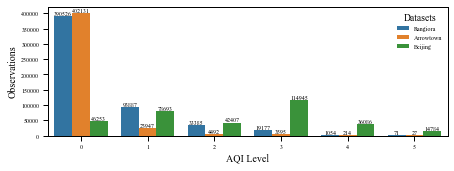

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


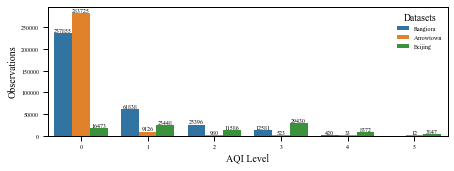

In [64]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + ax.get_ylim()[1]*0.005
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=SMALL_SIZE) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

figsize = get_plot_size(1, 1, 1, 1)
fig, ax = plt.subplots(figsize=figsize)
counts = pd.DataFrame.from_records(rows_full)
sns.barplot(x='AQI Level', y = "Observations", hue = "dataset", data = counts, ax = ax)
# sns.despine()
show_values_on_bars(ax)
# for index, row in counts.iterrows():
#     ax.text(row["AQI Level"],row.Observations, row.Observations, color='black', ha="center")
# ax.xaxis.set_tick_params(labelsize=40)
# ax.yaxis.set_tick_params(labelsize=40)
ax.legend(title="Datasets", frameon=False)
plt.tight_layout()
plt.savefig(output_location / f"{output_prefix}-distL-R2-full-levels.pdf")
plt.show()

figsize = get_plot_size(1, 1, 1, 1)
fig, ax = plt.subplots(figsize=figsize)
counts = pd.DataFrame.from_records(rows_preq)
sns.barplot(x='AQI Level', y = "Observations", hue = "dataset", data = counts, ax = ax)
# sns.despine()
show_values_on_bars(ax)
# for index, row in counts.iterrows():
#     ax.text(row["AQI Level"],row.Observations, row.Observations, color='black', ha="center")
# ax.xaxis.set_tick_params(labelsize=40)
# ax.yaxis.set_tick_params(labelsize=40)
ax.legend(title="Datasets", frameon=False, loc="upper right")
plt.tight_layout()
plt.savefig(output_location / f"{output_prefix}-distL-R2-preq-levels.pdf")
plt.show()

### INTRO FIGURES - MAPS

See data folder - plotting maps requires packages like cartopy
There is a script for each map

### PARAMETERS - SENSITIVITY

In [18]:
# data_location =data_path / "AiRStream" / "Intro" / "Distribution"
data_location = pathlib.Path(r"C:\PhDData") / "AiRStream" / "Sensitivity"
data_location.exists()

True

Window Size
Repair Sensitivity
Repair Period
k: # Inactive States Tested


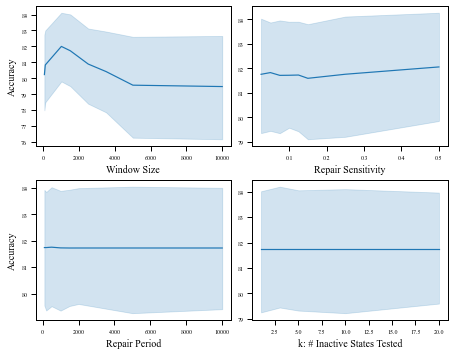

In [22]:
figs, axs = plt.subplots(ncols=2, nrows=2, figsize=get_plot_size(2, 1, 2, 1))
for i,test_feature in enumerate([('Window', 'window', 'Window Size'), ('css', 'css', 'Repair Sensitivity'), ('atp', 'atp', 'Repair Period'), ('an', 'an', 'k: # Inactive States Tested')]):
    print(test_feature[2])
    containing_folder = data_location / test_feature[0]
    all_files = list(containing_folder.glob("**/*-results.json"))
    formatted_results = {}
    for data_f in all_files:
        k = json.load(data_f.open())
        options_str = f"{str(data_f)[:-13]}_run_options.txt"
        key = json.load(pathlib.Path(options_str).open())
        index_names = key.keys()
        formatted_results[tuple(key.values())] = {**k}
        pointer = formatted_results[tuple(key.values())]
        pointer_keys = list(pointer.keys())
        for fk in pointer_keys:
            if type(pointer[fk]) is dict:
                keys = pointer[fk].keys()
                for sub_dict_key in keys:
                    full_key = f"{fk}-{sub_dict_key}"
                    pointer[full_key] = pointer[fk][sub_dict_key]
                del pointer[fk]
    results = pd.DataFrame.from_dict(formatted_results, orient='index').rename_axis(index_names)
    results['feature_set'] = results.index.get_level_values('ct').values
    results['feature_set'] = results['feature_set'] + results.index.get_level_values('backtrack').astype('str').values
    results['feature_set'] = results['feature_set'] + results.index.get_level_values('proactive_sensitivity').astype('str').values
    ours = results.loc[results['feature_set'] == 'fsmTrueTrue']
    ours = ours.reset_index(test_feature[1])
    # print(ours.groupby([test_feature[1]]).mean()['accuracy'])

    ax = axs.flatten()[i]
    sns.lineplot(x = test_feature[1], y = 'accuracy', data = ours, ax = ax)
    ax.set_xlabel(test_feature[2])
    if i % 2 == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.get_yaxis().label.set_visible(False)
    y_lim = ax.get_ylim()
    if y_lim[1] - y_lim[0] < 1:
        center = (y_lim[0] + y_lim[1]) / 2
        ax.set_ylim((center - 0.5, center + 0.5))
plt.tight_layout()
plt.savefig(output_location / f"{output_prefix}-RobustnessRWF_eb.pdf")
plt.show()

### CONDITION INFERENCE - POLAR DIAGRAM

In [78]:
# data_location =data_path / "AiRStream" / "Intro" / "Distribution"
data_location = pathlib.Path(r"C:\PhDData") / "AiRStream" / "RRTest-NoReturn"
data_location.exists()

True

In [79]:
def get_concept_accuracy_from_df(data):
    system_concept_accuracy_sum = 0
    concept_compositions = {}
    concept_purity = []
    do_purity = False
    if do_purity:
        for i, row in data.iterrows():
            sample_gt_concept = row['ground_truth_concept']
            sample_sys_concept = row['system_concept']
            reuse = sample_sys_concept in concept_compositions
            concept_com = concept_compositions.setdefault(sample_sys_concept, Counter())
            concept_com[sample_gt_concept] += 1
            purity_against_gt = concept_com[sample_gt_concept] / sum(concept_com.values())
            if reuse:
                system_concept_accuracy_sum += purity_against_gt
            concept_purity.append(purity_against_gt)
    else:
        system_concept_accuracy_sum = 0
        concept_purity = np.ones(data.shape[0])
    system_concept_accuracy = system_concept_accuracy_sum / data.shape[0]
    return system_concept_accuracy, np.array(concept_purity)

def get_concept_transparency_data(ground_truth, system, purity, merge_key):
    # print(ground_truth[:5])
    # print(system[:5])
    # print(purity[:5])

    gt_values, gt_total_counts = np.unique(ground_truth, return_counts = True)
    sys_values, sys_total_counts = np.unique(system, return_counts = True)

    # print(gt_values)
    # print(sys_values)
    matrix = np.array([ground_truth, system, purity]).transpose()
    # print(matrix[:5])
    # Key = (gt_concept, sys_concept)
    recall_values = {}
    precision_values = {}
    gt_results = {}
    sys_results = {}
    overall_results = {
        'Max Recall': 0,
        'Max Precision': 0,
        'Precision for Max Recall': 0,
        'Recall for Max Precision': 0,
        'f1' : 0,
        'MR by System': 0,
        'MP by System': 0,
        'PMR by System': 0,
        'RMP by System': 0,
        'f1 by System': 0,
        'Num Good System Concepts': 0,
    }
    gt_proportions = {}
    sys_proportions = {}
    
    for gt_i, gt in enumerate(gt_values):
        # print(f"gt = {gt}")
        gt_total_count = gt_total_counts[gt_i]
        # print(f'gt_total_count {gt_total_count}')
        gt_mask = matrix[matrix[:,0] == gt]
        sys_by_gt_values, sys_by_gt_counts = np.unique(gt_mask[:, 1], return_counts = True)
        # print(f"GT SHOULD BE THE SAME {gt_total_count}:{gt_mask.shape[0]}")
        gt_proportions[gt] = gt_mask.shape[0] / matrix.shape[0]
        max_recall = None
        max_recall_sys = None
        max_precision = None
        max_precision_sys = None
        max_f1 = None
        max_f1_sys = None
        for sys_i,sys in enumerate(sys_by_gt_values):
            sys_by_gt_count = sys_by_gt_counts[sys_i]
            sys_total_count = sys_total_counts[sys_values.tolist().index(sys)]
            # print(f'sys_total_count {sys_total_count}')
            # recall_rows = gt_mask[(gt_mask[:,1] == sys)]
            # print(f"SYS SHOULD BE THE SAME {sys_by_gt_count}:{recall_rows.shape[0]}")

            if gt_total_count != 0:
                recall = sys_by_gt_count / gt_total_count
            else:
                recall = 1

            recall_values[(gt, sys)] = recall

            # sys_mask = matrix[matrix[:,1] == sys]
            # sys_proportions[sys] = sys_mask.shape[0] / matrix.shape[0]
            sys_proportions[sys] = sys_total_count / matrix.shape[0]
            # precision_rows = sys_mask[sys_mask[:,0] == gt]
            # if sys_mask.shape[0] != 0:
            #     precision = precision_rows.shape[0] / sys_mask.shape[0]
            # else:
            #     precision = 1
            if sys_total_count != 0:
                precision = sys_by_gt_count / sys_total_count
            else:
                precision = 1
            precision_values[(gt, sys)] = precision

            f1 = 2 * ((recall * precision) / (recall + precision))

            if max_recall == None or recall > max_recall:
                max_recall = recall
                max_recall_sys = sys
            if max_precision == None or precision > max_precision:
                max_precision = precision
                max_precision_sys = sys
            if max_f1 == None or f1 > max_f1:
                max_f1 = f1
                max_f1_sys = sys
        precision_max_recall = precision_values[(gt, max_recall_sys)]
        recall_max_precision = recall_values[(gt, max_precision_sys)]
        # print(" GT recalls")
        # print(recall_values)
        # print("GT precisions")
        # print(precision_values)
        gt_result = {
            'Max Recall': max_recall,
            'Max Precision': max_precision,
            'Precision for Max Recall': precision_max_recall,
            'Recall for Max Precision': recall_max_precision,
            'f1': max_f1
        }
        # print(" GT result")
        # print(gt_result)
        gt_results[gt] = gt_result
        overall_results['Max Recall'] += max_recall
        overall_results['Max Precision'] += max_precision
        overall_results['Precision for Max Recall'] += precision_max_recall
        overall_results['Recall for Max Precision'] += recall_max_precision
        overall_results['f1'] += max_f1

    
    for sys in sys_values:
        max_recall = None
        max_recall_gt = None
        max_precision = None
        max_precision_gt = None
        max_f1 = None
        max_f1_sys = None
        for gt in gt_values:
            if (gt, sys) not in recall_values:
                continue
            if (gt, sys) not in precision_values:
                continue
            recall = recall_values[(gt, sys)]
            precision = precision_values[(gt, sys)]

            f1 = 2 * ((recall * precision) / (recall + precision))

            if max_recall == None or recall > max_recall:
                max_recall = recall
                max_recall_gt = gt
            if max_precision == None or precision > max_precision:
                max_precision = precision
                max_precision_gt = gt
            if max_f1 == None or f1 > max_f1:
                max_f1 = f1
                max_f1_sys = sys

        precision_max_recall = precision_values[(max_recall_gt, sys)]
        recall_max_precision = recall_values[(max_precision_gt, sys)]   
        sys_result = {
            'Max Recall': max_recall,
            'Max Precision': max_precision,
            'Precision for Max Recall': precision_max_recall,
            'Recall for Max Precision': recall_max_precision,
            'f1': max_f1
        }
        # print("Sys result")
        # print(sys_result)
        sys_results[sys] = sys_result     
        overall_results['MR by System'] += max_recall * sys_proportions[sys]
        overall_results['MP by System'] += max_precision * sys_proportions[sys]
        overall_results['PMR by System'] += precision_max_recall * sys_proportions[sys]
        overall_results['RMP by System'] += recall_max_precision * sys_proportions[sys]
        overall_results['f1 by System'] += max_f1 * sys_proportions[sys]
        if max_recall > 0.75 and precision_max_recall > 0.75:
            overall_results['Num Good System Concepts'] += 1

    overall_results['Max Recall'] /= gt_values.size
    overall_results['Max Precision'] /= gt_values.size
    overall_results['Precision for Max Recall'] /= gt_values.size
    overall_results['Recall for Max Precision'] /= gt_values.size
    overall_results['f1'] /= gt_values.size
    # overall_results['MR by System'] /= sys_values.size
    # overall_results['MP by System'] /= sys_values.size
    # overall_results['PMR by System'] /= sys_values.size
    # overall_results['RMP by System'] /= sys_values.size
    return gt_results, overall_results
def get_confusion_matrix(preds, labels, levels):
    if levels is None:
        levels = set()
    yp_matches = {}
    for p,y in zip(preds, labels):
        try:
            p = int(p)
        except:
            p = int(p.replace('[', '').replace(']', ''))
        
        y = int(y)
        levels.add(p)
        levels.add(y)
        if y not in yp_matches:
            yp_matches[y] = {}
        if p not in yp_matches[y]:
            yp_matches[y][p] = 0
        yp_matches[y][p] += 1
    matrix = []
    for y in levels:
        lev = []
        matrix.append(lev)
        for p in levels:
            if y not in yp_matches:
                lev.append(0)
                continue
            if p in yp_matches[y]:
                lev.append(yp_matches[y][p])
            else:
                lev.append(0)
    return np.array(matrix).reshape(len(levels), len(levels))

In [80]:
data_name = "RangioraClean"
target_index = -1
target_seed = -1
experiment_directory = data_location / 'experiments' / data_name
if target_index >= 0:
    experiment_directory = experiment_directory / str(target_index)
if target_seed >= 0:
    experiment_directory = experiment_directory / str(target_seed)
print(experiment_directory)
data_name = "RangioraClean"

C:\PhDData\AiRStream\RRTest-NoReturn\experiments\RangioraClean


In [83]:
import sklearn
import sklearn.ensemble
rows = []
cache_name = experiment_directory / f"{data_name}-condition-data.pickle"
if cache_name.exists():
    df = pd.from_pickle(cache_name)
else:
    results_files = list(experiment_directory.glob('**/*.csv'))
    top_result_path_f1_score = None
    top_result_path = None
    path_to_score = []
    # for result_path in picked_results_files:
    for result_path in tqdm(results_files):
        # print(result_path)
        if data_name in str(result_path.stem) or 'full_link' in str(result_path.stem) or 'drift_info' in str(result_path.stem) or 'stream' in str(result_path.stem) or 'aux' in str(result_path.stem):
            continue
        
        rwf = result_path.parent.parent.parent.stem
        seed = int(result_path.parent.stem)
        try:
            ti = int(result_path.parent.parent.stem)
        except:
            ti = 0
            rwf = result_path.parent.parent.stem

        # df_info_path = result_path.parent / f"df_info.json"
        # df_info = json.load(df_info_path.open())
        # print(df_info)
        # if df_info['target_sensor'] != "102":
        #     continue
        run_options = result_path.parent / f"{result_path.stem}_run_options.txt"
        run_options = json.load(run_options.open())
        results_json_path = result_path.parent / f"{result_path.stem}-results.json"
        try:
            results_from_json = json.load(results_json_path.open())
        except:
            results_from_json = {}
        results_json_path = result_path.parent / f"{result_path.stem}.csv-results.json"
        try:
            results_from_json = json.load(results_json_path.open())
        except:
            results_from_json = results_from_json
        try:
            aux_info = pd.read_csv(result_path.parent / f"{data_name}_aux.csv")
        except:
            aux_info = pd.read_csv(result_path.parent / f"drift_info.csv")
        try:
            dataset_info = pd.read_csv(result_path.parent / f"stream-{data_name}_dataset.csv")
        except:
            with open(result_path.parent / f"stream-{seed}.csv") as f:
                data = f.read()
                dataset_info = pd.read_csv(io.StringIO(data.replace(',\n','\n')), header = None)
            # dataset_info = pd.read_csv(result_path.parent / f"stream-{seed}.csv", header = None)
        try:
            results_timestamps = pd.read_pickle(result_path.parent / f"time_index.pickle")
            res = pd.read_csv(result_path, header=None)

            # print(len(list(results_timestamps.values)))
            timestamps = list(results_timestamps.values)[-res.shape[0]:]
            # print(res.shape)
            # print(len(timestamps))
            res.index = pd.to_datetime(timestamps)
            aux_info['date_time'] = pd.to_datetime(aux_info['date_time'])
            full_results = pd.merge(res, aux_info, how = 'left', left_index=True, right_on='date_time')
        except:
            res = pd.read_csv(result_path, header=None)
            full_results = pd.merge(res, aux_info, how = 'left', left_index=True, right_index=True)

        # test_feature = 'PRES'
        data = {}

        

        for test_feature,feature_type in [('WD_1', 'Wind Direction'), ('WS_1', 'Wind Speed'), ('WD_3', 'Wind Direction'), ('WS_3', 'Wind Speed'), ('WD_4', 'Wind Direction'), ('WS_4', 'Wind Direction')]:
        # for test_feature,feature_type in [('wd', 'Wind Direction'), ('WSPM', 'Wind Speed'), ("TEMP", "Temperature"), ("PRES", "Pressure"), ('DEWP', 'Dew Point')]:
        # for test_feature,feature_type in [('ground_truth_concept', 'Ground Truth')]:
            # test_feature = 'WD_1'
            # print(full_results.columns)
            if len(np.unique(full_results[test_feature])) > 16:
                full_results[test_feature] = pd.qcut(full_results[test_feature], 4, labels=False, duplicates="drop").values
            else:
                full_results[test_feature] = full_results[test_feature].astype("str")
            # full_results[test_feature] = pd.qcut(full_results[test_feature], 8, labels=False, duplicates="drop")
            # print(full_results.head(2))
            
            prediction_target = full_results[test_feature].to_numpy()
            features = dataset_info.iloc[-res.shape[0]:, :-1].to_numpy()
            if dataset_info.isnull().values.any():
                features = dataset_info.iloc[-res.shape[0]:, :-2].to_numpy()

            # print("features")
            # print(features[:10])
            # print(features.shape)
            # x = dataset_info[list(dataset_info.drop(list(dataset_info.columns)[-1], axis = 1).columns)].to_numpy()
            # print(x == features)
            # break
            # print(res.head(2))
            # print(dataset_info.head(2))
            # print(res.shape)
            # print(dataset_info.shape)
            states = res[6].to_numpy()
            # print(prediction_target)
            # print(states)
            # print(features.shape)
            # print(states.shape)
            state_and_features = np.c_[features, states]
            # print(state_and_features.shape)
            
            feature_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10,n_jobs=-1,max_depth=15)
            state_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
            statefeature_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10,n_jobs=-1,max_depth=15)
            dummy = sklearn.dummy.DummyClassifier(strategy = "prior")

            average_reuse_purity, concept_purity = get_concept_accuracy_from_df(pd.DataFrame.from_dict({'system_concept': states, 'ground_truth_concept': prediction_target}))
            # print(average_reuse_purity, concept_purity)
            gt_results, overall_results_a = get_concept_transparency_data(prediction_target , states , concept_purity, None)
            # print(gt_results)
            # print(overall_results_a)

            ds = []
            fs = []
            ss = []
            fss = []
            for i in range(1):
                # dummy_score = sklearn.model_selection.cross_val_score(dummy, prediction_target, prediction_target, scoring='accuracy', cv = 3)
                # feature_score = sklearn.model_selection.cross_val_score(feature_model, features, prediction_target, scoring='accuracy', cv = 3)
                # state_score = sklearn.model_selection.cross_val_score(state_model, states.reshape(-1, 1), prediction_target, scoring='accuracy', cv = 3)
                # statefeature_score = sklearn.model_selection.cross_val_score(statefeature_model, state_and_features, prediction_target, scoring='accuracy', cv = 3)
                # print(feature_score)
                # print(statefeature_score)
                # ds.append(np.mean(dummy_score))
                # fs.append(np.mean(feature_score))
                # ss.append(np.mean(state_score))
                # fss.append(np.mean(statefeature_score))

                fs.append(0)
                fss.append(0)

            # ds = full_results[f"link-{test_feature}-dummy_score"]
            # ds = full_results[f"link-{test_feature}-dummy_score"]
            # print(fs)
            # print(fss)
            # break
            for k in overall_results_a:
                data[f"{test_feature}-{k}"] = overall_results_a[k]
            data[f"{test_feature}-state_feature"] = np.mean(fss)
            data[f"{test_feature}-fs_test"] = np.mean(fs)
            # data = {**data, "test_feature": test_feature, "dummy": np.mean(ds), "feature": np.mean(fs), "state": np.mean(ss), "state_feature": np.mean(fss)}

        row = {**run_options, "dataset_name": rwf, "dataset_target_index": ti, **data}
        for k in results_from_json:
            if not isinstance(results_from_json[k],dict):
                row[k] = results_from_json[k]
            else:
                for rk in results_from_json[k]:
                    row[f"{k}-{rk}"] = results_from_json[k][rk]
        # print(row)
        # if top_result_path_f1_score is None or top_result_path_f1_score < row['ground_truth_concept-f1']:
        #     top_result_path_f1_score = row['ground_truth_concept-f1']
        # if top_result_path_f1_score is None or top_result_path_f1_score < row['wd-f1'] + row['WSPM-f1']:
        #     top_result_path_f1_score = row['wd-f1'] + row['WSPM-f1']
        if top_result_path_f1_score is None or top_result_path_f1_score < row['WD_4-f1'] + row['WS_4-f1']:
            top_result_path_f1_score = row['WD_4-f1'] + row['WS_4-f1']
            top_result_path = result_path
        path_to_score.append([result_path, row['WD_1-f1'] + row['WS_1-f1']])
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_pickle(cache_name)

  0%|          | 0/546 [00:00<?, ?it/s]

In [84]:
df['feature_set'] = df['ct'].values
df['feature_set'] = df['feature_set'] + df['backtrack'].astype('str').values
df['feature_set'] = df['feature_set'] + df['proactive_sensitivity'].astype('str').values
df['feature_set'].loc[df['feature_set'].str.contains('linear')] = 'linear'
df['feature_set'].loc[df['feature_set'].str.contains('temporal')] = 'temporal'

df.head()

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


directory  header  \
0  D:\Test\RepairResearch\real_world_data\experim...    True   
1  D:\Test\RepairResearch\real_world_data\experim...    True   
2  D:\Test\RepairResearch\real_world_data\experim...    True   
3  D:\Test\RepairResearch\real_world_data\experim...    True   
4  H:\PhDTest\RRTest-NoReturn\experiments\Rangior...    True   

                                            filename  backtrack  \
0                                                arf      False   
1                                                lin      False   
2                                               norm      False   
3                                                 OK      False   
4  sys-fsm-cl_-1-an_5-w_100-sdp_500-msm_1#5-atl_1...       True   

   proactive_sensitivity  cl  an  window  sdp  msm  ...  \
0                  False  -1  -1      -1   -1 -1.0  ...   
1                  False  -1  -1      -1   -1 -1.0  ...   
2                  False  -1  -1      -1   -1 -1.0  ...   
3                  False  -1  -1      -1   -1 -1.0  ...   
4                   True  -1   5     100  500  1.5  ...   

   Precision for Max Recall_alt  Recall for Max Precision_alt  f1_alt  \
0                           NaN                           NaN     NaN   
1                           NaN                           NaN     NaN   
2                           NaN                           NaN     NaN   
3                           NaN                           NaN     NaN   
4                           0.0                           0.0     0.0   

   MR by System_alt  MP by System_alt PMR by System_alt  RMP by System_alt  \
0               NaN               NaN               NaN                NaN   
1               NaN               NaN               NaN                NaN   
2               NaN               NaN               NaN                NaN   
3               NaN               NaN               NaN                NaN   
4               0.0               0.0               0.0                0.0   

  f1 by System_alt Num Good System Concepts_alt     feature_set  
0              NaN                          NaN   arfFalseFalse  
1              NaN                          NaN          linear  
2              NaN                          NaN  normFalseFalse  
3              NaN                          NaN    OKFalseFalse  
4              0.0                          0.0     fsmTrueTrue  

[5 rows x 271 columns]

In [85]:
kappa_df = df

#%%
kappa_index = df.set_index(list(index_names)).drop('feature_set', axis = 1)

merged = results.join(kappa_index, rsuffix='_right')
merged.head()

accuracy  \
directory                                          header filename                                           backtrack proactive_sensitivity cl an window sdp msm atl atp  bs   csd  css   ct  seed gitcommit              
/ds/RealWorld/Sensitivity/an/experiments/Rangio... True   sys-fsm-cl_-1-an_1-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 1  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e    78.470144   
                                                          sys-fsm-cl_-1-an_10-w_1500-sdp_500-msm_1#5-atl_... True      True                  -1 10 1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e    78.470144   
                                                          sys-fsm-cl_-1-an_20-w_1500-sdp_500-msm_1#5-atl_... True      True                  -1 20 1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e    78.470144   
                                                          sys-fsm-cl_-1-an_3-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 3  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e    78.470144   
                                                          sys-fsm-cl_-1-an_5-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 5  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e    78.470144   

                                                                                                                                                                                                               drift_accuracy_50  \
directory                                          header filename                                           backtrack proactive_sensitivity cl an window sdp msm atl atp  bs   csd  css   ct  seed gitcommit                      
/ds/RealWorld/Sensitivity/an/experiments/Rangio... True   sys-fsm-cl_-1-an_1-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 1  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e                    0   
                                                          sys-fsm-cl_-1-an_10-w_1500-sdp_500-msm_1#5-atl_... True      True                  -1 10 1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e                    0   
                                                          sys-fsm-cl_-1-an_20-w_1500-sdp_500-msm_1#5-atl_... True      True                  -1 20 1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e                    0   
                                                          sys-fsm-cl_-1-an_3-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 3  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e                    0   
                                                          sys-fsm-cl_-1-an_5-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 5  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e                    0   

                                                                                                                                                                                                               drift_km_50  \
directory                                          header filename                                           backtrack proactive_sensitivity cl an window sdp msm atl atp  bs   csd  css   ct  seed gitcommit                
/ds/RealWorld/Sensitivity/an/experiments/Rangio... True   sys-fsm-cl_-1-an_1-w_1500-sdp_500-msm_1#5-atl_1... True      True                  -1 1  1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e              0   
                                                          sys-fsm-cl_-1-an_10-w_1500-sdp_500-msm_1#5-atl_... True      True                  -1 10 1500   500 1.5 1.0 2000 0.05 0.05 0.125 fsm 2504 244a60e              0   
                                                          sys-fsm-cl_-1-an_20-w_1500-sdp_500-msm_1#5-atl_... True      True                  -1 20 1500   500 1.5 1.0 2000 0.05 0.05 0

[[WindowsPath('C:/PhDData/AiRStream/RRTest-NoReturn/experiments/RangioraClean/11/2504/sys-fsm-cl_-1-an_5-w_2500-sdp_500-msm_1#5-atl_1-atp_2000-bs_0#05-csd_0#005-css_0#1-False-False-0.csv'), 1.1573891523675786], [WindowsPath('C:/PhDData/AiRStream/RRTest-NoReturn/experiments/RangioraClean/8/2504/sys-fsm-cl_-1-an_5-w_2500-sdp_500-msm_1#5-atl_1-atp_1000-bs_0#05-csd_0#005-css_0#125-True-True-0.csv'), 1.1743689464014841], [WindowsPath('C:/PhDData/AiRStream/RRTest-NoReturn/experiments/RangioraClean/8/2504/sys-fsm-cl_-1-an_5-w_2500-sdp_500-msm_1#5-atl_1-atp_2000-bs_0#05-csd_0#005-css_0#1-False-False-0.csv'), 1.1743689464014841], [WindowsPath('C:/PhDData/AiRStream/RRTest-NoReturn/experiments/RangioraClean/8/2504/sys-fsm-cl_-1-an_5-w_1500-sdp_500-msm_1#5-atl_1-atp_1000-bs_0#05-csd_0#005-css_0#125-True-True-0.csv'), 1.1805839064122166], [WindowsPath('C:/PhDData/AiRStream/RRTest-NoReturn/experiments/RangioraClean/8/2504/sys-fsm-cl_-1-an_5-w_1500-sdp_500-msm_1#5-atl_1-atp_2000-bs_0#05-csd_0#005-css

C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/1953669919.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['angle'] = (90 - (wind_data['wd']))
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/1953669919.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['angle'] = wind_data['angle'] % 360
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/1953669919.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

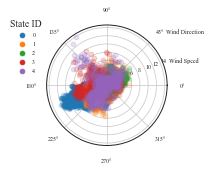

In [115]:
top_result_path_copy = top_result_path
path_to_score.sort(key = lambda x : x[1])
#%%
print(path_to_score[-5:])
top_result_path = path_to_score[-8][0]
print(top_result_path)

# %%
run_options = top_result_path.parent / f"{top_result_path.stem}_run_options.txt"
run_options = json.load(run_options.open())
aux_info = pd.read_csv(top_result_path.parent / f"{data_name}_aux.csv")
dataset_info = pd.read_csv(top_result_path.parent / f"stream-{data_name}_dataset.csv")
results_timestamps = pd.read_pickle(top_result_path.parent / f"time_index.pickle")
res = pd.read_csv(top_result_path, header=None)

# print(len(list(results_timestamps.values)))
timestamps = list(results_timestamps.values)[-res.shape[0]:]
# print(res.shape)
# print(len(timestamps))
res.index = pd.to_datetime(timestamps)
aux_info['date_time'] = pd.to_datetime(aux_info['date_time'])
full_results = pd.merge(res, aux_info, how = 'left', left_index=True, right_on='date_time')
full_results

# %%
states = full_results[6]
ws = full_results['WS_1']
wd = full_results['WD_1']

wind_data = full_results[[6, 'WS_1', 'WD_1']]
wind_data.columns = ['Model ID', 'ws', 'wd']
import math
wind_data['angle'] = (90 - (wind_data['wd']))
wind_data['angle'] = wind_data['angle'] % 360
wind_data['rads'] = wind_data['angle'] * math.pi
wind_data['rads'] = wind_data['rads'] / 180
wind_data['x'] = np.cos(wind_data['rads']) * wind_data['ws']
wind_data['y'] = np.sin(wind_data['rads']) * wind_data['ws']
# wind_data['state'] = wind_data['state'].astype('str')
wind_data

# %%
# sns.set_style('ticks')
# sns.scatterplot(x = 'x', y = 'y', hue = 'Model ID', data = wind_data, palette=sns.color_palette(palette='Accent', n_colors=len(wind_data['Model ID'].unique())), alpha = 0.2)
# plt.savefig("R-ti2-s2504-w100-WD_1.pdf", figsize=(20,15))

# %%
fig = plt.figure(figsize=get_plot_size(1, 2, 1, 1))
ax = plt.subplot(111, polar=True)
colors = sns.color_palette(palette='tab10', n_colors=len(wind_data['Model ID'].unique()))
for i,x in enumerate(wind_data['Model ID'].unique()):
    slice_df = wind_data.loc[wind_data['Model ID'] == x]
    plt.scatter(x=[x for x in slice_df['rads'].values], y=slice_df['ws'].values, color = colors[i], alpha = 0.2, label = x, rasterized = True)
leg = ax.legend(loc='upper right', bbox_to_anchor=(0, 1.1), title = "State ID", frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.text(0.35, 16, "Wind Speed")
ax.text(0.725, 19, "Wind Direction")
plt.tight_layout()
plt.savefig(output_location / f"{output_prefix}-polar-R-ti2-s2504-w100-WD_1_R.pdf", bbox_inches="tight")

### MEMORY MANAGEMENT - AiRSTream

In [291]:
data_location = data_path / "Overall" / "select_mem_l2"
data_location.exists()

True

  0%|          | 0/8640 [00:00<?, ?it/s]

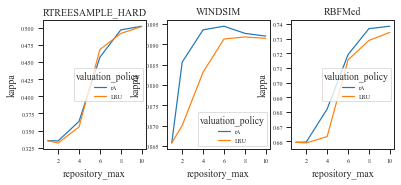

In [294]:
results_files = list(data_location.rglob('results*'))
results = []
for rp in tqdm(results_files):
    result = json.load(rp.open('r'))
    results.append(result)

df = pd.DataFrame(results)


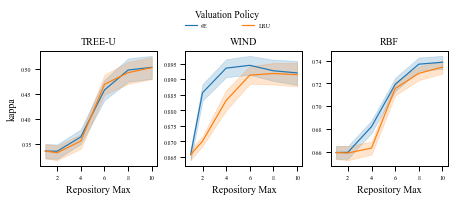

In [52]:


data_names = ['RTREESAMPLE_HARD', 'WINDSIM', 'RBFMed']
data_name_map = {
    "RTREESAMPLE_HARD": "TREE-U",
    "WINDSIM" : "WIND",
    "RBFMed": "RBF"
}
label_map = {
    "rA": "#E",
    "LRU": "LRU"
}
# classifier = 'ficsum'
# classifier = 'cc'
# classifier = 'advantage'
classifier = 'airstream'
fig, axs = plt.subplots(1, len(data_names), figsize=get_plot_size(1, 1, 1, 1), sharey=False)
if len(data_names) == 1:
    axs = [axs]
for i, dn in enumerate(data_names):
    dn_df = df[df['data_name'] == dn]
    dn_df = dn_df[dn_df['classifier'] == classifier]
    ax = axs[i]
    g = sns.lineplot(data=dn_df, x='repository_max', y='kappa', hue='valuation_policy', hue_order=['rA', 'LRU'], ax=ax)
    h, l = g.get_legend_handles_labels()
    ax.legend().remove()
    if i > 0:
        ax.get_yaxis().label.set_visible(False)
    ax.set_xlabel("Repository Max")
    ax.set_title(data_name_map[dn])
l = [label_map[x] for x in l]
fig.legend(h, l, bbox_to_anchor=(0.4,1.0,0.2,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=4, frameon=False, title="Valuation Policy")
fig.tight_layout()
# plt.show()
plt.savefig(output_location / f"{output_prefix}-mem_management_2.pdf", bbox_inches="tight")

# CHAPTER 6 - FiCSUM

In [53]:
output_location = pathlib.Path("Chap6")
if not output_location.exists():
    output_location.mkdir(parents=True)
output_prefix = "FICSM"

In [54]:
def fs_replace(fs):
    replace_dict = {
        'fisher': 'Fisher',
        'fisher_overall': 'Fisher Adjusted',
        'CacheMIHy': 'Gaussian MI',
        'Cachehistogram_MI': 'Histogram MI',
        'sketch_MI': 'Sketch MI',
        'sketch_covMI': 'Sketch MI + Redundancy',
        'None': "No Feature Selection"
    }
    return replace_dict[fs]

### PARAMETER SENSITIVITY

In [55]:
data_location =data_path / "FiCSUM" / "InitialResults" / "InitialResults"
data_location.exists()

True

In [56]:
def get_location_results(path):
    results = []
    for result_path in path.rglob("results*.txt"):
        result = None
        with result_path.open('r') as f:
            result = json.load(f)
        if result is not None:
            results.append(result)
    df = pd.DataFrame(results)
    return df


In [61]:
dataset = "AQSex"
param_location = data_location / "BufferSensitivity"
sensitivity_param = "buffer_ratio"
df = get_location_results(param_location)
relative_dfs = None
selected_data = df[(df['data_name'] == dataset)]
seeds = selected_data['seed'].unique()
for seed in seeds:
    seed_data = selected_data[selected_data['seed'] == seed]
    seed_data = seed_data[seed_data['buffer_ratio'] == 0.25]
    seed_data = seed_data[seed_data['window_size'] == 75]
    base = seed_data[seed_data['similarity_gap'] == 1].to_dict("records")[0]
    # print(base)
    seed_df = seed_data[['overall_accuracy', 'similarity_gap', 'window_size', 'mean_discrimination', 'GT_mean_f1', 'overall_time', 'overall_mem']]
    seed_df['Relative Accuracy'] = (seed_df['overall_accuracy'])/base['overall_accuracy']
    seed_df['Relative Discrimination'] = (seed_df['mean_discrimination'])/base['mean_discrimination']
    seed_df['Relative COncept Match'] = (seed_df['GT_mean_f1'])/base['GT_mean_f1']
    seed_df['Relative Runtime'] = (seed_df['overall_time'])/base['overall_time']
    seed_df['relative_overall_mem'] = (seed_df['overall_mem'])/base['overall_mem']
    if relative_dfs is None:
        relative_dfs = seed_df
    else:
        relative_dfs = relative_dfs.append(seed_df)

C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/4220195926.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_df['Relative Accuracy'] = (seed_df['overall_accuracy'])/base['overall_accuracy']
C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/4220195926.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_df['Relative Discrimination'] = (seed_df['mean_discrimination'])/base['mean_discrimination']
C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/4220195926.py:17: SettingWithCopyWarning: 
A value is tryin

C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/3179128623.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_df['Relative Accuracy'] = (seed_df['overall_accuracy'])/base['overall_accuracy']
C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/3179128623.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_df['Relative Discrimination'] = (seed_df['mean_discrimination'])/base['mean_discrimination']
C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/3179128623.py:33: SettingWithCopyWarning: 
A value is tryin

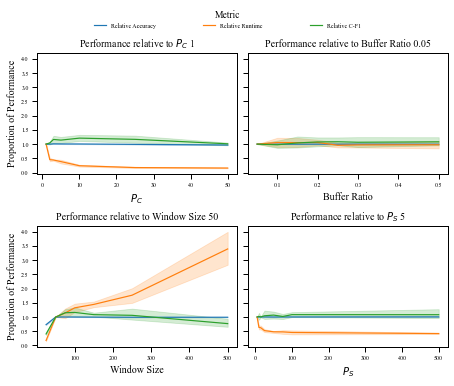

In [62]:


# fig, axes = plt.subplots(2, 2, sharey=True, figsize=(8, 8))
fig, axes = plt.subplots(2, 2, sharey=True, figsize=get_plot_size(2, 1, 2, 1))
err_style = 'band'


sns.lineplot(err_style = err_style, x="similarity_gap", y="Relative Accuracy", label="Relative Accuracy", data=relative_dfs, ax=axes[0, 0])
sns.lineplot(err_style = err_style, x="similarity_gap", y="Relative Runtime", label="Relative Runtime", data=relative_dfs, ax=axes[0, 0])
sns.lineplot(err_style = err_style, x="similarity_gap", y="Relative COncept Match", label="Relative C-F1", data=relative_dfs, ax=axes[0, 0])
axes[0,0].set_title("Performance relative to $P_C$ 1")
axes[0,0].set_ylabel("Proportion of Performance")
axes[0,0].set_xlabel("$P_C$")
axes[0, 0].get_legend().remove()
# fig.legend(loc="lower center",bbox_to_anchor = (0.5, -0.025), ncol=4)
fig.legend(bbox_to_anchor=(0.2,1.0,0.6,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=4, frameon=False, title="Metric")


param_location = data_location / "windowSensitivity"
sensitivity_param = "buffer_ratio"
df = get_location_results(param_location)
relative_dfs = None
selected_data = df[(df['data_name'] == dataset)]
seeds = selected_data['seed'].unique()
for seed in seeds:
    seed_data = selected_data[selected_data['seed'] == seed]
    seed_data = seed_data[seed_data['similarity_gap'] == 10]
    seed_data = seed_data[seed_data['window_size'] == 75]
    base = seed_data[seed_data['buffer_ratio'] == 0.05].to_dict("records")[0]
    # print(base)
    seed_df = seed_data[['overall_accuracy', 'buffer_ratio', 'window_size', 'mean_discrimination', 'GT_mean_f1', 'overall_time', 'overall_mem']]
    seed_df['Relative Accuracy'] = (seed_df['overall_accuracy'])/base['overall_accuracy']
    seed_df['Relative Discrimination'] = (seed_df['mean_discrimination'])/base['mean_discrimination']
    seed_df['Relative COncept Match'] = (seed_df['GT_mean_f1'])/base['GT_mean_f1']
    seed_df['Relative Runtime'] = (seed_df['overall_time'])/base['overall_time']
    seed_df['relative_overall_mem'] = (seed_df['overall_mem'])/base['overall_mem']
    if relative_dfs is None:
        relative_dfs = seed_df
    else:
        relative_dfs = relative_dfs.append(seed_df)
sns.lineplot(err_style = err_style, x="buffer_ratio", y="Relative Accuracy", label="Relative Accuracy", data=relative_dfs, ax=axes[0, 1])
sns.lineplot(err_style = err_style, x="buffer_ratio", y="Relative Runtime", label="Relative Runtime", data=relative_dfs, ax=axes[0, 1])
sns.lineplot(err_style = err_style, x="buffer_ratio", y="Relative COncept Match", label="Relative C-F1", data=relative_dfs, ax=axes[0, 1])
axes[0, 1].set_title("Performance relative to Buffer Ratio 0.05")
axes[0, 1].set_ylabel("Proportion of Performance")
axes[0, 1].set_xlabel("Buffer Ratio")
axes[0, 1].get_legend().remove()


relative_dfs = None
seeds = selected_data['seed'].unique()
for seed in seeds:
    seed_data = selected_data[selected_data['seed'] == seed]
    seed_data = seed_data[seed_data['similarity_gap'] == 10]
    seed_data = seed_data[seed_data['buffer_ratio'] == 0.25]
    base = seed_data[seed_data['window_size'] == 50].to_dict("records")[0]
    # print(base)
    seed_df = seed_data[['overall_accuracy', 'window_size', 'mean_discrimination', 'GT_mean_f1', 'overall_time', 'overall_mem']]
    seed_df['Relative Accuracy'] = (seed_df['overall_accuracy'])/base['overall_accuracy']
    seed_df['Relative Discrimination'] = (seed_df['mean_discrimination'])/base['mean_discrimination']
    seed_df['Relative COncept Match'] = (seed_df['GT_mean_f1'])/base['GT_mean_f1']
    seed_df['Relative Runtime'] = (seed_df['overall_time'])/base['overall_time']
    seed_df['relative_overall_mem'] = (seed_df['overall_mem'])/base['overall_mem']
    if relative_dfs is None:
        relative_dfs = seed_df
    else:
        relative_dfs = relative_dfs.append(seed_df)      

sns.lineplot(err_style = err_style, x="window_size", y="Relative Accuracy", label="Relative Accuracy", data=relative_dfs, ax=axes[1,0])
sns.lineplot(err_style = err_style, x="window_size", y="Relative Runtime", label="Relative Runtime", data=relative_dfs, ax=axes[1,0])
sns.lineplot(err_style = err_style, x="window_size", y="Relative COncept Match", label="Relative C-F1", data=relative_dfs, ax=axes[1,0])
axes[1,0].set_title("Performance relative to Window Size 50")
axes[1,0].set_ylabel("Proportion of Performance")
axes[1,0].set_xlabel("Window Size")
axes[1,0].get_legend().remove()

param_location = data_location / "NAFPSensitivity"
sensitivity_param = "buffer_ratio"
df = get_location_results(param_location)
relative_dfs = None
selected_data = df[(df['data_name'] == dataset)]
seeds = selected_data['seed'].unique()
for seed in seeds:
    seed_data = selected_data[selected_data['seed'] == seed]
    seed_data = seed_data[seed_data['similarity_gap'] == 2]
    seed_data = seed_data[seed_data['window_size'] == 75]
    base = seed_data[seed_data['nonactive_fp_gap'] == 5].to_dict("records")[0]
    # print(base)
    seed_df = seed_data[['overall_accuracy', 'nonactive_fp_gap', 'window_size', 'mean_discrimination', 'GT_mean_f1', 'overall_time', 'overall_mem']]
    seed_df['Relative Accuracy'] = (seed_df['overall_accuracy'])/base['overall_accuracy']
    seed_df['Relative Discrimination'] = (seed_df['mean_discrimination'])/base['mean_discrimination']
    seed_df['Relative COncept Match'] = (seed_df['GT_mean_f1'])/base['GT_mean_f1']
    seed_df['Relative Runtime'] = (seed_df['overall_time'])/base['overall_time']
    seed_df['relative_overall_mem'] = (seed_df['overall_mem'])/base['overall_mem']
    if relative_dfs is None:
        relative_dfs = seed_df
    else:
        relative_dfs = relative_dfs.append(seed_df)
sns.lineplot(err_style = err_style, x="nonactive_fp_gap", y="Relative Accuracy", label="Relative Accuracy", data=relative_dfs, ax=axes[1, 1])
sns.lineplot(err_style = err_style, x="nonactive_fp_gap", y="Relative Runtime", label="Relative Runtime", data=relative_dfs, ax=axes[1, 1])
sns.lineplot(err_style = err_style, x="nonactive_fp_gap", y="Relative COncept Match", label="Relative C-F1", data=relative_dfs, ax=axes[1, 1])
axes[1, 1].set_title("Performance relative to $P_S$ 5")
axes[1, 1].set_ylabel("Proportion of Performance")
axes[1, 1].set_xlabel("$P_S$")
axes[1, 1].get_legend().remove()


fig.tight_layout()
fig.savefig(output_location / f"{output_prefix}-performance_sensitivity_{str(dataset)}_eb.pdf" ,bbox_inches='tight')

### Drift Width Sensitivity

In [29]:
data_location =data_path / "FiCSUM" / "sig-noise-width"
data_location.exists()

True

In [30]:
results_files = data_location.rglob("result*")
results = []
for rf in results_files:
    result = json.load(rf.open('r'))
    if 'feature_weights' in result:
        for k in result['feature_weights']:
            result[f"fw-{k}"] = result['feature_weights'][k]
    results.append(result)
all_df = pd.DataFrame(results)
# %%
all_df.columns


Index(['overall_accuracy', 'acc', 'kappa', 'kappa_m', 'kappa_t',
       'overall_time', 'overall_mem', 'peak_fingerprint_mem',
       'average_fingerprint_mem', 'feature_weights',
       ...
       'fw-f5mean', 'fw-f4mean', 'fw-f2mean', 'fw-f1mean', 'fw-f0mean',
       'fw-f3mean', 'fw-f6mean', 'fw-f7mean', 'fw-f8mean', 'fw-f9mean'],
      dtype='object', length=102)

In [34]:
df = all_df[(~all_df['optdetect']) & (~all_df['optselect'])]
df['sig_noise_ratio'] = df['data_name'].str.split('-').str[1].astype('int')
df['sig_noise_ratio'] = df['sig_noise_ratio'] / 10
df[['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins', 'drift_width', 'overall_accuracy', 'seed']]

#%%

# fig, ax = plt.subplots()
# fp = 'cachehistogram'
# fs = 'Cachehistogram_MI'
# sm = 'metainfo'
def plot_feature_weights(fig, ax, fp, fs, sm, legend=True, stdev=False):
    fp_cond = df['fingerprint_method'] == fp
    fs_cond = df['fs_method'] == fs
    sm_cond = df['similarity_option'] == sm
    bin_cond = df['fingerprint_bins'] == 100
    select_df = df[fp_cond & fs_cond & sm_cond & bin_cond]
    sns.lineplot(data=select_df, x='drift_width', y='overall_accuracy', ax=ax, label=fs_replace(fs), err_style=None if not stdev else 'band')
    # columns = len(select_df)
    # if stdev:
    # #     factor = 0.95
    # #     for column,color in zip(range(columns),colors):
    # #         y = df.values[:,column]
    # #         yerr = df_yerr.values[:,column]
    #         ax.errorbar(
    #             df.index*factor, y, yerr=yerr, markersize=0, capsize=5,color=color,
    #             zorder = 10,
    #         )
    #         factor *= 1.02
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Gradual Drift Width")
    ax.set_title(f"Performance across gradual drift")
    if legend:
        leg = ax.legend(title="Feature\nSelection", bbox_to_anchor=[1.0, 1.0], loc="upper left", frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.get_legend().remove()

# plot_feature_weights(fig, ax, fp, fs, sm)
# plt.show()


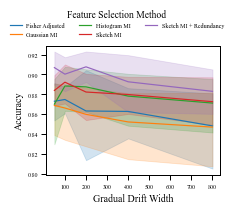

In [35]:


# %%
fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
for fp, fs, sm in [
                # ('cache', 'fisher', 'metainfo'), 
                ('cache', 'fisher_overall', 'metainfo'), 
                ('cache', 'CacheMIHy', 'metainfo'),
                ('cachehistogram', 'Cachehistogram_MI', 'metainfo'),
                ('cachesketch', 'sketch_MI', 'metainfo'),
                # ('cachesketch', 'sketch_MI', 'sketch'),
                ('cachesketch', 'sketch_covMI', 'metainfo'),
                # ('cachesketch', 'sketch_covMI', 'sketch'),
                ]:
    plot_feature_weights(fig, ax, fp, fs, sm, legend=False, stdev=True)

fig.legend(bbox_to_anchor=(0,1.0,1.0,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=3, frameon=False, title="Feature Selection Method")
ax.set_title("")
plt.tight_layout()
# plt.show()
plt.savefig(output_location / f"{output_prefix}-gradual_drift_eb.pdf", bbox_inches="tight")

### SIGNAL TO NOISE 

In [209]:
data_location =data_path / "FiCSUM" / "sig-noise-graph"
data_location.exists()

True

In [210]:
results_files = data_location.rglob("result*")
results = []
for rf in results_files:
    result = json.load(rf.open('r'))
    if 'feature_weights' in result:
        for k in result['feature_weights']:
            result[f"fw-{k}"] = result['feature_weights'][k]
    results.append(result)
all_df = pd.DataFrame(results)
df = all_df[(~all_df['optdetect']) & (~all_df['optselect'])]
df['sig_noise_ratio'] = df['data_name'].str.split('-').str[1].astype('int')
df['sig_noise_ratio'] = df['sig_noise_ratio'] / 10
df[['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins', 'sig_noise_ratio', 'overall_accuracy', 'seed']]
df

overall_accuracy       acc     kappa   kappa_m   kappa_t  overall_time  \
0            0.902919  0.902919  0.856358  0.811895  0.788211   1728.453125   
1            0.831286  0.831286  0.750368  0.673098  0.631938   1017.671875   
2            0.880852  0.880852  0.823708  0.769139  0.740071   1279.421875   
3            0.900271  0.900271  0.852440  0.806765  0.782435   1636.250000   
4            0.897371  0.897371  0.848149  0.801146  0.776109   1161.093750   
..                ...       ...       ...       ...       ...           ...   
779          0.907995  0.907995  0.751279  0.624412  0.709782    617.312500   
780          0.926252  0.926252  0.800634  0.698942  0.767372    511.734375   
781          0.867914  0.867914  0.642926  0.460791  0.583351    630.531250   
782          0.949257  0.949257  0.862824  0.792854  0.839938    834.765625   
783          0.921724  0.921724  0.788392  0.680456  0.753087   1055.734375   

     overall_mem  peak_fingerprint_mem  average_fingerprint_mem  \
0      96.554688             96.554688                79.805762   
1      45.328125             45.335938                35.683332   
2     184.472656            184.511719               147.745054   
3     108.242188            108.386719                84.298507   
4     206.789062            206.789062               162.781604   
..           ...                   ...                      ...   
779   -40.640625              0.097656               -37.915613   
780   -63.667969              0.718750               -56.219828   
781   -78.355469              1.710938               -63.340068   
782   100.175781            100.175781                68.536589   
783     2.808594              2.808594                 2.288530   

                                       feature_weights  ... fw-f8mean  \
0    {'errorsmean': 0.13128302096706754, 'f9mean': ...  ...  0.239495   
1    {'f9mean': 0.0912644082274851, 'f8mean': 0.091...  ...  0.091792   
2    {'f8mean': 0.056303989286224605, 'f9mean': 0.0...  ...  0.056304   
3    {'f2mean': 0.19787135303961276, 'f7mean': 0.19...  ...  0.271432   
4    {'f0mean': 0.3310330808393333, 'f4mean': 0.358...  ...  0.828158   
..                                                 ...  ...       ...   
779  {'f7mean': 0.14040696236251132, 'f3mean': 0.14...  ...  0.141959   
780  {'f9mean': 0.21747651939500587, 'f7mean': 0.21...  ...  0.222408   
781  {'f7mean': 1.1134359541798424, 'f9mean': 1.132...  ...  1.134511   
782  {'f2mean': 0.031083347670667526, 'f1mean': 0.0...  ...  0.095190   
783  {'f7mean': 0.09716053312145571, 'f8mean': 0.09...  ...  0.097311   

    fw-f4mean   fw-f2mean fw-f6mean   fw-f0mean  fw-f7mean fw-f3mean  \
0    0.372774    0.373031  0.379394    0.380021   0.382072  0.385865   
1    0.497130    0.499613  0.496687    0.507940   0.508758  0.503501   
2    0.093232    0.093923  0.090194    0.080043   0.143746  0.102620   
3    0.201698    0.197871  0.198581    0.198821   0.198478  0.213938   
4    0.358370    0.402228  0.477182    0.331033   0.385229  0.471306   
..        ...         ...       ...         ...        ...       ...   
779  0.143319    0.142065  0.142963    0.142005   0.140407  0.141463   
780  0.220656    0.665245  0.221868    0.640731   0.218537  0.221346   
781  1.141016  127.098681  1.140358  128.144709   1.113436  1.146660   
782  0.135752    0.031083  0.137779    0.093186   0.112154  0.063291   
783  0.098286    0.331817  0.098118    0.324223   0.097161  0.099116   

      fw-f1mean fw-f5mean  sig_noise_ratio  
0      0.419123  0.423494              0.2  
1      0.509601  0.501083              0.2  
2      0.102722  0.110942              0.2  
3      0.200081  0.200758              0.2  
4      0.439381  0.405572              0.2  
..          ...       ...              ...  
779    0.142757  0.142949              0.7  
780    0.669011  0.221563              0.7  
781  128.478093  1.142051              0.7  
782    0.053729  0.142168              0.7  
783    0.33287

In [211]:
def plot_feature_weights(fig, ax, fp, fs, sm, legend=True, stdev=False):
    for b in sorted(df['fingerprint_bins'].unique(), reverse=True):
    # for b in [2, 3, 4, 5, 6, 7, 8, 9, 10, 100]:
        fp_cond = df['fingerprint_method'] == fp
        fs_cond = df['fs_method'] == fs
        sm_cond = df['similarity_option'] == sm
        bin_cond = df['fingerprint_bins'] == b
        select_df = df[fp_cond & fs_cond & sm_cond & bin_cond]
        sns.lineplot(data=select_df, x='sig_noise_ratio', y='overall_accuracy', ax=ax, label=b, err_style=None if not stdev else 'band')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Signal-to-Noise Ratio")
    ax.set_title(f"{fs_replace(fs)}")
    if legend:
        leg = ax.legend(title="Approximation\nSize", bbox_to_anchor=[1.0, 1.0], loc="upper left", frameon=False)
        leg._legend_box.align = "left"
    else:
        leg = ax.get_legend()
        if leg:
            leg.remove()

0
0 0
1
1 0
2
0 1
3
1 1
4
0 2
5
1 2


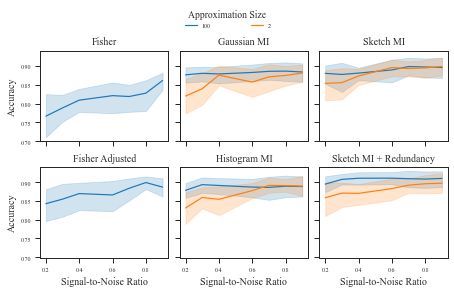

In [212]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=get_plot_size(1.5, 1, 1.5, 1), sharey=True)
for i, (fp, fs, sm) in enumerate([('cache', 'fisher', 'metainfo'), 
                ('cache', 'fisher_overall', 'metainfo'), 
                ('cache', 'CacheMIHy', 'metainfo'),
                ('cachehistogram', 'Cachehistogram_MI', 'metainfo'),
                ('cachesketch', 'sketch_MI', 'metainfo'),
                # ('cachesketch', 'sketch_MI', 'sketch'),
                ('cachesketch', 'sketch_covMI', 'metainfo'),
                # ('cachesketch', 'sketch_covMI', 'sketch'),
                ]):
    print(i)
    r = i % 2
    c = i // 2
    print(r, c)
    # plot_feature_weights(fig, ax[r, c], fp, fs, sm, legend=False, stdev=True)
    plot_feature_weights(fig, ax[r, c], fp, fs, sm, legend=False, stdev=True)
# handles, labels = ax[1, 1].get_legend_handles_labels()
handles, labels = ax[1, 2].get_legend_handles_labels()
# fig.legend(handles, labels, title="Approximation\nSize", bbox_to_anchor=[1.0, 1.0], loc="upper left", frameon=False)
# fig.legend(handles, labels, title="Approximation\nSize", loc="lower right", bbox_to_anchor=[0.9875, 0.1])
# fig.legend(handles, labels, title="Approximation\nSize", loc="lower right", bbox_to_anchor=[1.2, 0.6])
# labels = ["Approximation Size: ", *labels]
# ph = [plt.plot([],marker="", ls="")[0]] # Canvas
# handles = ph + handles
# fig.legend(handles, labels, loc="upper center", bbox_to_anchor=[0.5, 0.125], ncol=3, frameon=False)
fig.legend(handles, labels, bbox_to_anchor=(0.4,1.0,0.2,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=3, frameon=False, title="Approximation Size")
plt.tight_layout()
# fig.subplots_adjust(wspace=0.05)
plt.savefig(output_location / f"{output_prefix}-sig_noise_plot_l-set_g-stdev_v4.pdf", bbox_inches="tight")

### FEATURE WEIGHT 

In [205]:
using_opt = True
data_location =data_path / "FiCSUM" / "feature-weight-test-opt"
data_location.exists()

True

In [206]:
results_files = data_location.rglob("result*")
results = []
for rf in results_files:
    result = json.load(rf.open('r'))
    if 'feature_weights' in result:
        for k in result['feature_weights']:
            result[f"fw-{k}"] = result['feature_weights'][k]
    results.append(result)
all_df = pd.DataFrame(results)
# %%
all_df.columns
# %%
df = all_df
df.groupby(['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins']).mean()[['fw-f1mean', 'fw-f2mean', 'fw-f3mean', 'fw-f4mean', 'fw-f5mean', 'fw-f6mean', 'fw-f7mean', 'fw-f8mean', 'fw-f9mean']]
# df.groupby(['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins']).mean()[['fw-f1mean']]

# %%
df = all_df[['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins', 'fw-f1mean', 'fw-f2mean', 'fw-f3mean', 'fw-f4mean', 'fw-f5mean', 'fw-f6mean', 'fw-f7mean', 'fw-f8mean', 'fw-f9mean']]
df = pd.melt(df, id_vars=['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins'])
df

fingerprint_method     fs_method similarity_option  fingerprint_bins  \
0                 cache     CacheMIHy          metainfo                50   
1           cachesketch  sketch_covMI          metainfo                50   
2           cachesketch     sketch_MI            sketch                25   
3           cachesketch  sketch_covMI            sketch                50   
4           cachesketch     sketch_MI          metainfo                25   
...                 ...           ...               ...               ...   
8311        cachesketch     sketch_MI          metainfo                 2   
8312        cachesketch     sketch_MI            sketch                 8   
8313              cache     CacheMIHy          metainfo                 5   
8314        cachesketch     sketch_MI            sketch                 4   
8315        cachesketch     sketch_MI            sketch                 5   

       variable     value  
0     fw-f1mean  1.000000  
1     fw-f1mean  0.343659  
2     fw-f1mean  0.725772  
3     fw-f1mean  0.343659  
4     fw-f1mean  0.725772  
...         ...       ...  
8311  fw-f9mean  0.511278  
8312  fw-f9mean  0.540861  
8313  fw-f9mean  2.321928  
8314  fw-f9mean  0.392395  
8315  fw-f9mean  0.492318  

[8316 rows x 6 columns]

In [207]:
def plot_feature_weights(fig, ax, fp, fs, sm, legend=True, stdev=False):
    # for b in sorted(df['fingerprint_bins'].unique(), reverse=True):
    for b in [2, 3, 4, 5, 6, 7, 8, 9, 10, 100]:
        fp_cond = df['fingerprint_method'] == fp
        fs_cond = df['fs_method'] == fs
        sm_cond = df['similarity_option'] == sm
        bin_cond = df['fingerprint_bins'] == b
        select_df = df[fp_cond & fs_cond & sm_cond & bin_cond]
        select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
        sns.lineplot(data=select_df, x='variable', y='value', ax=ax, label=b, err_style=None if not stdev else 'band')
    ax.set_ylabel("Feature Weight")
    ax.set_xlabel("Feature Importance")
    ax.set_title(f"{fs_replace(fs)}")
    if legend:
        leg = ax.legend(title="Approximation\nSize", bbox_to_anchor=[1.0, 1.0], loc="upper left", frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.get_legend().remove()

C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

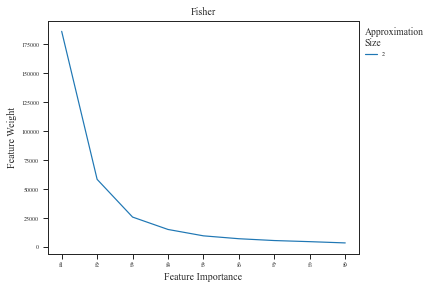

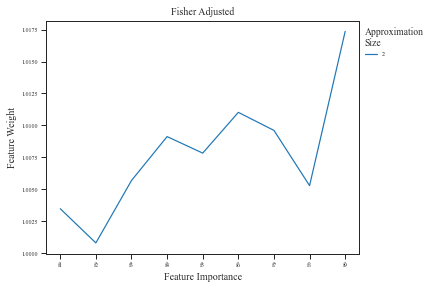

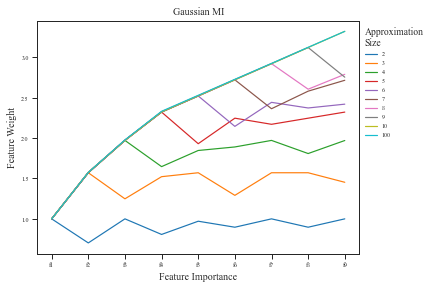

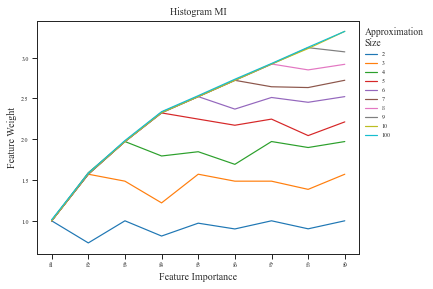

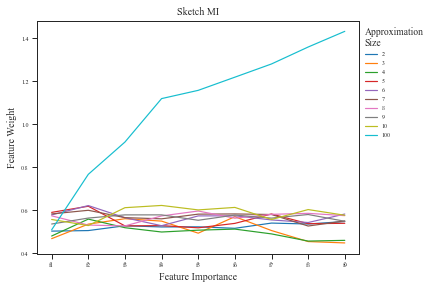

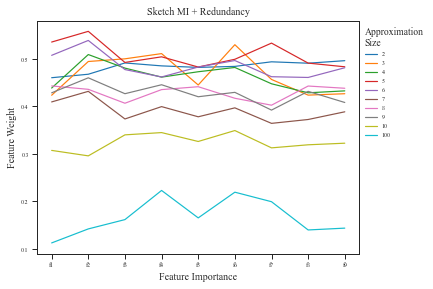

In [183]:

for fp, fs, sm in [('cache', 'fisher', 'metainfo'), 
                ('cache', 'fisher_overall', 'metainfo'), 
                ('cache', 'CacheMIHy', 'metainfo'),
                ('cachehistogram', 'Cachehistogram_MI', 'metainfo'),
                ('cachesketch', 'sketch_MI', 'metainfo'),
                # ('cachesketch', 'sketch_MI', 'sketch'),
                ('cachesketch', 'sketch_covMI', 'metainfo'),
                # ('cachesketch', 'sketch_covMI', 'sketch'),
                ]:
    fig, ax = plt.subplots()
    plot_feature_weights(fig, ax, fp, fs, sm, stdev=(not using_opt))
    plt.tight_layout()
    # plt.savefig(f"feature_weight_plot_l-{fp}-{fs}-{fp}-opt-{using_opt}_v2.pdf")

0
0 0
1
1 0


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

2
0 1


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

3
1 1


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

4
0 2


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

5
1 2


C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df['variable'] = select_df['variable'].str.split('-').str[1].str[:-4]
C:\Users\Ben\AppData\Local\Temp/ipykernel_85176/4245336574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

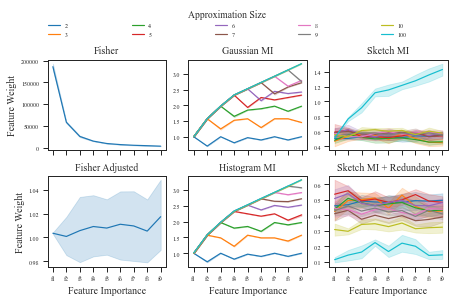

In [208]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=get_plot_size(1.5, 1, 1.5, 1), sharey=False)
for i, (fp, fs, sm) in enumerate([('cache', 'fisher', 'metainfo'), 
                ('cache', 'fisher_overall', 'metainfo'), 
                ('cache', 'CacheMIHy', 'metainfo'),
                ('cachehistogram', 'Cachehistogram_MI', 'metainfo'),
                ('cachesketch', 'sketch_MI', 'metainfo'),
                # ('cachesketch', 'sketch_MI', 'sketch'),
                ('cachesketch', 'sketch_covMI', 'metainfo'),
                # ('cachesketch', 'sketch_covMI', 'sketch'),
                ]):
    print(i)
    r = i % 2
    c = i // 2
    print(r, c)
    # plot_feature_weights(fig, ax[r, c], fp, fs, sm, legend=False, stdev=True)
    plot_feature_weights(fig, ax[r, c], fp, fs, sm, legend=False, stdev=True)

for r in range(0, 2):
    for c in range(1, 3):
        ax[r, c].get_yaxis().label.set_visible(False)
# handles, labels = ax[1, 1].get_legend_handles_labels()
handles, labels = ax[1, 2].get_legend_handles_labels()
# fig.legend(handles, labels, title="Approximation\nSize", bbox_to_anchor=[1.0, 1.0], loc="upper left", frameon=False)
# fig.legend(handles, labels, title="Approximation\nSize", loc="lower right", bbox_to_anchor=[0.9875, 0.1])
# fig.legend(handles, labels, title="Approximation\nSize", loc="lower right", bbox_to_anchor=[1.2, 0.6])
# labels = ["Approximation Size: ", *labels]
# ph = [plt.plot([],marker="", ls="")[0]] # Canvas
# handles = ph + handles
# fig.legend(handles, labels, loc="upper center", bbox_to_anchor=[0.5, 0.125], ncol=3, frameon=False)
fig.legend(handles, labels, bbox_to_anchor=(0.1,1.0,0.8,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=5, frameon=False, title="Approximation Size")
plt.tight_layout()
# fig.subplots_adjust(wspace=0.05)
plt.savefig(output_location / f"{output_prefix}-feature_weight_plot_l-set_horizontal_2-opt-{using_opt}-stdev_v2.pdf", bbox_inches="tight")

### NONE COMPARISON

In [36]:
data_location =data_path / "FiCSUM" / "sig-noise-none"
data_location.exists()

True

In [37]:
results_files = data_location.rglob("result*")
results = []
for rf in results_files:
    result = json.load(rf.open('r'))
    if 'feature_weights' in result:
        for k in result['feature_weights']:
            result[f"fw-{k}"] = result['feature_weights'][k]
    results.append(result)
all_df = pd.DataFrame(results)
# %%
all_df.columns
#%%
print(all_df.iloc[0]['isources'])
# %%
# df = all_df
df = all_df[all_df['isources'].isnull()]
# df = all_df[(all_df['data_name'] == 'SigNoiseGenerator-4') & (all_df['fs_method'] == 'CacheMIHy')]
# df = all_df[(~all_df['optdetect']) & (~all_df['optselect'])]
df['sig_noise_ratio'] = df['data_name'].str.split('-').str[1].astype('int')
df['sig_noise_ratio'] = df['sig_noise_ratio'] / 10
# df.groupby(['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins', 'sig_noise_ratio']).mean()[['overall_accuracy']]
# df[df['seed'] == 5].groupby(['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins', 'sig_noise_ratio']).mean()[['overall_accuracy']]
# df.groupby(['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins']).mean()[['fw-f1mean']]
df[['fingerprint_method', 'fs_method', 'similarity_option', 'fingerprint_bins', 'sig_noise_ratio', 'overall_accuracy', 'seed', 'isources']]
df

None


C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/2224024508.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sig_noise_ratio'] = df['data_name'].str.split('-').str[1].astype('int')
C:\Users\Ben\AppData\Local\Temp/ipykernel_3736/2224024508.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sig_noise_ratio'] = df['sig_noise_ratio'] / 10


overall_accuracy       acc     kappa   kappa_m   kappa_t  overall_time  \
0            0.578738  0.578738  0.376695  0.183759  0.080988   1858.640625   
1            0.777886  0.777886  0.671357  0.569629  0.515442   2408.203125   
3            0.835724  0.835724  0.756935  0.681697  0.641620   2572.968750   
4            0.620010  0.620010  0.484239  0.452290  0.335410   2545.593750   
5            0.551614  0.551614  0.391407  0.353707  0.215789   2290.937500   
..                ...       ...       ...       ...       ...           ...   
294          0.928795  0.928795  0.851518  0.821491  0.817107   3736.734375   
295          0.925995  0.925995  0.845679  0.814471  0.809915   4950.156250   
296          0.940376  0.940376  0.838816  0.756600  0.811924   4241.187500   
297          0.909705  0.909705  0.755900  0.631391  0.715174   2420.609375   
298          0.918467  0.918467  0.779587  0.667159  0.742813   4203.656250   

     overall_mem  peak_fingerprint_mem  average_fingerprint_mem  \
0     160.171875            163.828125               117.198509   
1       3.136719              4.316406                 3.361121   
3      69.039062             69.039062                19.518894   
4      22.058594             22.058594                15.597072   
5     176.339844            177.152344               135.139748   
..           ...                   ...                      ...   
294    27.242188             27.242188                 7.496717   
295   148.160156            151.695312                46.296957   
296    22.722656             22.722656                -3.800781   
297    28.101562             28.101562                 3.676218   
298    64.941406             64.945312                21.047755   

                                       feature_weights  ...  \
0    {'f6turning_point_rate': 2.26987883862116e-05,...  ...   
1    {'f3acf_2': 1.0, 'f3acf_1': 1.0, 'f3mean': 1.0...  ...   
3    {'f9pacf_2': 0.0010693321030790246, 'f9acf_2':...  ...   
4    {'error_distancespacf_2': 2.1843097186798916e-...  ...   
5    {'f7pacf_2': 0.00035469500678820767, 'f4turnin...  ...   
..                                                 ...  ...   
294  {'f5pacf_2': 0.0011523784697752533, 'f5acf_2':...  ...   
295  {'f5pacf_2': 0.002538211399613326, 'f5acf_2': ...  ...   
296  {'error_distancespacf_2': 0.002306843889964108...  ...   
297  {'f7acf_2': 1.0, 'f7kurtosis': 1.0, 'f7skew': ...  ...   
298  {'f4pacf_2': 0.0010212185725326321, 'f4acf_2':...  ...   

    fw-predictionsacf_2 fw-errorsskew fw-predictionspacf_2  \
0             24.368514     30.010547            31.563420   
1              1.000000      1.000000             1.000000   
3              0.106145      0.030511             0.091028   
4              0.221306      0.141104             0.197062   
5              2.150255      0.087076             1.733774   
..                  ...           ...                  ...   
294           14.625084      0.411557            21.806022   
295            0.113306      0.051958             0.091626   
296            0.104458      0.026242             0.089223   
297            1.000000      1.000000             1.000000   
298            0.640073      0.167450             0.516464   

    fw-error_distancesmean  fw-predictionsmean  fw-errorskurtosis  \
0                36.542574           55.968366         108.137631   
1                 1.000000            1.000000           1.000000   
3                 0.026746            0.241099           0.015341   
4                 0.233177            0.265915           0.090611   
5                 0.420198            1.204518           0.394582   
..                     ...                 ...                ...   
294               0.188001           19.821573           0.053274   
295               0.027395            0.131821           0.031387   
296               0.023263            0.192349           0.017950   
297               1.000000            1.000000           1.

In [40]:
def plot_feature_weights(fig, ax, fp, fs, sm, legend=True, stdev=False):
    for b in sorted(df['fingerprint_bins'].unique(), reverse=True):
    # for b in [2, 3, 4, 5, 6, 7, 8, 9, 10, 100]:
        fp_cond = df['fingerprint_method'] == fp
        fs_cond = df['fs_method'] == fs
        sm_cond = df['similarity_option'] == sm
        bin_cond = df['fingerprint_bins'] == b
        select_df = df[fp_cond & fs_cond & sm_cond & bin_cond]
        sns.lineplot(data=select_df, x='sig_noise_ratio', y='overall_accuracy', ax=ax, label=fs_replace(fs), err_style=None if not stdev else 'band')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Signal-to-Noise Ratio")
    ax.set_title(f"Feature selection vs no feature selection")
    if legend:
        leg = ax.legend(title="Feature Selection", bbox_to_anchor=[1.0, 1.0], loc="upper left", frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.get_legend().remove()

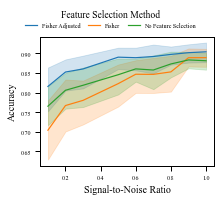

In [41]:
fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
fp = 'cache'
fs = 'fisher_overall'
sm = 'metainfo'
plot_feature_weights(fig, ax, fp, fs, sm, legend=False, stdev=True)
fp = 'cache'
fs = 'fisher'
sm = 'metainfo'
plot_feature_weights(fig, ax, fp, fs, sm, legend=False, stdev=True)
fp = 'cache'
fs = 'None'
sm = 'metainfo'
plot_feature_weights(fig, ax, fp, fs, sm, legend=False, stdev=True)
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, bbox_to_anchor=(0.1,1.0,0.8,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=3, frameon=False, title="Feature Selection Method")
ax.set_title("")
fig.tight_layout()
# plt.show()
plt.savefig(output_location / f"{output_prefix}-No_feature_selection_results_eb.pdf", bbox_inches='tight')

### MEMORY MANAGEMENT - FiCSUM

In [45]:
data_location = data_path / "Overall" / "select_mem_l2"
data_location.exists()

True

In [46]:
results_files = list(data_location.rglob('results*'))
results = []
for rp in tqdm(results_files):
    result = json.load(rp.open('r'))
    results.append(result)

df = pd.DataFrame(results)

  0%|          | 0/8640 [00:00<?, ?it/s]

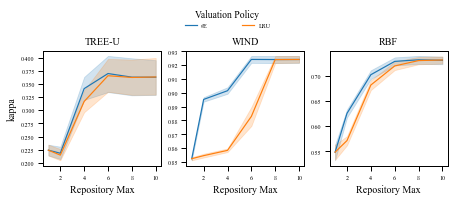

In [48]:
data_names = ['RTREESAMPLE_HARD', 'WINDSIM', 'RBFMed']
data_name_map = {
    "RTREESAMPLE_HARD": "TREE-U",
    "WINDSIM" : "WIND",
    "RBFMed": "RBF"
}
label_map = {
    "rA": "#E",
    "LRU": "LRU"
}
classifier = 'ficsum'
# classifier = 'cc'
# classifier = 'advantage'
# classifier = 'airstream'
fig, axs = plt.subplots(1, len(data_names), figsize=get_plot_size(1, 1, 1, 1), sharey=False)
if len(data_names) == 1:
    axs = [axs]
for i, dn in enumerate(data_names):
    dn_df = df[df['data_name'] == dn]
    dn_df = dn_df[dn_df['classifier'] == classifier]
    ax = axs[i]
    g = sns.lineplot(data=dn_df, x='repository_max', y='kappa', hue='valuation_policy', hue_order=['rA', 'LRU'], ax=ax)
    h, l = g.get_legend_handles_labels()
    ax.legend().remove()
    if i > 0:
        ax.get_yaxis().label.set_visible(False)
    ax.set_xlabel("Repository Max")
    ax.set_title(data_name_map[dn])
l = [label_map[x] for x in l]
fig.legend(h, l, bbox_to_anchor=(0.4,1.0,0.2,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=4, frameon=False, title="Valuation Policy")
fig.tight_layout()
# plt.show()
plt.savefig(output_location / f"{output_prefix}-mem_management_2.pdf", bbox_inches="tight")

# CHAPTER 7 - SELeCT

In [49]:
output_location = pathlib.Path("Chap7")
if not output_location.exists():
    output_location.mkdir(parents=True)
output_prefix = "SLCT"

In [3]:
def get_classifier_matched_results(base_path, experiment_name, parameters_of_interest, IVs_of_interest, seeds, restrictions):
    if base_path is None:
        base_path = pathlib.Path(__file__).absolute().parents[1] / 'output' / experiment_name

    print(base_path)
    desc_paths = list(base_path.rglob(f"desc*.txt"))
    for d_path in desc_paths:
        print(d_path.open().read())
    results_paths = list(base_path.rglob(f"results_run_*.txt"))
    results = []
    for rp in results_paths:
        try:
            results.append(json.load(rp.open()))
        except:
            print(rp)
    # results = [json.load(rp.open()) for rp in results_paths]
    df = pd.DataFrame(results)
    print(df['classifier'].unique())
    if df.shape[0] == 0:
        raise ValueError("Data not loaded - maybe path is wrong")
    if 'classifier' not in df.columns:
        df['classifier'] = "CC"
    if 'merge_threshold' not in df.columns:
        df['merge_threshold'] = -1
    if 'zero_prob_minimum' not in df.columns:
        df['zero_prob_minimum'] = -1
    if 'TMdropoff' not in df.columns:
        df['TMdropoff'] = 1.0
    if 'TMforward' not in df.columns:
        df['TMforward'] = 1
    if 'TMnoise' not in df.columns:
        df['TMnoise'] = 0.0
    if 'prev_state_prior' not in df.columns:
        df['prev_state_prior'] = 0.0
    if 'noise' not in df.columns:
        df['noise'] = 0.0
    if 'conceptdifficulty' not in df.columns:
        df['conceptdifficulty'] = 0.0
    df['conceptdifficulty'] = df['conceptdifficulty'].fillna(0.0)
    if 'correlation_merge' not in df.columns:
        df['correlation_merge'] = False
    if 'FICSUM' not in df.columns:
        df['FICSUM'] = False
    if 'GT_mean_f1' not in df.columns:
        df['GT_mean_f1'] = df['m-GT_mean_f1']
    if 'background_state_prior_multiplier' not in df.columns:
        df['background_state_prior_multiplier'] = 0.5
    df = df[df['seed'].isin(seeds) ]
    for restricted_param, restricted_vals in restrictions:
        df = df[df[restricted_param].isin(restricted_vals)]
    df['classifier'] = df['classifier'].fillna("CC")
    # Parameters used to define a run
    # matching_parameters = ["data_name", "seed", "classifier", "isources", "ifeatures", "optdetect", "optselect", "opthalf", "shuffleconcepts", "similarity_option", "MI_calc", "window_size", "sensitivity", "min_window_ratio", "fingerprint_grace_period", "state_grace_period_window_multiplier", "bypass_grace_period_threshold", "state_estimator_risk", "state_estimator_swap_risk", "minimum_concept_likelihood", "min_drift_likelihood_threshold", "min_estimated_posterior_threshold", "similarity_gap", "fp_gap", "nonactive_fp_gap", "observation_gap", "similarity_stdev_min", "similarity_stdev_max", "buffer_ratio", "merge_threshold", "correlation_merge", "fs_method", "fingerprint_method", "fingerprint_bins"]
    matching_parameters = ["data_name", "seed", "classifier", "repeats", "conceptdifficulty", "noise", "drift_width", "prev_state_prior", "TMdropoff", "TMforward", "TMnoise", "zero_prob_minimum", "shuffleconcepts", "FICSUM", "multihop_penalty", "similarity_option", "MI_calc", "window_size", "sensitivity", "min_window_ratio", "fingerprint_grace_period", "state_grace_period_window_multiplier", "bypass_grace_period_threshold", "state_estimator_risk", "state_estimator_swap_risk", "minimum_concept_likelihood", "min_drift_likelihood_threshold", "min_estimated_posterior_threshold", "similarity_gap", "fp_gap", "nonactive_fp_gap", "observation_gap", "similarity_stdev_min", "similarity_stdev_max", "buffer_ratio", "merge_threshold", "correlation_merge", "fs_method", "fingerprint_method", "fingerprint_bins", "background_state_prior_multiplier"]
    classifiers = df['conceptdifficulty'].unique()
    print(classifiers)
    runs_df = df.groupby(matching_parameters).mean()[IVs_of_interest]
    # return df
    # print(runs_df.reset_index()['classifier'].unique())
    runs_by_classifier = runs_df.unstack('classifier')
    for IV in IVs_of_interest:
        IV_df = runs_by_classifier[IV]
        for classifier in classifiers:
            try:
                runs_by_classifier.loc[:, (f"{IV}-bounded", classifier)] = (IV_df[classifier] - IV_df["lower_bound"]) / (IV_df["upper_bound"] - IV_df["lower_bound"])
                runs_by_classifier.loc[:, (f"{IV}-bounded", classifier)] = runs_by_classifier.loc[:, (f"{IV}-bounded", classifier)].replace([np.inf, -np.inf], np.nan).replace(np.nan, 1)
            except:
                pass
    runs_by_classifier = runs_by_classifier.stack('classifier').reset_index()
    if 'classifier' in parameters_of_interest:
        bounded_df = runs_by_classifier.reset_index()
    else:
        bounded_df = runs_by_classifier[runs_by_classifier['classifier'] == "CC"].reset_index()
    bounded_df = bounded_df.dropna()
    groups = bounded_df.groupby(parameters_of_interest)
    sizes = groups.size()
    grouped = groups.aggregate(('mean', 'std'))[[*IVs_of_interest, *[f"{IV}-bounded" for IV in IVs_of_interest if f"{IV}-bounded" in bounded_df.columns]]]
    grouped['size'] = sizes
    return bounded_df, groups, grouped

In [4]:
data_name_map = {
    "AQSex": "AQSex",
    "AQTemp": "AQTemp",
    "RTREESAMPLE_HARD": "TREE",
    "Arabic": "AD",
    "cmc": "CMC",
    "RTREESAMPLE_Diff": "TREE"
}

classifier_name_map = {
    "CC": "SELeCT",
    "arf": "ARF",
    "dwm": "DWM",
    "cpf": "CPF",
    "dynse": "DYNSE",
    "ficsum": "FICSUM",
    "lower_bound": "Lower",
    "upper_bound": "Upper"
}

### SENSITIVITY - NUM DRIFTS

In [215]:
data_location =data_path / "SELeCT" / "long2"
data_location.exists()

True

In [220]:
experiment_name = "long2"
experiment_parameters = ["data_name", "classifier", 'repeats']
experiment_IVs = ['overall_accuracy', 'GT_mean_f1', 'kappa', 'kappa_m', 'kappa_t', "overall_time"]
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
data_name = ''
restrictions = []
selected, groups, grouped = get_classifier_matched_results(data_location, experiment_name, parameters_of_interest=experiment_parameters, IVs_of_interest=experiment_IVs, seeds=seeds, restrictions=restrictions)
selected

G:\My Drive\UniMine\Uni\PhD\Thesis\Data\SELeCT\long2
























['DWM' 'CC' 'dwm']
[0]


index data_name  seed  repeats  conceptdifficulty  noise  drift_width  \
0         0    Arabic     1        3                  0      0            0   
1         1    Arabic     1        3                  0      0            0   
2         2    Arabic     1       10                  0      0            0   
3         3    Arabic     1       10                  0      0            0   
4         4    Arabic     1       20                  0      0            0   
...     ...       ...   ...      ...                ...    ...          ...   
1075   1075       cmc    45       10                  0      0            0   
1076   1076       cmc    45       20                  0      0            0   
1077   1077       cmc    45       20                  0      0            0   
1078   1078       cmc    45       30                  0      0            0   
1079   1079       cmc    45       30                  0      0            0   

      prev_state_prior  TMdropoff  TMforward  ...  fingerprint_method  \
0                   50        1.0          1  ...         descriptive   
1                   50        1.0          1  ...         descriptive   
2                   50        1.0          1  ...         descriptive   
3                   50        1.0          1  ...         descriptive   
4                   50        1.0          1  ...         descriptive   
...                ...        ...        ...  ...                 ...   
1075                50        1.0          1  ...         descriptive   
1076                50        1.0          1  ...         descriptive   
1077                50        1.0          1  ...         descriptive   
1078                50        1.0          1  ...         descriptive   
1079                50        1.0          1  ...         descriptive   

      fingerprint_bins  background_state_prior_multiplier  classifier  \
0                   10                                0.4          CC   
1                   10                                0.4         DWM   
2                   10                                0.4          CC   
3                   10                                0.4         DWM   
4                   10                                0.4          CC   
...                ...                                ...         ...   
1075                10                                0.4         DWM   
1076                10                                0.4          CC   
1077                10                                0.4         DWM   
1078                10                                0.4          CC   
1079                10                                0.4         DWM   

      overall_accuracy GT_mean_f1     kappa   kappa_m   kappa_t  overall_time  
0             0.937879   0.921257  0.875758  0.875758  0.874024    401.125000  
1             0.936427   0.285714  0.872854  0.872854  0.871079     27.078125  
2             0.947746   0.916299  0.895492  0.895492  0.894044    987.984375  
3             0.933239   0.285714  0.866477  0.866477  0.864626    102.218750  
4             0.948920   0.913138  0.897841  0.897841  0.896427   2008.062500  
...                ...        ...       ...       ...       ...           ...  
1075          0.594365   0.666552  0.188416  0.172438  0.143983     21.828125  
1076          0.667379   0.752281  0.334501  0.321399  0.298066    209.078125  
1077          0.594637   0.666552  0.188959  0.172992  0.144556     43.734375  
1078          0.668907   0.777850  0.337557  0.324515  0.301289    369.890625  
1079          0.595180   0.666552  0.190046  0.174100  0.145702     65.437500  

[1080 rows x 48 columns]

{'SELeCT': '', 'ARF': (1, 1), 'DWM': (3, 1), 'CPF': '', 'DYNSE': '', 'FICSUM': '', 'Lower': (3, 1), 'Upper': (3, 1)}
['data_name', 'Arabic', 'RTREESAMPLE_HARD', 'cmc', 'classifier', 'CC', 'DWM']
['data_name', 'Arabic', 'RTREESAMPLE_HARD', 'cmc', 'classifier', 'CC', 'DWM']
['Dataset', 'AD', 'TREE', 'CMC', 'Classifier', 'SELeCT', 'DWM']


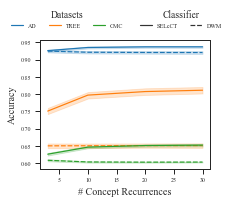

In [240]:
dashes = {k:'' for k in classifier_name_map.values()}
dashes['Lower'] = (3, 1)
dashes['Upper'] = (3, 1)
dashes['DWM'] = (3, 1)
dashes['ARF'] = (1, 1)
print(dashes)


# parameter = 'noise'
# parameter = "conceptdifficulty"
# parameter_alias = "Complexity"
parameter = 'repeats'
parameter_alias = "# Concept Recurrences"
# parameter = "TMnoise"
# parameter = "TMforward"
# data_sets = ['AQSex', 'AQTemp', 'RTREESAMPLE_HARD']
# data_sets = ['Arabic', 'AQTemp', 'cmc']
# data_sets = ['RTREESAMPLE_Diff']
data_sets = ['Arabic', 'RTREESAMPLE_HARD', 'cmc']
y = "overall_accuracy"
y_alias = "Accuracy"
# y = "kappa"

selected.loc[selected['classifier'] == 'dwm', 'classifier'] = 'DWM'
# y_alias = "Kappa"
# data_name = "RTREESAMPLE_HARD"
# fig = plt.figure()
# fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True, sharex=True)
# fig, ax = plt.subplots(1, 2, figsize=(6.5,2.5), sharey=True, sharex=True)
fig, ax = plt.subplots(1, 1, figsize=get_plot_size(1, 2, 1, 1), sharey=True, sharex=True)
# fig.set_size_inches(6.5,2.5)
sns.lineplot(data=selected, x=parameter, y=y, hue='data_name', ax=ax, legend=True, style='classifier')
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.get_legend().remove()
# ax.set_title()
ax.set_ylabel(y_alias)
ax.set_xlabel(parameter_alias)
print(labels)
labels = list(map(lambda x: {**data_name_map, **classifier_name_map, 'data_name': 'Dataset', 'classifier': 'Classifier'}.get(x, x), labels))
print(labels)
dataset_legend_lines = []
classifier_legend_lines = []
for h, l in zip(handles, labels):
    if l in ["AD", "TREE", "CMC"]:
        dataset_legend_lines.append((h, l))
    if l in ["SELeCT", "DWM"]:
        classifier_legend_lines.append((h, l))


ds_leg = ax.legend([x[0] for x in dataset_legend_lines], [x[1] for x in dataset_legend_lines], loc='lower left', bbox_to_anchor=(-0.2, 1.05), frameon=False, ncol=6, title="Datasets")
cl_leg = ax.legend([x[0] for x in classifier_legend_lines], [x[1] for x in classifier_legend_lines], loc='lower right', bbox_to_anchor=(1.1, 1.05), frameon=False, ncol=6, title="Classifier")
ax.add_artist(ds_leg)
# fig.legend(handles, labels, loc='upper right')
plt.savefig(output_location / f"{output_prefix}-{parameter}5.pdf", bbox_inches='tight')
plt.show()

### SENSITIVITY - CONCEPT DIFFICULTY

In [5]:
data_location =data_path / "SELeCT" / "concept_diff"
data_location.exists()

True

In [6]:
experiment_name = "concept_diff"
experiment_parameters = ["data_name", "conceptdifficulty", "classifier"]
experiment_IVs = ['overall_accuracy', 'GT_mean_f1', 'kappa', 'kappa_m', 'kappa_t', "overall_time"]
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
data_name = ''
restrictions = []
selected, groups, grouped = get_classifier_matched_results(data_location, experiment_name, parameters_of_interest=experiment_parameters, IVs_of_interest=experiment_IVs, seeds=seeds, restrictions=restrictions)
selected

G:\My Drive\UniMine\Uni\PhD\Thesis\Data\SELeCT\concept_diff











['CC_MAP' 'lower_bound' 'dwm' 'dynse' 'rcd' 'cpf' 'ficsum' 'CC_basicprior'
 'CC_nomerge' 'upper_bound' 'CC']
[8. 7. 5. 3. 1. 6. 2. 4.]


index         data_name  seed  repeats  conceptdifficulty  noise  \
0         0  RTREESAMPLE_Diff     1        3                1.0      0   
1         1  RTREESAMPLE_Diff     1        3                1.0      0   
2         2  RTREESAMPLE_Diff     1        3                1.0      0   
3         3  RTREESAMPLE_Diff     1        3                1.0      0   
4         4  RTREESAMPLE_Diff     1        3                1.0      0   
...     ...               ...   ...      ...                ...    ...   
3632   3632  RTREESAMPLE_Diff    45        3                8.0      0   
3633   3633  RTREESAMPLE_Diff    45        3                8.0      0   
3634   3634  RTREESAMPLE_Diff    45        3                8.0      0   
3635   3635  RTREESAMPLE_Diff    45        3                8.0      0   
3636   3636  RTREESAMPLE_Diff    45        3                8.0      0   

      drift_width  prev_state_prior  TMdropoff  TMforward  ...  \
0               0                50        1.0          1  ...   
1               0                50        1.0          1  ...   
2               0                50        1.0          1  ...   
3               0                50        1.0          1  ...   
4               0                50        1.0          1  ...   
...           ...               ...        ...        ...  ...   
3632            0                50        1.0          1  ...   
3633            0                50        1.0          1  ...   
3634            0                50        1.0          1  ...   
3635            0                50        1.0          1  ...   
3636            0                50        1.0          1  ...   

      fingerprint_method  fingerprint_bins  background_state_prior_multiplier  \
0            descriptive                10                                0.4   
1            descriptive                10                                0.4   
2            descriptive                10                                0.4   
3            descriptive                10                                0.4   
4            descriptive                10                                0.4   
...                  ...               ...                                ...   
3632         descriptive                10                                0.4   
3633         descriptive                10                                0.4   
3634         descriptive                10                                0.4   
3635         descriptive                10                                0.4   
3636         descriptive                10                                0.4   

         classifier  overall_accuracy GT_mean_f1     kappa   kappa_m  \
0                CC          0.888100   0.980922  0.776000  0.769310   
1            CC_MAP          0.871433   0.973750  0.742637  0.734951   
2     CC_basicprior          0.882733   0.973983  0.765257  0.758246   
3        CC_nomerge          0.888100   0.980922  0.776000  0.769310   
4               cpf          0.737156   0.477439  0.473858  0.458127   
...             ...               ...        ...       ...       ...   
3632            dwm          0.522667   0.285714  0.045242  0.035928   
3633          dynse          0.532809   0.333133  0.065571  0.056779   
3634         ficsum          0.532100   0.860414  0.064111  0.054981   
3635    lower_bound          0.523467   0.285714  0.046843  0.037544   
3636    upper_bound          0.535333   0.979222  0.070578  0.061511   

       kappa_t  overall_time  
0     0.775341   1359.937500  
1     0.741880   1343.171875  
2     0.764567   1586.468750  
3     0.775341   1504.281250  
4     0.472294    101.250000  
...        ...           ...  
3632  0.043420    145.484375  
3633  0.064019     39.187500  
3634  0.062325   1868.265625  
3635  0.045023    141.593750  
3636  0.068804    151.593750  

[3637 rows x 48 columns]

{'SELeCT': '', 'ARF': (1, 1), 'DWM': '', 'CPF': '', 'DYNSE': '', 'FICSUM': '', 'Lower': (3, 1), 'Upper': (3, 1)}


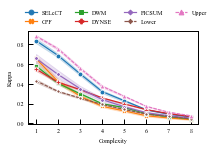

In [15]:
dashes = {k:'' for k in classifier_name_map.values()}
dashes['Lower'] = (3, 1)
dashes['Upper'] = (3, 1)
dashes['ARF'] = (1, 1)
print(dashes)

for_paper = True
# ONLY FOR PAPER!
if for_paper:
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    figsize = get_plot_size(0.75, 2, 0.75, 1)
else:
    figsize = get_plot_size(1, 2, 1, 1)


# parameter = 'noise'
parameter = "conceptdifficulty"
parameter_alias = "Complexity"
# parameter = "TMnoise"
# parameter = "TMforward"
# data_sets = ['AQSex', 'AQTemp', 'RTREESAMPLE_HARD']
# data_sets = ['Arabic', 'AQTemp', 'cmc']
data_sets = ['RTREESAMPLE_Diff']
# y = "overall_accuracy"
# y_alias = "Accuracy"
y = "kappa"
y_alias = "Kappa"
# data_name = "RTREESAMPLE_HARD"
# fig = plt.figure()
# fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True, sharex=True)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True, sharex=True)
# fig.set_size_inches(6.5,2.5)
# last = 3
last = 1
for i, data_name in enumerate(data_sets):
    s = selected[selected['data_name'] == data_name]
    s['classifier'] = s['classifier'].map(classifier_name_map)
    sns.lineplot(data=s, x=parameter, y=y, hue='classifier', ax=ax, legend=True, style='classifier', dashes=dashes, markers=True)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    # ax.set_title(data_name_map[data_name])
    ax.set_ylabel(y_alias)
    ax.set_xlabel(parameter_alias)

handles, labels = ax.get_legend_handles_labels()
# ds_leg = ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(-0.05, 1.05), frameon=False, ncol=4, title="Datasets")
ds_leg = ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(-0.05, 1.01), frameon=False, ncol=4)
# cl_leg = ax.legend([x[0] for x in classifier_legend_lines], [x[1] for x in classifier_legend_lines], loc='lower right', bbox_to_anchor=(1.1, 1.05), frameon=False, ncol=6, title="Classifier")
# ax.add_artist(ds_leg)
ax.tick_params(direction="in")
plt.savefig(output_location / f"{output_prefix}-{parameter}5.pdf", bbox_inches='tight')
set_plot_style()
plt.show()

### CASESTUDY

In [252]:
data_location =data_path / "SELeCT" / "BaseL3_wAblation"
data_location.exists()

True

In [258]:
experiment_name = "BaseL3_wAblation"
experiment_parameters = ["data_name", "classifier"]
experiment_IVs = ['overall_accuracy', 'GT_mean_f1']
results_paths = list(data_location.rglob(f"results_run_*.txt"))
data_name = 'AQTemp'
seed = 5

In [260]:
found_paths = []
for rp in results_paths:
    try:
        data = json.load(rp.open())
        if data['data_name'] == data_name and data['seed'] == seed and data['classifier'] in ['CC', 'ficsum']:
            found_paths.append((rp, data))
    except:
        print(rp)
found_paths.sort(key = lambda x: x[1]['classifier'])
res_path = found_paths[1]

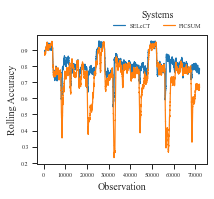

In [267]:

    
fig, ax = plt.subplots(figsize=get_plot_size(1, 2, 1, 1))
for res_path in found_paths:
    res_name = res_path[0].stem
    run_name = res_path[0].parent / f"{res_name.split('results_')[1]}.csv"
    run_df = pd.read_csv(run_name)
    run_df.head()
    rolling_acc = run_df['is_correct'].rolling(500).mean().to_numpy()
    sns.lineplot(data=rolling_acc[::1], label=res_path[1]['classifier'])
# plt.title(f"Dataset: {data_name}, Seed: {seed}")
plt.ylabel(f"Rolling Accuracy")
plt.xlabel(f"Observation")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, map({"CC": "SELeCT", "ficsum": "FICSUM"}.get, labels), loc="lower right", bbox_to_anchor=(1.0, 1.01), frameon=False, ncol=2, title="Systems" )
plt.savefig(output_location / fr"{output_prefix}-{data_name}-{seed}_rolling_acc.pdf", bbox_inches="tight")
plt.show()

0


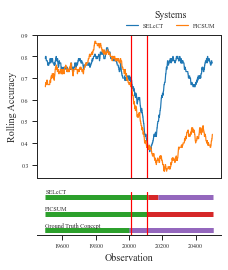

In [279]:
classifier_map = {"CC": "SELeCT", "ficsum": "FICSUM"}
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig = plt.figure(constrained_layout=True, figsize=get_plot_size(1.5, 2, 1.5, 1))
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 0.3])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1], sharex=ax1)
for i, res_path in enumerate(found_paths):
    res_name = res_path[0].stem
    run_name = res_path[0].parent / f"{res_name.split('results_')[1]}.csv"
    run_df = pd.read_csv(run_name)
    # run_df.head()
    # cd = run_df.iloc[17500:22500][['change_detected']].reset_index()
    # rolling_acc = run_df[['is_correct']].rolling(100).mean().iloc[17500:22500]
    view_range = [19500, 20500]
    cd = run_df.iloc[view_range[0]:view_range[1]][['change_detected']].reset_index()
    concept = run_df[['is_correct', 'active_model', 'ground_truth_concept']].iloc[view_range[0]:view_range[1]]
    rolling_acc = run_df[['is_correct']].rolling(100).mean().iloc[view_range[0]:view_range[1]]
    sns.lineplot(data=rolling_acc.reset_index(), x='index', y='is_correct', label=res_path[1]['classifier'], ax=ax1)
    
    line_y = len(found_paths)-i
    ax2.text(view_range[0], line_y+0.2, classifier_map.get(res_path[1]['classifier']))
    line_start = view_range[0]
    line_end = view_range[0]
    c = None
    ci = 2
    for k, row in concept.iterrows():
        cc = row['active_model']
        if c is not None and c != cc:
            ax2.hlines(y=line_y, xmin=line_start, xmax=k, colors=colors[int(ci)%len(colors)], lw=5)
            line_start = k
            ci += 1
        c = cc
    ax2.hlines(y=line_y, xmin=line_start, xmax=view_range[1], colors=colors[int(ci)%len(colors)], lw=5)

    line_y = 0
    if i == 0:
        ax2.text(view_range[0], line_y+0.2, f"Ground Truth Concept")
    line_start = view_range[0]
    line_end = view_range[0]
    c = None
    ci = 2
    for k, row in concept.fillna(0).iterrows():
        cc = row['ground_truth_concept']
        if c is not None and c != cc:
            ax2.hlines(y=line_y, xmin=line_start, xmax=k, colors=colors[int(ci)%len(colors)], lw=5)
            line_start = k
            ci += 1
        c = cc
    ax2.hlines(y=line_y, xmin=line_start, xmax=view_range[1], colors=colors[int(ci)%len(colors)], lw=5)
        
    # sns.lineplot(data=rolling_acc.reset_index(), x='index', y='is_correct', label=res_path[1]['classifier'])
    if res_path[1]['classifier'] == 'ficsum':
        rows = 0
        for k, row in cd[cd['change_detected'] == 1].iterrows():
            ax1.axvline(x=row['index'], color="red")
            ax2.axvline(x=row['index'], color="red")
        print(rows)
# plt.title(f"Dataset: {data_name}, Seed: {seed}")
plt.ylabel(f"Rolling Accuracy")
plt.xlabel(f"Observation")
handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, map(classifier_map.get, labels))
ax1.legend(handles, map({"CC": "SELeCT", "ficsum": "FICSUM"}.get, labels), loc="lower right", bbox_to_anchor=(1.0, 1.01), frameon=False, ncol=2, title="Systems" )
plt.ylim([-0.25, 2.3])
fig = plt.gcf()
# fig.set_size_inches(5, 5)
ax1.set_ylabel("Rolling Accuracy")
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.savefig(output_location / fr"{output_prefix}-{data_name}-{seed}_rolling_acc_combined.pdf")
plt.show()

### MEMORY MANAGEMENT - SELeCT

In [317]:
data_location = data_path / "Overall" / "select_mem_l2"
data_location.exists()

True

In [318]:
results_files = list(data_location.rglob('results*'))
results = []
for rp in tqdm(results_files):
    result = json.load(rp.open('r'))
    results.append(result)

df = pd.DataFrame(results)

  0%|          | 0/8640 [00:00<?, ?it/s]

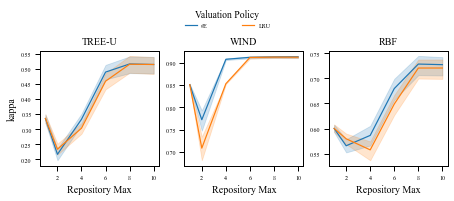

In [50]:
data_names = ['RTREESAMPLE_HARD', 'WINDSIM', 'RBFMed']
data_name_map = {
    "RTREESAMPLE_HARD": "TREE-U",
    "WINDSIM" : "WIND",
    "RBFMed": "RBF"
}
label_map = {
    "rA": "#E",
    "LRU": "LRU"
}
# classifier = 'ficsum'
classifier = 'cc'
# classifier = 'advantage'
# classifier = 'airstream'
fig, axs = plt.subplots(1, len(data_names), figsize=get_plot_size(1, 1, 1, 1), sharey=False)
if len(data_names) == 1:
    axs = [axs]
for i, dn in enumerate(data_names):
    dn_df = df[df['data_name'] == dn]
    dn_df = dn_df[dn_df['classifier'] == classifier]
    ax = axs[i]
    g = sns.lineplot(data=dn_df, x='repository_max', y='kappa', hue='valuation_policy', hue_order=['rA', 'LRU'], ax=ax)
    h, l = g.get_legend_handles_labels()
    ax.legend().remove()
    if i > 0:
        ax.get_yaxis().label.set_visible(False)
    ax.set_xlabel("Repository Max")
    ax.set_title(data_name_map[dn])
l = [label_map[x] for x in l]
fig.legend(h, l, bbox_to_anchor=(0.4,1.0,0.2,0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=4, frameon=False, title="Valuation Policy")
fig.tight_layout()
# plt.show()
plt.savefig(output_location / f"{output_prefix}-mem_management_2.pdf", bbox_inches="tight")

# Chaper 8

In [87]:
output_location = pathlib.Path("Chap8")
if not output_location.exists():
    output_location.mkdir(parents=True)
output_prefix = "CASE"
plt.rc('lines', linewidth=0.5)  

In [175]:
def ts_to_ranges(ts):
    ranges = []
    prev_val = None
    for i, v in enumerate(ts.values):
        if np.isnan(v):
            continue
        if prev_val != v:
            if prev_val != None:
                ranges[-1][1] = i-1
            ranges.append([i, None, int(v)])
        prev_val = v
    ranges[-1][1] = ts.shape[0]
    # print(ranges)
    return ranges

def plot_probabilities(df, prob_column, focus, experiment_name="default", data_name="default", save_file=False, save_location="", save_name="", run_individual=False, smoothing=True, plot_state_relevance=True, plot_accuracy=True, flatten=False):
    
    active_model = df['active_model']
    merge_model = df['merge_model'] if 'merge_model' in df.columns else None
    repair_model = df['repair_model'] if 'repair_model' in df.columns else None
    gt_model = df['ground_truth_concept']
    active_model_ranges = ts_to_ranges(active_model)
    merge_model_ranges = ts_to_ranges(merge_model) if merge_model is not None else None
    repair_model_ranges = ts_to_ranges(repair_model) if repair_model is not None else None
    gt_model_ranges = ts_to_ranges(gt_model)
    unique_gt_names = []
    for _,_,gt_name in gt_model_ranges:
        if gt_name not in unique_gt_names:
            unique_gt_names.append(gt_name)

    del_cols = []
    val_nas = {}

    gt_colors = plt.cm.tab10.colors
    gt_styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
    gt_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

    dms = df['deletions'].dropna().values
    deleted_models = []
    for dm in dms:
        try:
            deleted_models.append(int(float(dm)))
        except:
            ids = dm.split(';')
            # print(ids)
            for id in ids:
                if len(id) > 0:
                    deleted_models.append(int(float(id)))
    if plot_state_relevance:                
        probs = df[prob_column].str.split(';', expand=True)
        for c in probs.columns:
            unique_ids = probs[c].str.rsplit(':').str[0].astype('float').unique()
            col_ids = probs[c].str.rsplit(':').str[0].astype('float')
            prob_vals = probs[c].str.rsplit(':').str[-1].astype('float')
            for u_id in unique_ids:
                if np.isnan(u_id):
                    continue
                indexes = col_ids == u_id
                if f"v{u_id}" not in probs.columns:
                    probs[f"v{u_id}"] = np.nan
                probs.loc[indexes, f"v{u_id}"] = prob_vals.loc[indexes]
                if u_id in deleted_models:
                    del_cols.append(f"v{u_id}")
            probs[c] = probs[c].str.rsplit(':').str[-1].astype('float')
            val_nas[c] = probs[c].isna().sum()
            
            del_cols.append(c)
        # print(val_nas)
        probs = probs.drop(del_cols, axis=1)
        del_cols = []
        for c in probs.columns:
            probs[int(float(c[1:]))] = probs[c]
            del_cols.append(c)
        probs = probs.drop(del_cols, axis=1)
        probs['ts'] = probs.index
        # print(probs)
        m_df = pd.melt(probs.iloc[::10, :], id_vars='ts')
        m_df['variable'] = m_df['variable'].astype('category')
        m_df['value'] = m_df['value'].replace({-1:0})
        if smoothing:
            m_df['value'] = m_df['value'].rolling(window=7).mean()
    # print(m_df)
    fig, (ax, ax_b) = plt.subplots(nrows=2, figsize=get_plot_size(1.5, 1, 1.5, 1), sharex=True, gridspec_kw={'height_ratios':[0.7, 0.3]})

    active_state_CF1 = {}
    active_state_color = {}
    merge_state_CF1 = {}
    merge_state_color = {}
    repair_state_CF1 = {}
    repair_state_color = {}
    gt_timesteps = {}
    for gt in unique_gt_names:
        gt_ts = set(df[df['ground_truth_concept'] == gt]['example'].values)
        gt_timesteps[gt] = gt_ts

    for state_id in df['active_model'].unique():
        state_ts = set(df[df['active_model'] == state_id]['example'].values)
        if len(state_ts) == 0:
            continue
        state_CF1_per_gt = []
        for gt in unique_gt_names:
            gt_ts = gt_timesteps[gt]
            recall = len(state_ts.intersection(gt_ts)) / len(gt_ts)
            precision = len(state_ts.intersection(gt_ts)) / len(state_ts)
            CF1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
            state_CF1_per_gt.append((CF1, gt))
        max_CF1, best_gt = max(state_CF1_per_gt, key=lambda x: x[0])
        active_state_CF1[state_id] = (max_CF1, best_gt)
        color = gt_colors[best_gt]
        style = gt_styles[best_gt]
        active_state_color[state_id] = color, style
        if plot_state_relevance:
            context_match = active_state_CF1[state_id][1]
            context_label = gt_labels[unique_gt_names.index(context_match)]
            alpha_val = 1 if context_label in focus else 0.25
            ax.plot(m_df[m_df['variable'] == state_id]['ts'].values, m_df[m_df['variable'] == state_id]['value'].values, c=color, label=str(state_id), alpha=alpha_val, linestyle=style)    
    for state_id in df['merge_model'].unique():
        state_ts = set(df[df['merge_model'] == state_id]['example'].values)
        if len(state_ts) == 0:
            continue
        state_CF1_per_gt = []
        for gt in unique_gt_names:
            gt_ts = gt_timesteps[gt]
            recall = len(state_ts.intersection(gt_ts)) / len(gt_ts)
            precision = len(state_ts.intersection(gt_ts)) / len(state_ts)
            CF1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
            state_CF1_per_gt.append((CF1, gt))
        max_CF1, best_gt = max(state_CF1_per_gt, key=lambda x: x[0])
        merge_state_CF1[state_id] = (max_CF1, best_gt)
        color = gt_colors[best_gt]
        style = gt_styles[best_gt]
        merge_state_color[state_id] = color, style
    for state_id in df['repair_model'].unique():
        state_ts = set(df[df['repair_model'] == state_id]['example'].values)
        if len(state_ts) == 0:
            continue
        state_CF1_per_gt = []
        for gt in unique_gt_names:
            gt_ts = gt_timesteps[gt]
            recall = len(state_ts.intersection(gt_ts)) / len(gt_ts)
            precision = len(state_ts.intersection(gt_ts)) / len(state_ts)
            CF1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
            state_CF1_per_gt.append((CF1, gt))
        max_CF1, best_gt = max(state_CF1_per_gt, key=lambda x: x[0])
        repair_state_CF1[state_id] = (max_CF1, best_gt)
        color = gt_colors[best_gt]
        style = gt_styles[best_gt]
        repair_state_color[state_id] = color, style

    # sns.lineplot(data=m_df[m_df['variable'] != '-1'], x='ts', y='value', hue='variable', ax=ax, linewidth=0.5)
    # sns.scatterplot(data=m_df[m_df['variable'] != '-1'], x='ts', y='value', hue='variable', ax=ax, linewidth=0.5)
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    # print(labels)
    for rs, re, v in active_model_ranges:
        y_val = -0.2
        if v not in active_state_CF1:
            continue
        op = active_state_CF1[v][0]
        context_match = active_state_CF1[v][1]
        context_label = gt_labels[unique_gt_names.index(context_match)]
        alpha_val = 1 if context_label in focus else 0.25
        # if str(v) in labels:
            # color = handles[labels.index(str(v))].get_color()
        color, style = active_state_color[v]
        ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], lw=3*op, alpha=alpha_val)
        # else:
        #     ax_b.hlines(y = y_val + 0.005, xmin = rs, xmax = re, colors=["red"], alpha=alpha_val)
        mid_point = (rs+re)/2
        ax_b.annotate(str(v),
        xy=(mid_point, y_val+0.05),
        xycoords='data',
        bbox={'boxstyle':'circle,pad=0.2',
            'fc':'white',
            'ec': color,
            'alpha':alpha_val, 'linestyle':style, 'linewidth':0.5},
        fontsize=SMALL_SIZE,
        ha='center',
        va='bottom',
        alpha=alpha_val
        )
    ax_b.annotate("Active States: ",
    xy=(0, y_val),
    xycoords='data',
    ha='right',
    va='center'
    )
    if merge_model_ranges is not None:
        for rs, re, v in merge_model_ranges:
            y_val = -0.5
            # if str(v) in labels:
                # color = handles[labels.index(str(v))].get_color()
            # if v not in active_state_CF1:
            #     continue
            op = merge_state_CF1[v][0]
            context_match = merge_state_CF1[v][1]
            context_label = gt_labels[unique_gt_names.index(context_match)]
            alpha_val = 1 if context_label in focus else 0.25
            color, style = merge_state_color[v]
            ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], lw=3*op, alpha=alpha_val)
            # else:
            #     ax_b.hlines(y = y_val + 0.005, xmin = rs, xmax = re, colors=["red"])
            mid_point = (rs+re)/2
            ax_b.annotate(str(v),
            xy=(mid_point, y_val+0.05),
            xycoords='data',
            bbox={'boxstyle':'circle,pad=0.2',
                'fc':'white',
                'ec': color,
                'alpha':alpha_val, 'linestyle':style, 'linewidth':0.5},
            fontsize=SMALL_SIZE,
            ha='center',
            va='bottom', 
            alpha=alpha_val
            )
        ax_b.annotate("With Merging: ",
        xy=(0, y_val),
        xycoords='data',
        ha='right',
        va='center'
        )
    if repair_model_ranges is not None:
        for rs, re, v in repair_model_ranges:
            y_val = -0.8
            # if str(v) in labels:
                # color = handles[labels.index(str(v))].get_color()
            # if v not in active_state_CF1:
            #     continue
            op = repair_state_CF1[v][0]
            context_match = repair_state_CF1[v][1]
            context_label = gt_labels[unique_gt_names.index(context_match)]
            alpha_val = 1 if context_label in focus else 0.25
            color, style = repair_state_color[v]
            ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], lw=3*op, alpha=alpha_val)
            # else:
            #     ax_b.hlines(y = y_val + 0.005, xmin = rs, xmax = re, colors=["red"])
            mid_point = (rs+re)/2
            ax_b.annotate(str(v),
            xy=(mid_point, y_val+0.05),
            xycoords='data',
            bbox={'boxstyle':'circle,pad=0.2',
                'fc':'white',
                'ec': color,
                'alpha':alpha_val, 'linestyle':style, 'linewidth':0.5},
            fontsize=SMALL_SIZE,
            ha='center',
            va='bottom', 
            alpha=alpha_val
            )
        ax_b.annotate("With Repair: ",
        xy=(0, y_val),
        xycoords='data',
        ha='right',
        va='center'
        )
    for rs, re, v in gt_model_ranges:
        # if str(v) in labels:
            # color = handles[labels.index(str(v))].get_color()
        color = gt_colors[unique_gt_names.index(v)]
        style = gt_styles[unique_gt_names.index(v)]
        context_label = gt_labels[unique_gt_names.index(v)]
        alpha_val = 1 if context_label in focus else 0.25
        y_val = -1.1
        ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], alpha=alpha_val)
        mid_point = (rs+re)/2
        gt_label = gt_labels[unique_gt_names.index(v)]
        ax_b.annotate(gt_label,
        xy=(mid_point, y_val),
        xycoords='data',
        bbox={'boxstyle':'circle,pad=0.2',
            'fc':'white',
            'ec': color,
            'alpha':alpha_val, 'linestyle':style, 'linewidth':0.5},
        ha='center',
        va='center', 
        alpha=alpha_val
        )
    ax_b.annotate("True Contexts: ",
    xy=(0, y_val),
    xycoords='data',
    ha='right',
    va='center'
    )

    # ax.set_ylim((0, 1))

    if plot_accuracy:
        ax.set_ylim(0, 1)
    if plot_accuracy:
        ax_acc = ax.twinx()
        # selected = (df['ground_truth_concept'].isin(unique_gt_names))
        focus_as_index = map(lambda x: unique_gt_names[gt_labels.index(x)], focus)
        selected = (df['ground_truth_concept'].isin(focus_as_index))
        selected_example_num = df[selected]['example']
        rolling_acc = df[selected]['is_correct'].rolling(500).mean()
        sum_acc = df[selected]['is_correct'].cumsum()
        count = selected.cumsum()
        avg_acc = sum_acc / count[selected]
        # ax_acc.plot(df['example'].values, df['overall_accuracy'].values, c="red")
        ax_acc.plot(selected_example_num.values, rolling_acc.values, c="red")
        ax_acc.plot(selected_example_num.values, avg_acc.values, c="red", ls='--')
        if plot_state_relevance:
            ax_acc.set_ylabel('Accuracy', color="red")
            ax_acc.tick_params(axis='y', labelcolor="red")
            ax_acc.set_ylim((0, 1))
        else:
            ax_acc.get_yaxis().set_ticks([])
            ax_acc.set_ylim((0, 1))
        
        ax_acc.spines['top'].set_visible(False)
        ax_acc.spines['right'].set_visible(False)
        ax_acc.spines['bottom'].set_visible(False)

    plt.xlim((0, df.shape[0]))
    # ax.set_title(f"{prob_column.replace('_', ' ')}")
    ax.get_legend().remove()
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.xaxis.set_tick_params(which='both', labelbottom=True)
    # ax.get_xaxis().set_ticks([])
    ax.tick_params(labelbottom=False, length=0)

    # ax_b.axis('off')
    ax_b.spines['top'].set_visible(False)
    ax_b.spines['right'].set_visible(False)
    # ax_b.spines['bottom'].set_visible(False)
    ax_b.spines['left'].set_visible(False)
    ax_b.get_yaxis().set_ticks([])
    ax_b.set_xlabel("Number of Observations")
    if plot_state_relevance:
        ax.set_ylabel("State Relevance")
    else:
        ax.set_ylabel("Accuracy")
    ax_b.set_ylim((-1.2, -0.1))

    fig.tight_layout()
    if save_file:
        print(pathlib.Path.cwd())
        plt.savefig(save_location / f"{save_name}-{focus}-{plot_state_relevance}-{plot_accuracy}.{'pdf' if not flatten else 'png'}", facecolor='white', transparent=False, bbox_inches="tight", flatten=flatten, dpi=300)
    else:
        plt.show()
    if not run_individual:
        return
    for c in m_df['variable'].unique():
        df_variable = m_df[m_df['variable'] == c]

        sns.scatterplot(data=df_variable[df_variable['value'].diff() != 0], x='ts', y='value', hue='variable')
        # sns.lineplot(data=m_df[m_df['variable'] == c], x='ts', y='value', hue='variable')
        if save_file:
            plt.savefig(f"explore_probabilities/{experiment_name}-{data_name}-{c}.pdf")
        plt.show()

### Advantage figure

In [145]:
data_location =data_path / "Casestudy" / "AdvantageComparison"
data_location.exists()

True

s:\PhD\Packages\PhDCode\evaluation\thesis


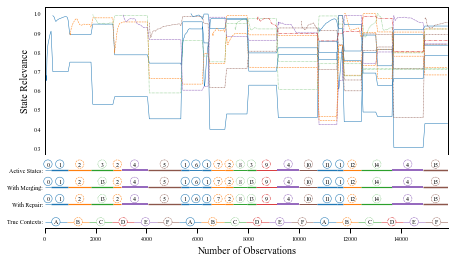

In [146]:
# ADV
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\t_advantage_SR\PhDCode-master-fbcfc0a\Arabic_advantage\18\run_6527545193769659343_0.csv"
path_to_csv = data_location / r"run_6527545193769659343_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = True
plot_accuracy = False
save_name = "advantage-comparison-ADV-I"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

s:\PhD\Packages\PhDCode\evaluation\thesis


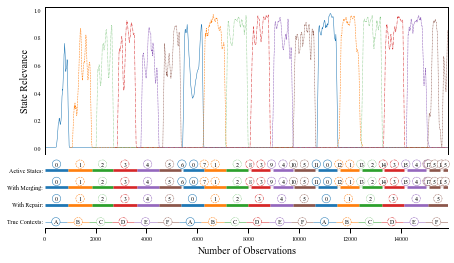

In [147]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\t_advantage_SR\PhDCode-master-fbcfc0a\Arabic\18\run_-8517299681780429396_0.csv"
path_to_csv = data_location / r"run_-8517299681780429396_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = True
plot_accuracy = False
save_name = "advantage-comparison-SELeCT-I"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


s:\PhD\Packages\PhDCode\evaluation\thesis


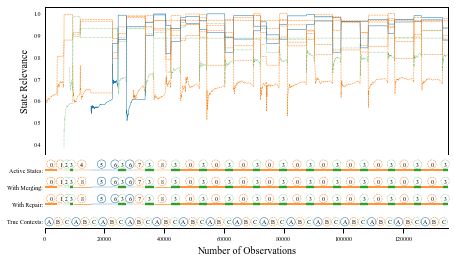

In [148]:
# ADV
path_to_csv = data_location / "run_-1515304942937934001_0.csv"
# SELeCT
# path_to_csv = data_location / "run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C']
# focus=['A', 'B']
# focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = True
plot_accuracy = False
save_name = "advantage-comparison-ADV"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


s:\PhD\Packages\PhDCode\evaluation\thesis


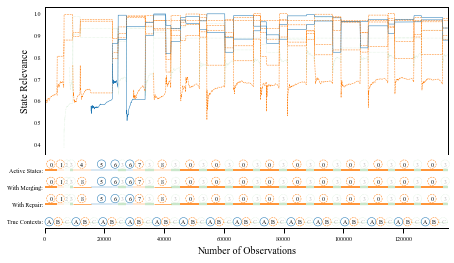

In [149]:
# ADV
path_to_csv = data_location / "run_-1515304942937934001_0.csv"
# SELeCT
# path_to_csv = data_location / "run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
focus=['A', 'B']
# focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = True
plot_accuracy = False
save_name = "advantage-comparison-ADV"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

s:\PhD\Packages\PhDCode\evaluation\thesis


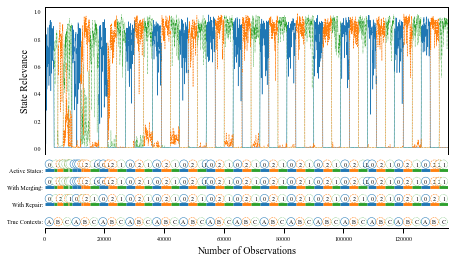

In [150]:
# SELeCT
path_to_csv = data_location / "run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C']
# focus=['A', 'B']
# focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = True
plot_accuracy = False
save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

s:\PhD\Packages\PhDCode\evaluation\thesis


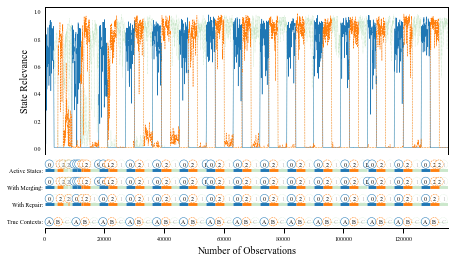

In [151]:
# SELeCT
path_to_csv = data_location / "run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
focus=['A', 'B']
# focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = True
plot_accuracy = False
save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

### Accuracy

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


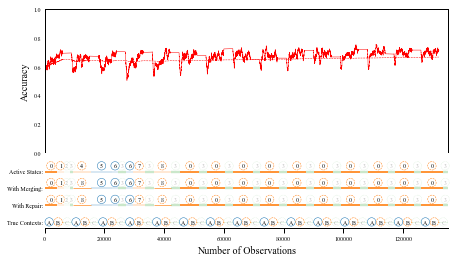

In [152]:
# ADV
path_to_csv = data_location / "run_-1515304942937934001_0.csv"
# SELeCT
# path_to_csv = data_location / "run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
focus=['A', 'B']
# focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "advantage-comparison-ADV-accuracy"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


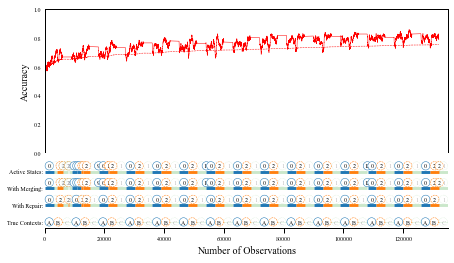

In [153]:
# ADV
# path_to_csv = data_location / "run_-1515304942937934001_0.csv"
# SELeCT
path_to_csv = data_location / "run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
focus=['A', 'B']
# focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "advantage-comparison-ADV-SELeCT"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

### CNDPM experiment

In [64]:
data_location =data_path / "Casestudy" / "CNDPMComparison"
data_location.exists()

True

Short Arabic -cc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


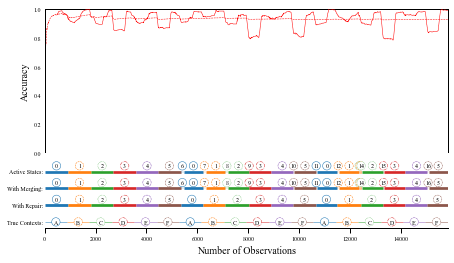

In [164]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\cndpm_comparison\PhDCode-master-1a0aa45\Arabic\2\run_-4833921452513628429_0.csv"
path_to_csv = data_location / r"run_-4833921452513628429_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "cndpm-comparison-SELeCT"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

Short Arabic - cc cndpm base

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


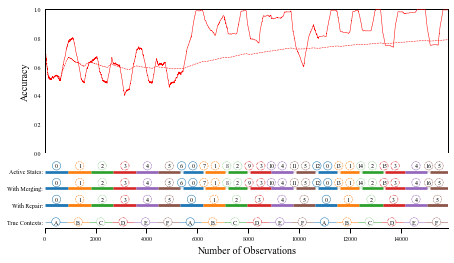

In [165]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\cndpm_comparison\PhDCode-master-1a0aa45\Arabic\2\run_7015076232704290810_0.csv"
path_to_csv = data_location / r"run_7015076232704290810_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "cndpm-comparison-SELeCT-cndpm_base"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

In [70]:
path_to_csv = data_location / r"run_7015076232704290810_0.csv"
df = pd.read_csv(path_to_csv)
state_history = df['repair_model']
(state_history.diff() != 0).sum()

18

SHort Arabic - cndpm prior

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


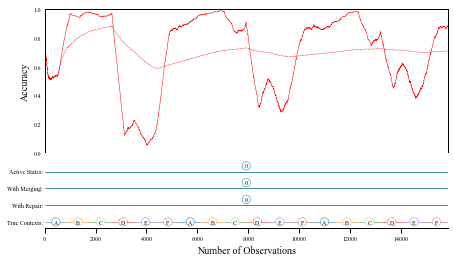

In [166]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\cndpm_comparison\PhDCode-master-1a0aa45\Arabic\2\run_2789321365962527231_0.csv"
path_to_csv = data_location / r"run_2789321365962527231_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "cndpm-comparison-CNDPM-prior"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

Short Arabic - cndpm no-prior

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


C:\Users\Ben\AppData\Local\Temp/ipykernel_84148/3813207399.py:341: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "flatten" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_location / f"{save_name}-{focus}-{plot_state_relevance}-{plot_accuracy}.{'pdf' if not flatten else 'png'}", facecolor='white', transparent=False, bbox_inches="tight", flatten=flatten, dpi=300)


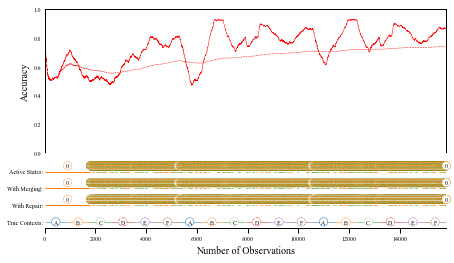

In [176]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\cndpm_comparison\PhDCode-master-1a0aa45\Arabic\2\run_6528714596228183659_0.csv"
path_to_csv = data_location / r"run_6528714596228183659_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "cndpm-comparison-CNDPM-noprior"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location, flatten=True)

In [69]:
path_to_csv = data_location / r"run_6528714596228183659_0.csv"
df = pd.read_csv(path_to_csv)
state_history = df['repair_model']
(state_history.diff() != 0).sum()

6775

Short Arabic - UpperBound

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


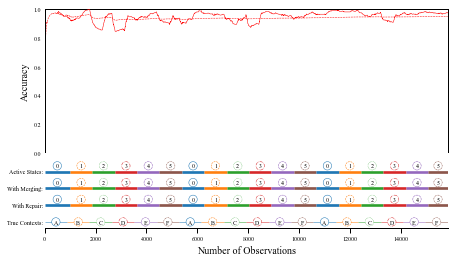

In [167]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\cndpm_comparison\PhDCode-master-1a0aa45\Arabic\2\run_1077546576240376245_0.csv"
path_to_csv = data_location / r"run_1077546576240376245_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "cndpm-comparison-UB"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

Short Arabic - UpperBound - cndpm_base

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


s:\PhD\Packages\PhDCode\evaluation\thesis


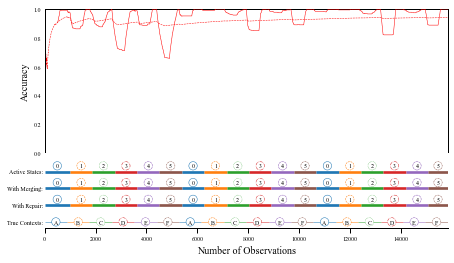

In [168]:
# path_to_csv = r"S:\PhD\Packages\PhDCode\output\cndpm_comparison\PhDCode-master-1a0aa45\Arabic\2\run_-3060671018603268805_0.csv"
path_to_csv = data_location / r"run_-3060671018603268805_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
# focus=['A', 'B', 'C']
# focus=['A', 'B']
focus=['A', 'B', 'C', "D", "E", "F"]
plot_state_relevance = False
plot_accuracy = True
save_name = "cndpm-comparison-UB-cndpm_base"
# save_name = "advantage-comparison-SELeCT"
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, plot_state_relevance=plot_state_relevance, plot_accuracy=plot_accuracy, save_name=save_name, save_file=f"{output_prefix}-{save_file}", save_location=output_location)

## State evaluation

In [254]:
def ts_to_ranges(ts, start=0):
    ranges = []
    prev_val = None
    ts_vals = ts.values if hasattr(ts, 'values') else ts
    for i, v in enumerate(ts_vals, start=start):
        if np.isnan(v):
            continue
        if prev_val != v:
            if prev_val != None:
                ranges[-1][1] = i-1
            ranges.append([i, None, int(v)])
        prev_val = v
    ranges[-1][1] = ts.shape[0] + start if hasattr(ts, 'shape') else len(ts) + start
    # print(ranges)
    return ranges
    
class BasicNB:
    """
    Basic Naive Bayes classifier for 1D X and y.
    If an X value is seen which is not in training set, mark as a failed prediction.
    """
    def __init__(self):
        self.p_X = {}
        self.p_y = {}
        self.p_Xy = {}
    
    def get_key(self, x_val, y_val):
        return str(int(x_val)) +':' + str(int(y_val))

    def fit(self, X_train, y_train):
        count_X = Counter()
        count_y = Counter()
        count_Xy= Counter()

        for x_val, y_val in zip(X_train, y_train):
            count_X[x_val] += 1
            count_y[y_val] += 1
            count_Xy[self.get_key(x_val, y_val)] += 1
        
        total_count = X_train.shape[0]

        for k, v in count_X.items():
            self.p_X[k] = v / total_count
        for k, v in count_y.items():
            self.p_y[k] = v / total_count
        for k, v in count_Xy.items():
            x_val, y_val = map(lambda x: int(float(x)), k.split(':'))
            total_count_for_y = count_y[y_val]
            self.p_Xy[k] = v / total_count_for_y
        
    def predict(self, X_test):
        predictions = []
        for x_val in X_test:
            class_predictions = {}
            for y_val in self.p_y:
                key = self.get_key(x_val, y_val)
                if key not in self.p_Xy:
                    class_predictions[y_val] = -1
                    continue
                class_predictions[y_val] = self.p_Xy[key] * self.p_y[y_val]
            
            prediction, prob = max(class_predictions.items(), key = lambda x: x[1])
            if prob == -1:
                prediction = -1
            predictions.append(prediction)
        return predictions
    
    def get_accuracy(self, predictions, y_test):
        right = 0
        wrong = 0
        for p, y in zip(predictions, y_test):
            right += p == y
            wrong += p != y
        
        return right / (right + wrong)

def mean_stdev_size(X):
    return f"{np.mean(X):.2f}|{np.std(X):.2f}<{len(X)}>"

def get_accuracy_increase(df : pd.DataFrame, n_obs_first_check:int, n_obs_second_check:int) -> float:
    """ Get the increase in accuracy between the timestep given by n_obs_first_check and n_obs_second_check.
    The DataFrame df should include an 'example' column with the number of examples seen at each row, and a overall_accuracy column with the overall_accuracy up to that row.
    """

    first_check_accuracy = df[df['example'] == n_obs_first_check].iloc[0]['overall_accuracy']
    second_check_accuracy = df[df['example'] == n_obs_second_check].iloc[0]['overall_accuracy']
    return second_check_accuracy - first_check_accuracy

def get_bayesian_CI_accuracy(df : pd.DataFrame, n_obs_training_period:int) -> float:
    """ Get the accuracy of a Naive Bayes classifier trained to take the active state and predict ground truth context on the training period over the remaining stream.
    The DataFrame df should include an 'example' column with the number of examples seen at each row, and an 'active_model' column with the active state at each observation, 
    and a ground_truth_concept column with the ground truth context. Optionally, merge_model and repair_model columns can be included for repaired active states.
    """

    active_model = df['active_model']
    merge_model = df['merge_model'] if 'merge_model' in df.columns else active_model
    repair_model = df['repair_model'] if 'repair_model' in df.columns else merge_model
    gt_model = df['ground_truth_concept'].fillna(-1).values
    CI_inference_classifier = BasicNB()
    y_train = gt_model[df['example'] < n_obs_training_period]
    y_test = gt_model[df['example'] >= n_obs_training_period]
    X_train = repair_model[df['example'] < n_obs_training_period].values
    X_test = repair_model[df['example'] >= n_obs_training_period].values
    CI_inference_classifier.fit(X_train, y_train)
    predicted_context = CI_inference_classifier.predict(X_test)
    accuracy = CI_inference_classifier.get_accuracy(predicted_context, y_test)

    return accuracy

def get_LL_results(experiment_name):
    file_path = pathlib.Path(__file__).resolve()
    main_dir = file_path.parents[1]

    # Collect results
    output = main_dir / 'output' / experiment_name
    results_files = list(output.rglob('results*'))
    results = []
    for rp in tqdm.tqdm(results_files):
        result = json.load(rp.open('r'))
        run_log_path = rp.parent / f"{rp.stem.split('results_')[1]}.csv"
        run_df = pd.read_csv(run_log_path)
        accuracy_increase = get_accuracy_increase(run_df, int(run_df.shape[0] * 0.05), int(run_df.shape[0] * 0.9))
        result['accuracy_increase'] = accuracy_increase
        bayesian_CI_accuracy = get_bayesian_CI_accuracy(run_df, int(run_df.shape[0] * 0.1))
        result['bayesian_CI_accuracy'] = bayesian_CI_accuracy
        results.append(result)
    
    df = pd.DataFrame(results)
    df = df[(df['classifier'] != 'cc') | (df['buffer_ratio'] == 0.025)]
    classification_performance_metric = 'kappa'
    adaption_performance_metric = 'GT_mean_f1' # measure for C-F1
    print("**************TEST RESULTS**************")
    pd.set_option('display.max_rows', 500)
    print(df.groupby(['data_name', 'classifier', "fs_method"])[[classification_performance_metric, adaption_performance_metric, 'accuracy_increase', 'bayesian_CI_accuracy', 'driftdetect_50_kappa']].aggregate(mean_stdev_size))
    return df
    
def plot_probabilities(df, prob_column, focus, context, CI_train_len, experiment_name="default", data_name="default", save_file=False, save_location = "", save_name="", run_individual=False, smoothing=True, plot_state_relevance=True, plot_inference=True):
    active_model = df['active_model']
    merge_model = df['merge_model'] if 'merge_model' in df.columns else active_model
    repair_model = df['repair_model'] if 'repair_model' in df.columns else merge_model
    gt_model = df['ground_truth_concept']
    active_model_ranges = ts_to_ranges(active_model)
    merge_model_ranges = ts_to_ranges(merge_model) if merge_model is not None else active_model_ranges
    repair_model_ranges = ts_to_ranges(repair_model) if repair_model is not None else merge_model_ranges
    gt_model_ranges = ts_to_ranges(gt_model)
    unique_gt_names = []
    for _,_,gt_name in gt_model_ranges:
        if gt_name not in unique_gt_names:
            unique_gt_names.append(gt_name)

    del_cols = []
    val_nas = {}

    gt_colors = plt.cm.tab10.colors
    gt_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    gt_name_color_map = lambda n: gt_colors[unique_gt_names.index(n)]

    dms = df['deletions'].dropna().values
    deleted_models = []
    for dm in dms:
        try:
            deleted_models.append(int(float(dm)))
        except:
            ids = dm.split(';')
            # print(ids)
            for id in ids:
                if len(id) > 0:
                    deleted_models.append(int(float(id)))
    if plot_state_relevance:
        probs = df[prob_column].str.split(';', expand=True)
        for c in probs.columns:
            unique_ids = probs[c].str.rsplit(':').str[0].astype('float').unique()
            col_ids = probs[c].str.rsplit(':').str[0].astype('float')
            prob_vals = probs[c].str.rsplit(':').str[-1].astype('float')
            for u_id in unique_ids:
                if np.isnan(u_id):
                    continue
                indexes = col_ids == u_id
                if f"v{u_id}" not in probs.columns:
                    probs[f"v{u_id}"] = np.nan
                probs.loc[indexes, f"v{u_id}"] = prob_vals.loc[indexes]
                if u_id in deleted_models:
                    del_cols.append(f"v{u_id}")
            probs[c] = probs[c].str.rsplit(':').str[-1].astype('float')
            val_nas[c] = probs[c].isna().sum()
            
            del_cols.append(c)
        # print(val_nas)
        probs = probs.drop(del_cols, axis=1)
        del_cols = []
        for c in probs.columns:
            probs[int(float(c[1:]))] = probs[c]
            del_cols.append(c)
        probs = probs.drop(del_cols, axis=1)
        probs['ts'] = probs.index
        # print(probs)
        m_df = pd.melt(probs.iloc[::10, :], id_vars='ts')
        m_df['variable'] = m_df['variable'].astype('category')
        m_df['value'] = m_df['value'].replace({-1:0})
        if smoothing:
            m_df['value'] = m_df['value'].rolling(window=7).mean()
    # print(m_df)
    if plot_state_relevance:
        fig, (ax, ax_b) = plt.subplots(nrows=2, figsize=get_plot_size(2, 1, 2, 1), sharex=True, gridspec_kw={'height_ratios':[0.7, 0.3]})
    else:
        fig, (ax, ax_b) = plt.subplots(nrows=2, figsize=get_plot_size(1, 1, 1, 1), sharex=True, gridspec_kw={'height_ratios':[0.0, 1.0]})

    active_state_CF1 = {}
    active_state_color = {}
    merge_state_CF1 = {}
    merge_state_color = {}
    repair_state_CF1 = {}
    repair_state_color = {}
    gt_timesteps = {}
    for gt in unique_gt_names:
        gt_ts = set(df[df['ground_truth_concept'] == gt]['example'].values)
        gt_timesteps[gt] = gt_ts

    for state_id in df['active_model'].unique():
        state_ts = set(df[df['active_model'] == state_id]['example'].values)
        if len(state_ts) == 0:
            continue
        state_CF1_per_gt = []
        for gt in unique_gt_names:
            gt_ts = gt_timesteps[gt]
            recall = len(state_ts.intersection(gt_ts)) / len(gt_ts)
            precision = len(state_ts.intersection(gt_ts)) / len(state_ts)
            CF1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
            state_CF1_per_gt.append((CF1, gt))
        max_CF1, best_gt = max(state_CF1_per_gt, key=lambda x: x[0])
        active_state_CF1[state_id] = (max_CF1, best_gt)
        color = gt_name_color_map(best_gt)
        active_state_color[state_id] = color
        if plot_state_relevance:
            context_match = active_state_CF1[state_id][1]
            context_label = gt_labels[unique_gt_names.index(context_match)]
            alpha_val = 1 if context_label in focus else 0.25
            ax.plot(m_df[m_df['variable'] == state_id]['ts'].values, m_df[m_df['variable'] == state_id]['value'].values, c=color, label=str(state_id), alpha=alpha_val)    
    for state_id in df['merge_model'].unique():
        state_ts = set(df[df['merge_model'] == state_id]['example'].values)
        if len(state_ts) == 0:
            continue
        state_CF1_per_gt = []
        for gt in unique_gt_names:
            gt_ts = gt_timesteps[gt]
            recall = len(state_ts.intersection(gt_ts)) / len(gt_ts)
            precision = len(state_ts.intersection(gt_ts)) / len(state_ts)
            CF1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
            state_CF1_per_gt.append((CF1, gt))
        max_CF1, best_gt = max(state_CF1_per_gt, key=lambda x: x[0])
        merge_state_CF1[state_id] = (max_CF1, best_gt)
        color = gt_name_color_map(best_gt)
        merge_state_color[state_id] = color
    for state_id in df['repair_model'].unique():
        state_ts = set(df[df['repair_model'] == state_id]['example'].values)
        if len(state_ts) == 0:
            continue
        state_CF1_per_gt = []
        for gt in unique_gt_names:
            gt_ts = gt_timesteps[gt]
            recall = len(state_ts.intersection(gt_ts)) / len(gt_ts)
            precision = len(state_ts.intersection(gt_ts)) / len(state_ts)
            CF1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
            print(state_id, gt, recall, precision, CF1)
            state_CF1_per_gt.append((CF1, gt))
        max_CF1, best_gt = max(state_CF1_per_gt, key=lambda x: x[0])
        repair_state_CF1[state_id] = (max_CF1, best_gt)
        color = gt_name_color_map(best_gt)
        repair_state_color[state_id] = color

    # sns.lineplot(data=m_df[m_df['variable'] != '-1'], x='ts', y='value', hue='variable', ax=ax, linewidth=0.5)
    # sns.scatterplot(data=m_df[m_df['variable'] != '-1'], x='ts', y='value', hue='variable', ax=ax, linewidth=0.5)
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    if repair_model_ranges is not None:
        for rs, re, v in repair_model_ranges:
            y_val = -0.2
            # if str(v) in labels:
                # color = handles[labels.index(str(v))].get_color()
            op = repair_state_CF1[v][0]
            context_match = repair_state_CF1[v][1]
            context_label = gt_labels[unique_gt_names.index(context_match)]
            alpha_val = 1 if context_label in focus else 0.25
            color = repair_state_color[v]
            ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], lw=3*op, alpha=alpha_val)
            # else:
            #     ax_b.hlines(y = y_val + 0.005, xmin = rs, xmax = re, colors=["red"])
            mid_point = (rs+re)/2
            ax_b.annotate(str(v),
            xy=(mid_point, y_val+0.04),
            xycoords='data',
            bbox={'boxstyle':'circle',
                'fc':'white',
                'ec': color,
                'alpha':alpha_val},
            fontsize=SMALL_SIZE,
            ha='center',
            va='bottom', 
            alpha=alpha_val
            )
        ax_b.annotate("Final Active State: ",
        xy=(0, y_val),
        xycoords='data',
        ha='right',
        va='center'
        )
    for rs, re, v in gt_model_ranges:
        # if str(v) in labels:
            # color = handles[labels.index(str(v))].get_color()
        color = gt_colors[unique_gt_names.index(v)]
        context_label = gt_labels[unique_gt_names.index(v)]
        alpha_val = 1 if context_label in focus else 0.25
        y_val = -0.6
        ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], alpha=alpha_val)
        mid_point = (rs+re)/2
        gt_label = gt_labels[unique_gt_names.index(v)]
        ax_b.annotate(gt_label,
        xy=(mid_point, y_val-0.04),
        xycoords='data',
        bbox={'boxstyle':'circle',
            'fc':'white',
            'ec': color,
            'alpha':alpha_val},
        fontsize=SMALL_SIZE,
        ha='center',
        va='center', 
        alpha=alpha_val
        )
    ax_b.annotate("True Contexts: ",
    xy=(0, y_val),
    xycoords='data',
    ha='right',
    va='center'
    )

    # Add box around trained samples
    ax_b.add_patch(mpatches.Rectangle((0, -0.7), CI_train_len, 0.625, facecolor="none", ec='black', lw=0.5, ls='--'))
    ax_b.annotate("Training\nInference",
    xy=(500, -0.3),
    xycoords='data',
    ha='left',
    va='top'
    )
    CI_inference_classifier = BasicNB()
    y_train = context[df['example'] < CI_train_len]
    y_test = context[df['example'] >= CI_train_len]
    X_train = repair_model[df['example'] < CI_train_len].values
    X_test = repair_model[df['example'] >= CI_train_len].values
    CI_inference_classifier.fit(X_train, y_train)
    predicted_context = CI_inference_classifier.predict(X_test)
    predicted_context_ranges = ts_to_ranges(predicted_context, CI_train_len)
    accuracy = CI_inference_classifier.get_accuracy(predicted_context, y_test)
    print(f"Accuracy of Context-Inference was: {accuracy}")
    for rs, re, v in predicted_context_ranges:
        # if str(v) in labels:
            # color = handles[labels.index(str(v))].get_color()
        color = gt_colors[unique_gt_names.index(v)] if v != -1 else "red"
        context_label = gt_labels[unique_gt_names.index(v)] if v != -1 else "N"
        alpha_val = 1 if context_label in focus else 0.25
        y_val = -0.4
        ax_b.hlines(y = y_val, xmin = rs, xmax = re, colors = [color], alpha=alpha_val)
        mid_point = (rs+re)/2
        gt_label = context_label
        ax_b.annotate(gt_label,
        xy=(mid_point, y_val+0.04),
        xycoords='data',
        bbox={'boxstyle':'circle',
            'fc':'white',
            'ec': color,
            'alpha':alpha_val},
        fontsize=SMALL_SIZE,
        ha='center',
        va='center', 
        alpha=alpha_val
        )
        ax_b.annotate("",
        xy=(mid_point, y_val+0.065),
        xytext=(mid_point, -0.2),
        xycoords='data',
        arrowprops={'arrowstyle':"->",
            'fc':'white',
            'ec': color,
            'alpha':alpha_val},
        ha='center',
        va='center', 
        alpha=alpha_val
        )
    ax_b.annotate("Inferred Contexts: ",
    xy=(0, y_val),
    xycoords='data',
    ha='right',
    va='center'
    )



    plt.xlim((0, df.shape[0]))
    # ax.set_title(f"{prob_column.replace('_', ' ')}")
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.xaxis.set_tick_params(which='both', labelbottom=True)
    # ax_b.axis('off')
    ax_b.spines['top'].set_visible(False)
    ax_b.spines['right'].set_visible(False)
    # ax_b.spines['bottom'].set_visible(False)
    ax_b.spines['left'].set_visible(False)
    ax_b.get_yaxis().set_ticks([])
    ax_b.set_xlabel("Number of Observations")
    ax_b.set_ylim((-0.725, -0.05))

    ax.set_ylabel("State Relevance")
    ax.set_ylim((0, 1))

    if plot_state_relevance is False:
        ax.axis('off')


    if save_file:
        print(pathlib.Path.cwd())
        fig.tight_layout()
        plt.savefig(save_location / f"{save_name}-{focus}-{plot_state_relevance}-{plot_accuracy}.pdf", facecolor='white', transparent=False, bbox_inches="tight")
    else:
        plt.show()
    if not run_individual:
        return
    for c in m_df['variable'].unique():
        df_variable = m_df[m_df['variable'] == c]

        sns.scatterplot(data=df_variable[df_variable['value'].diff() != 0], x='ts', y='value', hue='variable')
        # sns.lineplot(data=m_df[m_df['variable'] == c], x='ts', y='value', hue='variable')
        if save_file:
            plt.savefig(f"explore_probabilities/{experiment_name}-{data_name}-{c}.pdf")
        plt.show()


Advantage Comparison

In [179]:
data_location =data_path / "Casestudy" / "CI"
data_location.exists()

True

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0 0.6792708680671334 0.4449767733104222 0.5377102836629831
0 1 0.6910081138157164 0.45266560848101817 0.5470014781445766
0 2 0.15578526175391796 0.10205181226427458 0.12331949039206024
1 0 0.0 0.0 0
1 1 0.04232521951761698 0.8263888888888888 0.08052612658334919
1 2 0.008869623207735912 0.17317708333333334 0.016874960350187148
2 0 0.0 0.0 0
2 1 0.0 0.0 0
2 2 0.042503056574413695 1.0 0.0815403970403224
3 0 0.07940424585973102 0.10242293906810036 0.0894565489606812
3 1 0.0 0.0 0
3 2 0.6955429587640325 0.8971756272401433 0.7835962935136488
8 0 0.11532733133266644 0.4365166175851914 0.18245120450149463
8 1 0.13333333333333333 0.504669751787968 0.21093722525057146
8 2 0.015449594309214183 0.05847707193941944 0.024441709161244947
5 0 0.06666666666666667 0.418445653690526 0.11500997085442553
5 1 0.036145381793931314 0.22687316868982838 0.062356189599631864
5 2 0.05646326553295543 0.35440212083158923 0.0974075778493634
6 0 0.05181727242414138 0.5525005925574781 0.09474839443947647
6 1 0.03052

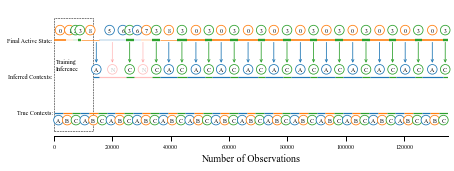

In [266]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\t_reuse_benefit\PhDCode-master-053ef69\RTREESAMPLE_Diff\2\run_-1515304942937934001_0.csv"
path_to_csv =data_location / r"run_-1515304942937934001_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-advantage_comparison-ADV"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 0 0.9740802489718795 0.969168159600115 0.9716179959644338
0.0 1 0.03065466266533289 0.03050007741136399 0.03057717466019202
0.0 2 0.0 0.0 0
1.0 0 0.025919751028120483 0.02553993078372103 0.02572843919284193
1.0 1 0.02812048460597977 0.027708415472904892 0.027912929312988888
1.0 2 0.9604979437590307 0.9464230954571341 0.9534085768819162
2.0 0 0.0 0.0 0
2.0 1 0.9412248527286874 0.9593954637119616 0.9502232994456787
2.0 2 0.03950205624096921 0.040264654566877396 0.03987971004735295
Accuracy of Context-Inference was: 0.9679670781893004
s:\PhD\Packages\PhDCode\evaluation\thesis


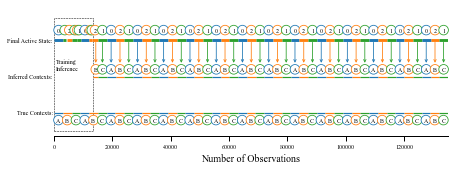

In [267]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\t_reuse_benefit\PhDCode-master-053ef69\RTREESAMPLE_Diff\2\run_8389899307811935008_0.csv"
path_to_csv =data_location / r"run_8389899307811935008_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-advantage_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

Covertype

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0.0 0 0.023506666666666665 0.9887829500841279 0.04592162327598557
0.0 1 0.0002666666666666667 0.011217049915872126 0.000520948647487074
0.0 2 0.0 0.0 0
0.0 3 0.0 0.0 0
0.0 4 0.0 0.0 0
2.0 0 0.165 0.9889714696715416 0.282815124610058
2.0 1 0.00184 0.011028530328458403 0.003153817147166707
2.0 2 0.0 0.0 0
2.0 3 0.0 0.0 0
2.0 4 0.0 0.0 0
3.0 0 0.7894133333333333 0.8390991935826755 0.8134983065286241
3.0 1 0.14437333333333333 0.15346022477642823 0.1487781586847945
3.0 2 0.00508 0.005399736390821866 0.005234990622359319
3.0 3 0.0 0.0 0
3.0 4 0.00192 0.002040845250074406 0.001978579132860215
8.0 0 0.0027333333333333333 0.0063882829541913365 0.003828555420674199
8.0 1 0.4202266666666667 0.9821439700841383 0.5886077131384816
8.0 2 0.004186666666666667 0.009784979744468682 0.005864226351666822
8.0 3 0.0 0.0 0
8.0 4 0.00072 0.0016827672172016203 0.0010084975254458866
11.0 0 0.0 0.0 0
11.0 1 0.0 0.0 0
11.0 2 0.9765066666666666 0.986995134967589 0.9817228876094986
11.0 3 0.012866666666666667 0.013

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 1 0.0 0.0 0
23.0 2 0.0 0.0 0
23.0 3 0.0 0.0 0
23.0 4 0.51652 0.9814547389222467 0.676835180962864
24.0 0 0.004693333333333333 0.03628865979381443 0.00831168831168831
24.0 1 0.0 0.0 0
24.0 2 0.0003333333333333333 0.002577319587628866 0.0005903187721369539
24.0 3 0.0 0.0 0
24.0 4 0.12430666666666666 0.9611340206185567 0.22014167650531286
33.0 0 0.0031866666666666666 0.009657346048165509 0.004792076031599632
33.0 1 0.0 0.0 0
33.0 2 0.0 0.0 0
33.0 3 0.0 0.0 0
33.0 4 0.32678666666666667 0.9903426539518345 0.4914183743032442
39.0 0 0.0017066666666666667 0.003711758735682181 0.0023382198474676897
39.0 1 0.4332933333333333 0.9423517471364361 0.5936338311184179
39.0 2 0.013893333333333334 0.030216035957662753 0.019034570945791664
39.0 3 0.00017333333333333334 0.00037697549659272147 0.00023747545325843725
39.0 4 0.010733333333333333 0.023343482673626213 0.014705210759464765
55.0 0 0.0 0.0 0
55.0 1 0.0 0.0 0
55.0 2 0.0 0.0 0
55.0 3 0.051853333333333335 0.9858048162230671 0.09852428906200518
55.0

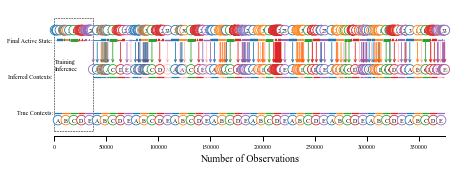

In [317]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\expDefault_o3\PhDCode-master-e4bf741\covtype-Elevation\1\run_2706034178945566144_0.csv"
path_to_csv =data_location / r"run_2706034178945566144_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-covtype_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

Advantage

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0 0 0.1 0.28036335090277 0.14741869858772888
0 1 0.22609333333333334 0.6338828455011027 0.3333038495936158
0 2 0.030586666666666668 0.08575380359612725 0.045090465941366675
0 3 0.0 0.0 0
0 4 0.0 0.0 0
1 0 0.18936 0.5364305949008499 0.2799113082039912
1 1 0.08025333333333333 0.22734655335221907 0.11863020448386302
1 2 0.08338666666666666 0.23622285174693106 0.12326188716432618
1 3 0.0 0.0 0
1 4 0.0 0.0 0
2 0 0.0 0.0 0
2 1 0.0 0.0 0
2 2 0.02104 0.942089552238806 0.0411607433974568
2 3 0.0012933333333333334 0.05791044776119403 0.0025301597652429082
2 4 0.0 0.0 0
3 0 0.0 0.0 0
3 1 0.0 0.0 0
3 2 0.0 0.0 0
3 3 0.04409333333333333 0.5112863327149041 0.08118525065056217
3 4 0.042146666666666666 0.48871366728509585 0.07760102125988116
4 0 0.0 0.0 0
4 1 0.0 0.0 0
4 2 0.0 0.0 0
4 3 0.7338133333333333 0.8254615811497907 0.7769440895583491
4 4 0.15516 0.17453841885020924 0.16427971455393758
5 0 0.20704 0.27693953986088815 0.23694209201190203
5 1 0.058666666666666666 0.0784733369003032 0.06713969634

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.06644874336852259 0.026478470227736202
23 1 0.0 0.0 0
23 2 0.0 0.0 0
23 3 0.0 0.0 0
23 4 0.23228 0.9335512566314774 0.3720011530946712
25 0 0.011933333333333334 1.0 0.023585216417418804
25 1 0.0 0.0 0
25 2 0.0 0.0 0
25 3 0.0 0.0 0
25 4 0.0 0.0 0
26 0 0.08416 0.8084016393442623 0.1524490387402183
26 1 0.019946666666666668 0.1915983606557377 0.036131774707757705
26 2 0.0 0.0 0
26 3 0.0 0.0 0
26 4 0.0 0.0 0
27 0 0.0 0.0 0
27 1 0.0 0.0 0
27 2 0.09662666666666667 0.9720992622401073 0.1757807288824207
27 3 0.0027733333333333334 0.02790073775989269 0.005045176156691529
27 4 0.0 0.0 0
28 0 0.0 0.0 0
28 1 0.0 0.0 0
28 2 0.0 0.0 0
28 3 0.09556 1.0 0.17444959655336084
28 4 0.0 0.0 0
29 0 0.0 0.0 0
29 1 0.0 0.0 0
29 2 0.0 0.0 0
29 3 0.0 0.0 0
29 4 0.027666666666666666 1.0 0.0538436587739215
Accuracy of Context-Inference was: 0.23791703703703704
s:\PhD\Packages\PhDCode\evaluation\thesis


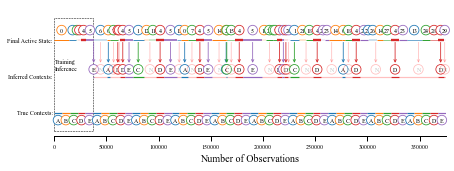

In [323]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\covtype-Elevation\PhDCode-master-1f1e5ae\covtype-Elevation\1\run_-7134763558641866696_0.csv"
path_to_csv =data_location / r"run_-7134763558641866696_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-covtype_comparison-ADV"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

SELeCT with Histogram Binning

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0.0 0 0.023453333333333333 1.0 0.04583175914225042
0.0 1 0.0 0.0 0
0.0 2 0.0 0.0 0
0.0 3 0.0 0.0 0
0.0 4 0.0 0.0 0
3.0 0 0.0164 0.9283018867924528 0.03223059285948248
3.0 1 0.0012666666666666666 0.07169811320754717 0.0024893547330494593
3.0 2 0.0 0.0 0
3.0 3 0.0 0.0 0
3.0 4 0.0 0.0 0
4.0 0 0.9456933333333334 0.9830492030492031 0.9640095141012573
4.0 1 0.016306666666666667 0.016950796950796952 0.016622494053686713
4.0 2 0.0 0.0 0
4.0 3 0.0 0.0 0
4.0 4 0.0 0.0 0
7.0 0 0.0 0.0 0
7.0 1 0.98072 0.9865339735507926 0.9836183955388544
7.0 2 0.013386666666666667 0.013466026449207328 0.013426229288971504
7.0 3 0.0 0.0 0
7.0 4 0.0 0.0 0
11.0 0 0.0 0.0 0
11.0 1 0.0 0.0 0
11.0 2 0.97384 0.9874269954574951 0.9805864346705332
11.0 3 0.0124 0.012573004542504866 0.012485903012727565
11.0 4 0.0 0.0 0
14.0 0 0.0 0.0 0
14.0 1 0.0 0.0 0
14.0 2 0.0 0.0 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


14.0 3 0.8995866666666666 0.9839434154878227 0.9398760186668524
14.0 4 0.01468 0.016056584512177337 0.015337466044438253
19.0 0 0.010786666666666667 0.010980807340445747 0.010882871248503437
19.0 1 0.0 0.0 0
19.0 2 0.0 0.0 0
19.0 3 0.0 0.0 0
19.0 4 0.9715333333333334 0.9890191926595543 0.9801982861831927
60.0 0 0.0 0.0 0
60.0 1 0.0 0.0 0
60.0 2 0.0 0.0 0
60.0 3 0.07345333333333333 0.9965629522431259 0.13682197496522946
60.0 4 0.00025333333333333333 0.0034370477568740954 0.00047188555533479037
68.0 0 0.0036666666666666666 0.07929642445213379 0.0070092266911352405
68.0 1 0.0017066666666666667 0.03690888119953864 0.0032624764235102206
68.0 2 0.012773333333333333 0.276239907727797 0.024417596982209303
68.0 3 0.01456 0.314878892733564 0.027833001988071572
68.0 4 0.013533333333333333 0.2926758938869666 0.025870418514553704
Accuracy of Context-Inference was: 0.9594103703703704
s:\PhD\Packages\PhDCode\evaluation\thesis


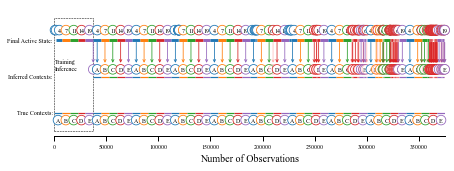

In [316]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\expDefault_o3\PhDCode-master-f408325\covtype-Elevation\1\run_4087607915628819025_0.csv"
path_to_csv =data_location / r"run_4087607915628819025_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-covtype_comparison-SELeCT_histogram"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

SELeCT with max repository size

0.0 0 0.022989731964261902 0.9885321100917431 0.04493444887533558
0.0 1 0.00026670222696359517 0.011467889908256881 0.0005212813094586494
0.0 2 0.0 0.0 0
0.0 3 0.0 0.0 0
0.0 4 0.0 0.0 0
2.0 0 0.014188558474463263 1.0 0.02798011938885529
2.0 1 0.0 0.0 0
2.0 2 0.0 0.0 0
2.0 3 0.0 0.0 0
2.0 4 0.0 0.0 0
3.0 0 0.8207894385918122 0.8401719901719902 0.8303676222596964
3.0 1 0.11694892652353647 0.1197106197106197 0.11831365935919055
3.0 2 0.0044139218562474995 0.004518154518154518 0.004465430016863407
3.0 3 0.0035338045072676356 0.003617253617253617 0.0035750421585160203
3.0 4 0.031110814775303374 0.031845481845481846 0.03147386172006745
8.0 0 0.023269769302573677 0.03894741540933845 0.029133345576573117
8.0 1 0.5176956927590345 0.8664851352557807 0.6481459839390955
8.0 2 0.00936124816642219 0.015668243906794038 0.011720119538541162
8.0 3 0.007654353913855181 0.01281135612891706 0.009583117685359866
8.0 4 0.039378583811174823 0.06590929381305241 0.04930130056597159
11.0 0 0.0 0.0 0
11.0 1 0.0 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


37.0 0 0.0 0.0 0
37.0 1 0.0 0.0 0
37.0 2 0.0 0.0 0
37.0 3 0.013495132684357914 1.0 0.026630878134785926
37.0 4 0.0 0.0 0
41.0 0 0.0 0.0 0
41.0 1 0.027310308041072144 1.0 0.05316856616215374
41.0 2 0.0 0.0 0
41.0 3 0.0 0.0 0
41.0 4 0.0 0.0 0
43.0 0 0.0 0.0 0
43.0 1 0.05676756900920123 0.9806496199032481 0.10732248427474758
43.0 2 0.0011068142418989198 0.019120018428933426 0.0020924985188640003
43.0 3 0.0 0.0 0
43.0 4 0.0 0.0 0
48.0 0 0.0 0.0 0
48.0 1 0.07879717295639418 0.9941117092866757 0.1460202140015321
48.0 2 0.0004533937858381118 0.005720053835800807 0.0008401907727283961
48.0 3 0.0 0.0 0
48.0 4 0.0 0.0 0
50.0 0 0.0 0.0 0
50.0 1 0.08401120149353247 1.0 0.1550006150818059
50.0 2 0.0 0.0 0
50.0 3 0.0 0.0 0
50.0 4 0.0 0.0 0
51.0 0 0.0 0.0 0
51.0 1 0.0 0.0 0
51.0 2 0.0 0.0 0
51.0 3 0.0037204960661421523 1.0 0.007413410567431479
51.0 4 0.0 0.0 0
55.0 0 0.0 0.0 0
55.0 1 0.043152420322709696 1.0 0.08273464065655921
55.0 2 0.0 0.0 0
55.0 3 0.0 0.0 0
55.0 4 0.0 0.0 0
56.0 0 0.0 0.0 0
56.0 

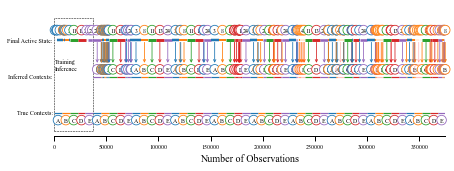

In [275]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\t_repo_max\PhDCode-master-e25e8bc\covtype-Elevation\1\run_-6400736979592349735_0.csv"
path_to_csv =data_location / r"run_-6400736979592349735_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-covtype_comparison-SELeCT-repomax_6"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

Poker

C:\Users\Ben\miniconda3\envs\phdcode-pytorch\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 0 0.7821152607855762 0.975876752500703 0.8683180526513323
0.0 1 0.017455470737913484 0.013778974008757482 0.015400848618189165
0.0 2 0.006209053007742704 0.008375848632145582 0.007131496588168899
0.0 3 0.0022653721682847896 0.001968424858393926 0.002106484964426198
0.0 4 0.0 0.0 0
0.0 5 0.0 0.0 0
1.0 0 0.0038795878943979393 0.181203007518797 0.007596532702915682
1.0 1 0.0003816793893129771 0.011278195488721804 0.0007383706620723603
1.0 2 0.0 0.0 0
1.0 3 0.01849283402681461 0.6015037593984962 0.0358824848620767
1.0 4 0.003355704697986577 0.12030075187969924 0.0065292797388288104
1.0 5 0.002193573215316529 0.08571428571428572 0.004277673545966229
2.0 0 0.19945267224726337 0.15571586567464307 0.17489131048500933
2.0 1 0.008040712468193384 0.003971445807359743 0.0053168220210653835
2.0 2 0.9807474687313877 0.8278076613714056 0.8978109154353634
2.0 3 0.02300046232085067 0.012505027146591595 0.016201517569283876
2.0 4 0.0 0.0 0
2.0 5 0.0 0.0 0
4.0 0 0.0 0.0 0
4.0 1 0.9741221374045802 0.9

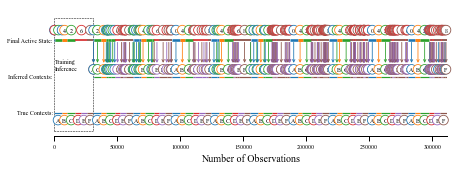

In [290]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\poker-lastcard\PhDCode-master-ed2331a\poker-LastCard\1\run_8609898001333774231_0.csv"
path_to_csv =data_location / r"run_8609898001333774231_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-poker_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

0 0 0.1213779781068899 0.9393297620530708 0.21497711947766832
0 1 0.003944020356234096 0.019309829326024666 0.006550172206140258
0 2 0.0049434187016081 0.04136040862090445 0.008831313923949619
0 3 0.0 0.0 0
0 4 0.0 0.0 0
0 5 0.0 0.0 0
1 0 0.0 0.0 0
1 1 0.044529262086514 1.0 0.08526187576126674
1 2 0.0 0.0 0
1 3 0.0 0.0 0
1 4 0.0 0.0 0
1 5 0.0 0.0 0
2 0 0.0 0.0 0
2 1 0.9246564885496183 0.9689624830013599 0.9462911605015428
2 2 0.017331745086360928 0.03103751699864011 0.022242817423540312
2 3 0.0 0.0 0
2 4 0.0 0.0 0
2 5 0.0 0.0 0
3 0 0.0 0.0 0
3 1 0.0 0.0 0
3 2 0.28930911256700415 0.9699965054166043 0.4456882017639435
3 3 0.013892741562644475 0.030003494583395737 0.018991641781611918
3 4 0.0 0.0 0
3 5 0.0 0.0 0
4 0 0.0 0.0 0
4 1 0.0 0.0 0
4 2 0.0 0.0 0
4 3 0.09313453536754508 1.0 0.17039903571655143
4 4 0.0 0.0 0
4 5 0.0 0.0 0
5 0 0.005376690276883451 0.030757896675568653 0.009153318077803202
5 1 0.0 0.0 0
5 2 0.0 0.0 0
5 3 0.012944983818770227 0.05157012616263008 0.020695134795543156
5 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 0
20 1 0.0 0.0 0
20 2 0.09325491363907087 0.9738765355310216 0.17021103124023315
20 3 0.003883495145631068 0.026123464468978386 0.006761787848906241
20 4 0.0 0.0 0
20 5 0.0 0.0 0
21 0 0.0 0.0 0
21 1 0.0 0.0 0
21 2 0.06124181060154854 1.0 0.11541537468606626
21 3 0.0 0.0 0
21 4 0.0 0.0 0
21 5 0.0 0.0 0
22 0 0.0 0.0 0
22 1 0.0 0.0 0
22 2 0.036509827278141754 0.9703205381875742 0.07037180535824472
22 3 0.0017337031900138697 0.0296794618124258 0.0032760390503854806
22 4 0.0 0.0 0
22 5 0.0 0.0 0
23 0 0.0 0.0 0
23 1 0.0 0.0 0
23 2 0.033338296605122095 1.0 0.06452542543840689
23 3 0.0 0.0 0
23 4 0.0 0.0 0
23 5 0.0 0.0 0
24 0 0.0 0.0 0
24 1 0.0 0.0 0
24 2 0.05287373436569386 1.0 0.10043699000155563
24 3 0.0 0.0 0
24 4 0.0 0.0 0
24 5 0.0 0.0 0
Accuracy of Context-Inference was: 0.17398097317195843
s:\PhD\Packages\PhDCode\evaluation\thesis


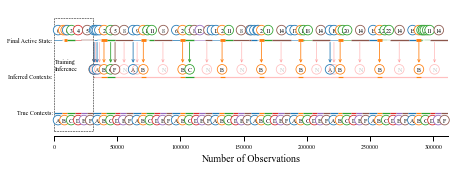

In [291]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\poker-lastcard\PhDCode-master-ed2331a\poker-LastCard\1\run_7915568782811667470_0.csv"
path_to_csv =data_location / r"run_7915568782811667470_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-poker_comparison-ADV"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

Covtype - Slope

0.0 0 0.6902133333333333 0.7191719922200611 0.7043951558035108
0.0 1 0.06805333333333333 0.07090858571825508 0.06945162607157437
0.0 2 0.0014666666666666667 0.0015282022784106697 0.0014968022860253095
0.0 3 0.0 0.0 0
0.0 4 0.2 0.20839121978327313 0.20410940263981495
9.0 0 0.0013733333333333334 0.004889627343935438 0.0021443814084213817
9.0 1 0.27484 0.9785426062188465 0.4291469317649508
9.0 2 0.004653333333333333 0.016567766437218134 0.007265913704262739
9.0 3 0.0 0.0 0
9.0 4 0.0 0.0 0
10.0 0 0.0 0.0 0
10.0 1 0.6336666666666667 0.9926063618705486 0.773525175172324
10.0 2 0.003586666666666667 0.005618329539046346 0.0043782908389553956
10.0 3 0.0 0.0 0
10.0 4 0.0011333333333333334 0.0017753085904049792 0.001383474800413415
11.0 0 0.0 0.0 0
11.0 1 0.0 0.0 0
11.0 2 0.48450666666666664 0.9721241305510968 0.6466987008364478
11.0 3 0.009133333333333334 0.018325307651150348 0.01219078127780744
11.0 4 0.00476 0.009550561797752809 0.006353443673251469
15.0 0 0.0 0.0 0
15.0 1 0.0 0.0 0
15.0 2 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 1 0.0 0.0 0
26.0 2 0.4908533333333333 0.9038768445088267 0.6362104571887772
26.0 3 0.009653333333333333 0.017776031820079058 0.01251198921618609
26.0 4 0.032733333333333337 0.060276461489356475 0.042426703764829904
29.0 0 0.01772 0.06789965769171818 0.02810527317521914
29.0 1 0.0 0.0 0
29.0 2 0.0051066666666666665 0.01956777193072089 0.0080995633003077
29.0 3 0.0002933333333333333 0.0011239973432790068 0.0004652490668584057
29.0 4 0.23785333333333333 0.9114085730342819 0.3772535501675954
Accuracy of Context-Inference was: 0.6839733333333333
s:\PhD\Packages\PhDCode\evaluation\thesis


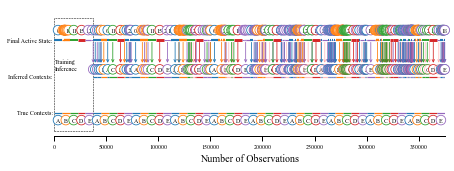

In [294]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\covtype-Slope\PhDCode-master-e4bf741\covtype-Slope\1\run_-679326763800858052_0.csv"
path_to_csv =data_location / r"run_-679326763800858052_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-covtype_slope_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.1), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

## Rangiora 

SELeCT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 0 0.14894240991238683 0.3883207493070821 0.21530390546340947
0.0 2 0.23769608430128128 0.569148427793176 0.3353418177722717
0.0 1 0.01567922766590913 0.04253082289974195 0.022911866544813295
1.0 0 0.07040214084093992 0.2768487818941906 0.11225742342763619
1.0 2 0.18506765656807567 0.6683724953149777 0.28987183494842134
1.0 1 0.013389003400102179 0.05477872279083177 0.021518467658592524
3.0 0 0.015139851167564793 0.28066598708800544 0.02872993513156293
3.0 2 0.038857621841695604 0.6615698267074414 0.07340383419103093
3.0 1 0.002994908655286014 0.057764186204553175 0.005694570059960474
6.0 0 0.6170680743429011 0.6709849722964085 0.6428980636290723
6.0 2 0.3032570949586876 0.302846095587356 0.3030514559234144
6.0 1 0.023131265084650212 0.0261689321162355 0.024556514583352812
7.0 0 0.009091242347593387 0.20187220187220187 0.017398930106112428
7.0 2 0.03825889115076039 0.7802197802197802 0.07294104217795788
7.0 1 0.0007751528284269683 0.01790801790801791 0.001485984464707869
10.0 0 0.10

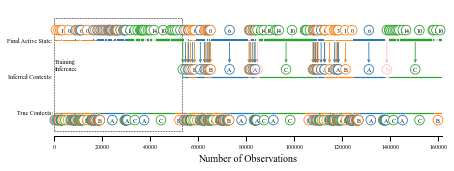

In [297]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test2-WD_4-mode-nonordered\PhDCode-master-e4bf741\Rangiora_test2-WD_4-nonordered\1\run_2684705200569657800_0.csv"
path_to_csv =data_location / r"run_2684705200569657800_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

FiCSUM

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0 0.26786172513655193 0.37977183545126164 0.31414783047969125
0 2 0.21983395202171396 0.2862451599490658 0.24868208653639928
0 1 0.22641509433962265 0.33398300459967256 0.2698752677334006
1 0 0.3935078265332307 0.46440545977633085 0.4260271662019903
1 2 0.45501536742106735 0.4931752795864068 0.4733274510821612
1 1 0.03454715219421102 0.04241926063726233 0.03808062762156284
2 0 0.0 0.0 0
2 2 0.0020157266594818986 1.0 0.004023343358495828
2 1 0.0 0.0 0
3 0 0.04080061585835258 0.08364647527431233 0.054847850190957254
3 2 0.10769169360954776 0.2027656696227266 0.14067102896321595
3 1 0.3345489139051847 0.7135878551029611 0.45553223388305847
4 0 0.001851240881263976 1.0 0.0036956402422290936
4 2 0.0 0.0 0
4 1 0.0 0.0 0
5 0 0.25143883573444775 0.8622792130240744 0.38934536733506464
5 2 0.040633856224803415 0.1279778741592809 0.06168295084450503
5 1 0.0027306520092313653 0.009742912816644666 0.004265741963892558
6 0 0.0 0.0 0
6 2 0.0 0.0 0
6 1 0.0017793280834346318 1.0 0.003552335396736072


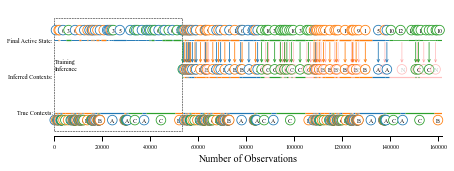

In [302]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test2-WD_4-mode-nonordered\PhDCode-master-e4bf741\Rangiora_test2-WD_4-nonordered\1\run_4332532440149766574_0.csv"
path_to_csv =data_location / r"run_4332532440149766574_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_comparison-FiCSUM"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

AiRStream

0 0 0.010136002052861175 0.4941912421805183 0.01986457603678359
0 2 0.011296052368977768 0.5058087578194816 0.02209858467545144
0 1 0.0 0.0 0
1 0 0.01028263499395139 0.4452380952380952 0.020101042674406103
1 2 0.012792879096315811 0.5087301587301587 0.024958143519059305
1 1 0.00102179236474464 0.046031746031746035 0.0019992072109335955
2 0 0.013435243227391033 0.3882415254237288 0.0259717251886759
2 2 0.021534347183969984 0.5715042372881356 0.04150478901411701
2 1 0.001338900340010218 0.04025423728813559 0.002591601166220525
3 0 0.0 0.0 0
3 2 0.027002754161178304 0.9395833333333333 0.05249679897567222
3 1 0.00153268854711696 0.06041666666666667 0.002989536621823617
4 0 0.0 0.0 0
4 2 0.02897856544126452 1.0 0.056324915629000355
4 1 0.0 0.0 0
5 0 0.012317167051578136 0.4772727272727273 0.02401458028088482
5 2 0.013910509719394884 0.4950284090909091 0.027060604884109177
5 1 0.0006870672797420855 0.027698863636363636 0.0013408743188186552
6 0 0.011730635287217274 0.5714285714285714 0.02298

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


107 0 0.008266432053960923 0.9395833333333333 0.016388676914132056
107 2 0.0005787730012373767 0.06041666666666667 0.0011465622899616494
107 1 0.0 0.0 0
108 0 0.010209318523406284 0.196680790960452 0.01941104722077017
108 2 0.03642278369855906 0.6444209039548022 0.06894858135932602
108 1 0.007927699381639449 0.15889830508474576 0.015101938082053866
109 0 0.0008431394112687415 0.02832512315270936 0.0016375351536079173
109 2 0.030315730651019838 0.9353448275862069 0.05872801082543978
109 1 0.0010394094744816166 0.03633004926108374 0.0020209978248582733
110 0 0.020491953517357674 0.38765603328710124 0.03892622123185126
110 2 0.03287031493234343 0.5710818307905686 0.062162672202302316
110 1 0.0020964360587002098 0.0412621359223301 0.003990142002112428
111 0 0.0 0.0 0
111 2 0.02893865006186884 1.0 0.05624951509038715
111 1 0.0 0.0 0
112 0 0.034990285567652775 0.6321192052980132 0.06631004897703983
112 2 0.010058675607711651 0.16688741721854305 0.018973760493920116
112 1 0.010693585610344766

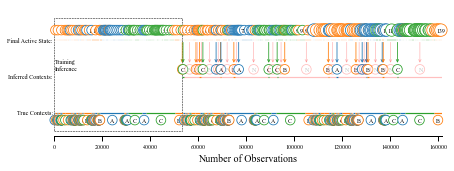

In [335]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test2-WD_4-mode-nonordered\PhDCode-master-e4bf741\Rangiora_test2-WD_4-nonordered\1\run_-6911827744921969632_0.csv"
# path_to_csv =data_location / r"run_-6911827744921969632_0.csv"
path_to_csv =data_location / r"run_-2966969036155799806_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_comparison-AiRStreams"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

SELeCT WS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 0 0.1473370270540082 0.5642263213227564 0.23365854623894244
0.0 1 0.36944480226716475 0.4111631463251458 0.38918918918918916
0.0 2 0.008879004172269922 0.02461053235209787 0.013049868234340156
1.0 0 0.09755914944594189 0.5635000720772668 0.16632273162429526
1.0 1 0.2545837090471897 0.4273461150353179 0.319080806178188
1.0 2 0.002189579669666563 0.009153812887415309 0.0035338638766764987
3.0 0 0.02858889887191774 0.7784573564390078 0.05515232489558131
3.0 1 0.026707887844046544 0.21134896364254163 0.047422994815492524
3.0 2 0.0005172235440157236 0.010193679918450561 0.0009844942160964804
6.0 0 0.5166342218229011 0.8251484832781919 0.6354232215486149
6.0 1 0.3453991154622354 0.16032207916450752 0.21899459591903409
6.0 2 0.012568532119582084 0.014529437557300594 0.013478035793521668
7.0 0 0.030585504642108415 0.9975579975579976 0.05935127674258109
7.0 1 0.0002576323586242432 0.002442002442002442 0.00046609182008855747
7.0 2 0.0 0.0 0
10.0 0 0.13770340421283817 0.18376047026693976 0.15

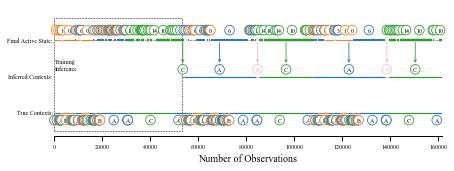

In [328]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test2-WS_4-mode-nonordered\PhDCode-master-e4bf741\Rangiora_test2-WS_4-nonordered\1\run_-2783198173949615223_0.csv"
path_to_csv =data_location / r"run_-2783198173949615223_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_WS_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

FiCSUM WS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0 0.2080962363981232 0.43335672149892157 0.28117386209396633
0 1 0.3236291811584868 0.19586289337595178 0.24403432086773516
0 2 0.24599151753387813 0.3707803851251267 0.2957619477006312
1 0 0.3943670759708496 0.6836185078630297 0.5001859692161597
1 1 0.5862424320494655 0.2953340976443358 0.3927903564544435
1 2 0.016775283610909967 0.021047394492634493 0.018670069365160077
2 0 0.0012603573924328641 1.0 0.0025175417824694346
2 1 0.0 0.0 0
2 2 0.0 0.0 0
3 0 0.07628281920734752 0.22970840222456035 0.1145314197924083
3 1 0.06333462149512646 0.05542612355328423 0.05911705176248973
3 2 0.32798869004517084 0.7148654742221554 0.4496655399815634
4 0 0.0012603573924328641 1.0 0.0025175417824694346
4 1 0.0 0.0 0
4 2 0.0 0.0 0
5 0 0.19726465009483876 0.9936513922936703 0.3291790306627102
5 1 0.004336811370174761 0.006348607706329751 0.005153324149191285
5 2 0.0 0.0 0
6 0 0.0 0.0 0
6 1 0.0 0.0 0
6 2 0.001741319264852936 1.0 0.0034765846858165667
7 0 0.0 0.0 0
7 1 0.0 0.0 0
7 2 0.001741319264852936

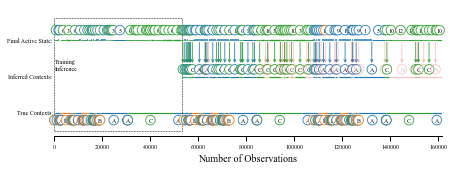

In [333]:
path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test3-WS_4-mode-nonordered\PhDCode-master-1f1e5ae\Rangiora_test2-WS_4-nonordered\1\run_-3287865123262157958_0.csv"
# path_to_csv =data_location / r"run_-4296171361633860356_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_WS_comparison-FiCSUM"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

AiRStream WS

0 0 0.013551961665169213 0.9705093833780161 0.026730662728447478
0 1 0.0014169779724333377 0.029490616621983913 0.002704031465093412
0 2 0.0 0.0 0
1 0 0.014625137266646701 0.9301587301587302 0.02879748390584304
1 1 0.0037786079264889 0.06984126984126984 0.007169334799788179
1 2 0.0 0.0 0
2 0 0.012191773984226814 0.517478813559322 0.023822295913391203
2 1 0.03576795912233243 0.4412076271186441 0.0661715057393653
2 2 0.0013447812144408813 0.0413135593220339 0.0026047754216062782
3 0 0.0 0.0 0
3 1 0.06183176606981837 1.0 0.1164624529904161
3 2 0.0 0.0 0
4 0 0.00398073275431766 0.2196969696969697 0.007819777418247782
4 1 0.04864957705354459 0.7803030303030303 0.0915888605957722
4 2 0.0 0.0 0
5 0 0.00803633822501747 0.45738636363636365 0.0157951535367409
5 1 0.032805186998153636 0.5426136363636364 0.061869862736364745
5 2 0.0 0.0 0
6 0 0.011480483178596386 0.8214285714285714 0.022644481638279017
6 1 0.008587745287474774 0.17857142857142858 0.016387398090868123
6 2 0.0 0.0 0
7 0 0.0065887990

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


110 0 0.0250324448437656 0.6955617198335645 0.04832570464948205
110 1 0.03770020181201426 0.3044382801664355 0.06709204141672716
110 2 0.0 0.0 0
111 0 0.00072376959169412 0.04 0.0014218125658814011
111 1 0.059770707200824426 0.96 0.11253486397995069
111 2 0.0 0.0 0
112 0 0.023185584506339223 0.6152317880794702 0.04468709413632209
112 1 0.0 0.0 0
112 2 0.020033791938209027 0.3847682119205298 0.0380846252171348
113 0 0.010382350004991514 1.0 0.020551328920067186
113 1 0.0 0.0 0
113 2 0.0 0.0 0
114 0 0.010382350004991514 1.0 0.020551328920067186
114 1 0.0 0.0 0
114 2 0.0 0.0 0
115 0 0.004791853848457622 1.0 0.009538002980625931
115 1 0.0 0.0 0
115 2 0.0 0.0 0
116 0 0.007587101926724568 1.0 0.015059942534429802
116 1 0.0 0.0 0
116 2 0.0 0.0 0
117 0 0.018955276030747727 1.0 0.03720531504500643
117 1 0.0 0.0 0
117 2 0.0 0.0 0
118 0 0.013177598083258461 0.21428571428571427 0.024828364525533716
118 1 0.0 0.0 0
118 2 0.0667563187476294 0.7857142857142857 0.12305736532655331
119 0 0.007524707996

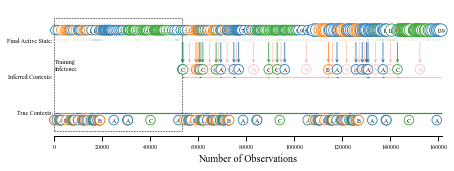

In [334]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test2-WD_4-mode-nonordered\PhDCode-master-e4bf741\Rangiora_test2-WD_4-nonordered\1\run_1325016000452234511_0.csv"
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test3-WS_4-mode-nonordered\PhDCode-master-1f1e5ae\Rangiora_test2-WS_4-nonordered\1\run_-818885678438340461_0.csv"
# path_to_csv =data_location / r"run_1325016000452234511_0.csv"
path_to_csv =data_location / r"run_-818885678438340461_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_WS_comparison-AiRStream2"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)

SELeCT time of day

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 0 0.07796399751707014 0.27706697255801643 0.12168656022322122
0.0 1 0.06762579239302693 0.7229330274419836 0.12368192625580253
1.0 0 0.01973929236499069 0.16649214659685863 0.03529411764705882
1.0 1 0.032851294241944 0.8335078534031414 0.06321122555131146
2.0 0 0.23339540657976413 0.2504863165187732 0.24163903241561918
2.0 1 0.23216290279978868 0.7495136834812268 0.3545144600104614
3.0 0 0.04725015518311608 0.24532680159855613 0.07923884077281812
3.0 1 0.04831946645536186 0.7546731984014439 0.09082375939616319
5.0 0 0.02798261949099938 0.2185379096373861 0.04961260785349534
5.0 1 0.03326399894347597 0.7814620903626139 0.06381176321560618
8.0 0 0.17497206703910614 0.24251497005988024 0.20327982346068973
8.0 1 0.18168086370839936 0.7574850299401198 0.29306970241661673
12.0 0 0.008069522036002483 0.37142857142857144 0.015795868772782502
12.0 1 0.004539751716851558 0.6285714285714286 0.00901439845280143
13.0 0 0.369211669770329 0.2608497351156019 0.30571231792436343
13.0 1 0.3477945060

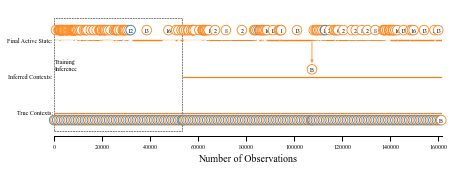

In [313]:
# path_to_csv =  r"S:\PhD\Packages\PhDCode\output\Rangiora_test2-day-mode-nonordered\PhDCode-master-e4bf741\Rangiora_test2-day-nonordered\1\run_-8829295893927709625_0.csv"
path_to_csv =data_location / r"run_-8829295893927709625_0.csv"
df = pd.read_csv(path_to_csv)
df.head()
focus=['A', 'B', 'C', 'D', 'E', 'F']
plot_state_relevance = False
plot_inference = True
save_name = "CI-Rangiora_TOD_comparison-SELeCT"
context = df['ground_truth_concept'].fillna(-1).values
save_file = True
plot_probabilities(df, 'state_relevance', focus=focus, context=context, CI_train_len=int(df.shape[0] * 0.33), plot_state_relevance=plot_state_relevance, plot_inference=plot_inference, save_name=f"{output_prefix}-{save_name}", save_location=output_location, save_file = save_file)